# Long Notebook
#### TDT4173 MACHINE LEARNING // Fall 2021

#### Participants: 
- Helle Villmones Haug, student ID: 507372
- Erik Galler, student ID: 529208   
- Beatrice Kiær, student ID: 477864

#### Kaggle competition name: Fit Check (Group 55)
#### Kaggle team name: Fit Check (Group 55)



### --------------------------------------------------------------------------------------------------------------------------------

# Table of contents

- [1. Introduction](#1.-Introduction)
  - [1.1. Load data](#1.1.-Load-data)
- [2. Exploratory Data Analysis (EDA)](#2.-Exploratory-Data-Analysis-(EDA))
  - [2.1. Open data](#2.1.-Open-data)
  - [2.2. Individual feature analysis by apartment](#2.2.-Individual-feature-analysis-by-apartment)
  - [2.3. Pairs and groups of features by apartment](#2.3.-Pairs-and-groups-of-features-by-apartment)
  - [2.4. Individual feature analysis by building](#2.4.-Individual-feature-analysis-by-building)
  - [2.5. Pairs and groups of features by building](#2.5.-Pairs-and-groups-of-features-by-building)
  - [2.6. Domain knowledge](#2.6.-Domain-knowledge)
  - [2.7. Intuition](#2.7.-Intuition)
  - [2.8. Understanding of data generation ](#2.8.-Understanding-of-data-generation)
- [3. Feature clean-up](#3.-Feature-clean-up)
  - [3.1. Nonsensicle labels](#3.1.-Nonsensicle-labels)
  - [3.2. Missing values](#3.2.-Missing-values)
      - [3.2.1 Continuous values](#3.2.1.-Continuous-values)
      - [3.2.2 Categorical values](#3.2.2.-Categorical-values)
      - [3.2.3 Intuitive imputation](#3.2.3.-Intuitive-imputation)
- [4. Feature engineering](#4.-Feature-engineering)
  - [4.1. Feature transformations](#4.1.-Feature-transformations)
  - [4.2. Creating new features - feature extraction](#4.2.-Creating-new-features---feature-extraction)
- [5. Drop features - feature selection](#5.-Drop-features---feature-selection)
- [6. Predictors](#6.-Predictors)
  - [6.1 Predictor 1](#6.1.-Predictor-1)
  - [6.2 Predictor 2](#6.2.-Predictor-2)
- [7. Model interpretation](#7.-Model-interpretation)
  - [7.1 Feature importance](#7.1.-Feature-importance)
  - [7.2 Tuning hyper parametres by EvalML](#7.2.-Tuning-hyper-parametres-by-EvalML)



## 1. Introduction

This notebook is part of the final project in TDT4173, Machine learning. The aim of the project is to predict price of apartments in Moscow. 

Two datasets were given as a basis: 1) real apartments data (apartments_train.csv) and 2) real buildings data (buildings_train.csv). The former constitutes the main data set, including 16 specific apartment attributes and the target value, price. The latter contributes with supplementary features about the buildings that the apartments are located in. Several apartments could belong to the same building. 

The results from the prediction were submitted in Kaggle, taking part of the competition against virtual teams implemented by the course staff. 

The following notebook will go step by step through the data explorations and modifications towards a merged dataset as well as model interpretations and predictors.   

#### 1.1. Load data

In [348]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

class Data:
    def __init__(self, valid=True):
         self.apartments_train = None
         self.apartments_test= None
         self.buildings_train = None
         self.buildings_test = None

         self.train = None
         self.test = None
         self.all = None
         self.target = None

         self.apartments_meta = None
         self.buildings_meta = None

    def open(self):
        """
        Imports data and joins apartments with corresponding buildings.
        """
        self.apartments_train = pd.read_csv('apartments_train.csv')
        self.buildings_train = pd.read_csv('buildings_train.csv')
        self.apartments_test = pd.read_csv('apartments_test.csv')
        self.buildings_test = pd.read_csv('buildings_test.csv')

        self.train = pd.merge(self.apartments_train, self.buildings_train.set_index('id'), how='left', left_on='building_id', right_index=True)
        self.test = pd.merge(self.apartments_test, self.buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
        print(f'Loaded {len(self.train)} training samples')
        print(f'Loaded {len(self.test)} test samples \n')
            
        # Initializing target and training data
        self.target = self.train['price']
        with open('apartments_meta.json') as f: 
            self.apartments_meta = json.load(f)
        with open('buildings_meta.json') as f: 
            self.buildings_meta = json.load(f)
            
        self.all = pd.concat([self.train, self.test])
        self.all['split'] = np.where(self.all['id'] <= np.max(self.train['id']), 'Train', 'Test')

    def describe_column(self, meta):
        """
        Utility function for describing a dataset column (see below for usage)
        """
        def f(x):
            d = pd.Series(name=x.name, dtype=object)
            m = next(m for m in meta if m['name'] == x.name)
            d['Type'] = m['type']
            d['#NaN'] = x.isna().sum()
            d['Description'] = m['desc']
            if m['type'] == 'categorical':
                counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
                d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
            elif m['type'] == 'real' or m['type'] == 'integer':
                stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
                d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
            elif m['type'] == 'boolean':
                counts = x.dropna().astype(bool).value_counts().sort_index()
                d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
            else:
                d['Statistics'] = f'#unique={x.nunique()}'
            return d
        return f

    def describe_data(self, data, meta):
        """
        Called by for example this.describe_data(data.apartments_train, data.apartments_meta)
        """
        df_desc = data.apply(self.describe_column(meta)).T
        desc = df_desc.style.set_properties(**{'text-align': 'left'})
        desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
        display(desc)
        return meta

    def root_mean_squared_log_error(self, y_true, y_pred):
        assert (y_true >= 0).all() 
        assert (y_pred >= 0).all()
        log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
        return np.mean(log_error ** 2) ** 0.5

    def plot_map(self, data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
        data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
        backdrop = plt.imread('moscow.png')
        backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
        if ax is None:
            plt.figure(figsize=(12, 8), dpi=100)
            ax = plt.gca()
        discrete = data[column].nunique() <= 20
        if not discrete:
            lo, hi = data[column].quantile([q_lo, q_hi])
            hue_norm = plt.Normalize(lo, hi)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
            sm.set_array([])
        else:
            hue_norm = None 
        ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
        sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
        ax.set_xlim(37, 38)    # min/max longitude of image 
        ax.set_ylim(55.5, 56)  # min/max latitude of image
        if not discrete:
            ax.legend().remove()
            ax.figure.colorbar(sm)
        ax.set_title(title)
        ax.plot()
        return ax, hue_norm

## 2. Exploratory Data Analysis (EDA)
[Go back to the "Table of contents"](#Table-of-contents)

#### Module imports

In [438]:
import geopandas as gpd
import math 

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point, Polygon

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 2.1. Open data
[Go back to the "Table of contents"](#Table-of-contents)

In [350]:
data = Data()
data.open()
df_train = data.train
df_test = data.test
df_all = data.all
print("Meta apartment training data description:")
data.describe_data(data.apartments_train, data.apartments_meta)
data.describe_data(data.buildings_train, data.buildings_meta)

Loaded 23285 training samples
Loaded 9937 test samples 

Meta apartment training data description:


[{'name': 'id',
  'type': 'integer_id',
  'desc': 'Unique ID of building for joining with apartments'},
 {'name': 'new',
  'type': 'boolean',
  'desc': 'Whether it is an old or new building'},
 {'name': 'latitude',
  'type': 'real',
  'desc': 'Latitude coordinate of building'},
 {'name': 'longitude',
  'type': 'real',
  'desc': 'Longitude coordinate of building'},
 {'name': 'district',
  'type': 'categorical',
  'desc': 'Administriative district within Moscow',
  'cats': ['Central',
   'North',
   'North-East',
   'East',
   'South-East',
   'South',
   'South-West',
   'West',
   'North-West',
   'Zelenograd',
   'Troitsk',
   'Novomoskovsk']},
 {'name': 'street', 'type': 'string', 'desc': 'Bulding street name'},
 {'name': 'address',
  'type': 'string',
  'desc': 'Building address (within street)'},
 {'name': 'constructed',
  'type': 'integer',
  'desc': 'Year when the building was constructed'},
 {'name': 'material',
  'type': 'categorical',
  'desc': 'Primary building material used 

### 2.2. Individual feature analysis by apartment
[Go back to the "Table of contents"](#Table-of-contents)

In [351]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_train.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['price'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}'.format(df_test.shape[0]))

Number of Training Examples = 23285
Number of Test Examples = 23285

Training X Shape = (23285, 34)
Training y Shape = 23285

Test X Shape = (9937, 33)
Test y Shape = 9937


#### Target (price)
Price has an exponential distribution and should be log-transformed. The box plots indicate that there are several outliers in the upper region. 

Number of NaN values: 0


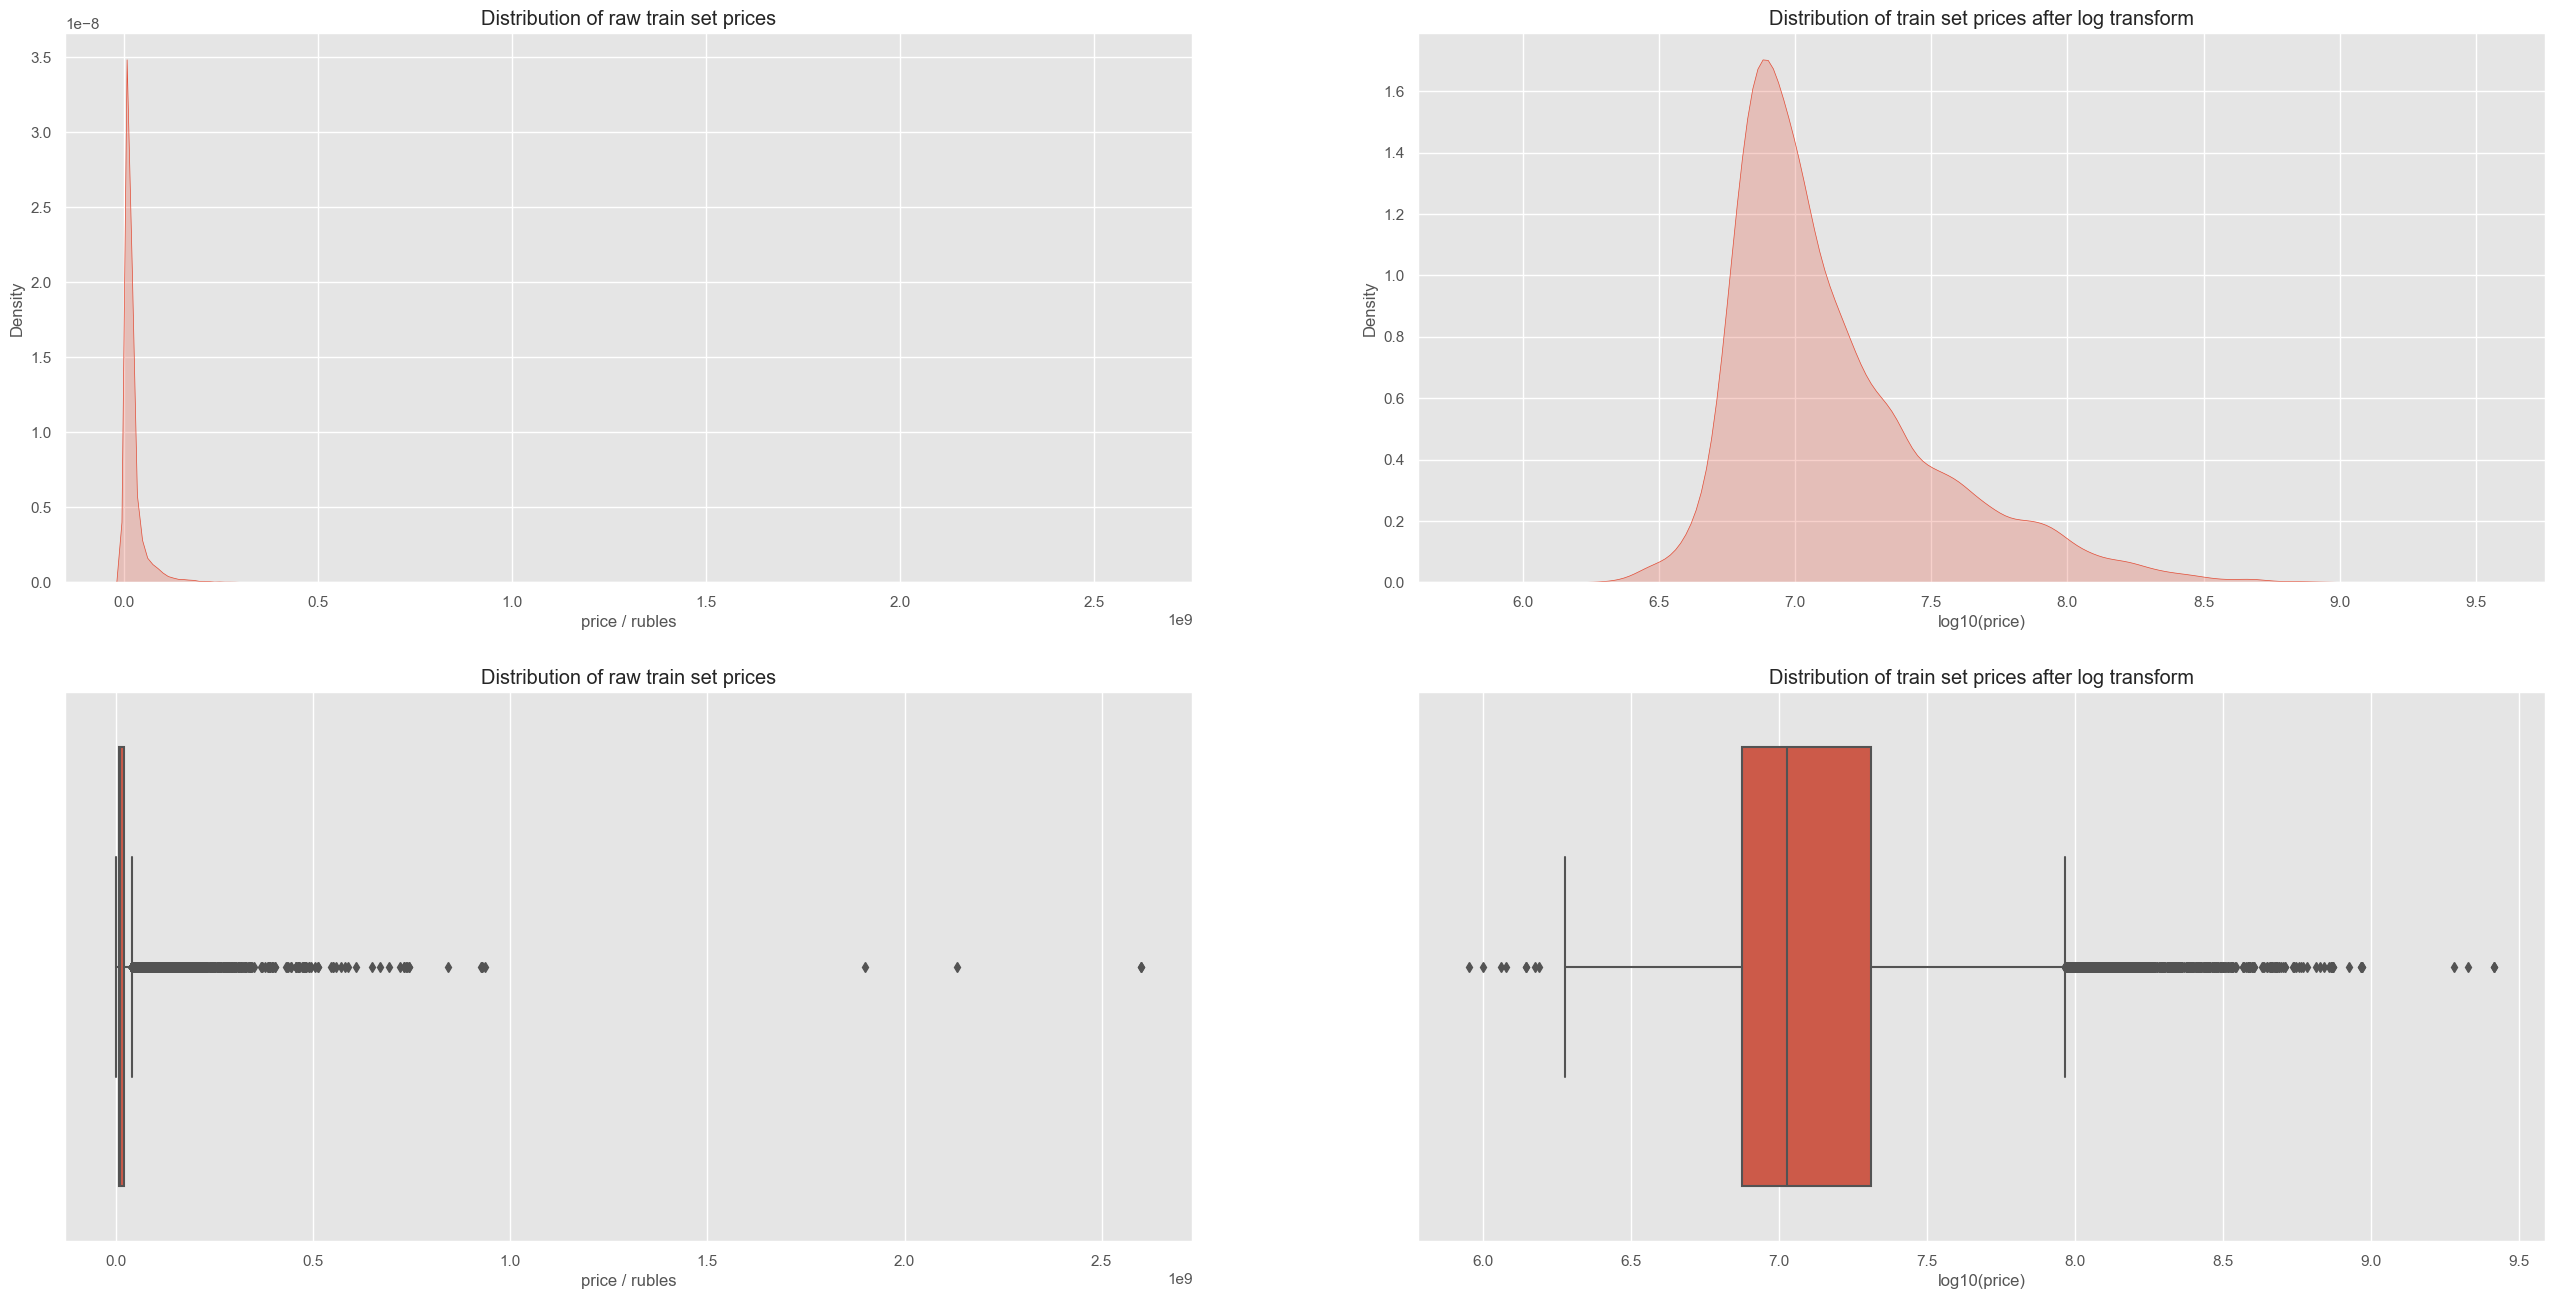

In [352]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(figsize=(32, 16), nrows=2, ncols=2, dpi=100)
sns.kdeplot(df_train.price.rename('price / rubles'), shade=True, ax=ax1)
ax1.set_title('Distribution of raw train set prices');
sns.kdeplot(x=np.log10(df_train.price).rename('log10(price)'), shade=True, ax=ax2)
ax2.set_title('Distribution of train set prices after log transform');

sns.boxplot(df_train.price.rename('price / rubles'), ax=ax3)
ax3.set_title('Distribution of raw train set prices');
sns.boxplot(x=np.log10(df_train.price).rename('log10(price)'), ax=ax4)
ax4.set_title('Distribution of train set prices after log transform');

print("Number of NaN values:", df_train['price'].isnull().sum());

In [353]:
df_train['price'] = df_train['price'].apply(lambda x: np.log10(x));
"""
Revert:
print(df_train['price'].head(3))
df_train['price'] = df_train['price'].apply(lambda x: 10**x);
print(df_train['price'].head(3))
"""

"\nRevert:\nprint(df_train['price'].head(3))\ndf_train['price'] = df_train['price'].apply(lambda x: 10**x);\nprint(df_train['price'].head(3))\n"

#### Seller
The KDE plot indicate that NaN values should be a category itself since it does not have any matching attributes. Thin box plots indicate low variances. The train and test distributions look proportionally equal.

In [354]:
print('Number of sellers in category (train + test):')
print('Owner:', df_all.loc[df_all['seller'] == 0].shape[0])
print('Company:', df_all.loc[df_all['seller'] == 1].shape[0])
print('Agents:', df_all.loc[df_all['seller'] == 2].shape[0])
print('Developer:', df_all.loc[df_all['seller'] == 3].shape[0])

print("Number of NaN values:", df_train['seller'].isnull().sum());

Number of sellers in category (train + test):
Owner: 2331
Company: 6837
Agents: 2744
Developer: 8538
Number of NaN values: 8830


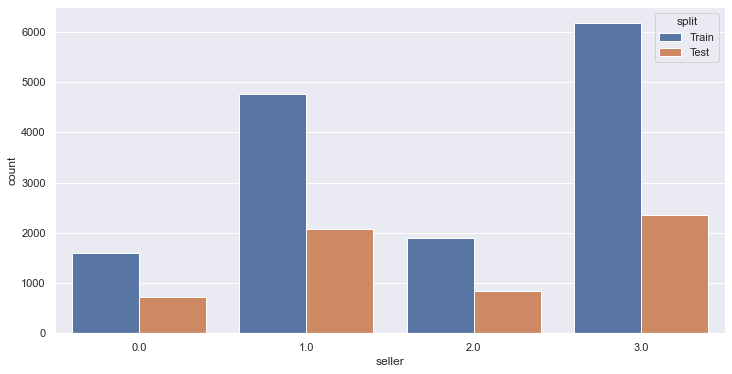

In [355]:
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )
f,ax=plt.subplots(1, 1, figsize=(12, 6))
sellers = ['Owner', 'Company', 'Agents', 'Developer']
sns.countplot('seller', hue='split', data=df_all, ax=ax);

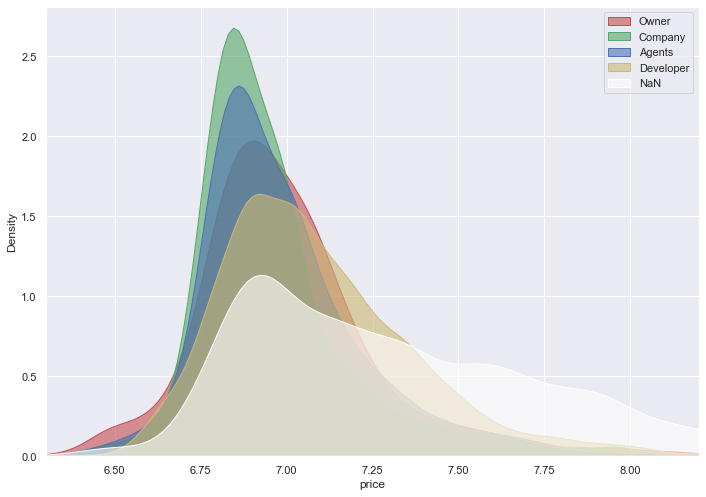

In [356]:
colors = ['r', 'g', 'b', 'y']

label_patches = []
plt.xlim(6.3, 8.2)
for i, seller in enumerate(sellers):
    sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['seller'] == i].price, 
       fill=True, common_norm=False, palette="crest", color=colors[i],
       alpha=.6, linewidth=1, label=sellers[i]
    )
sns.kdeplot(
       data= df_train, x=df_train.loc[np.isnan(df_train['seller'])].price, 
       fill=True, common_norm=False, palette="crest", color='w',
       alpha=.6, linewidth=1, label='NaN')
plt.legend();


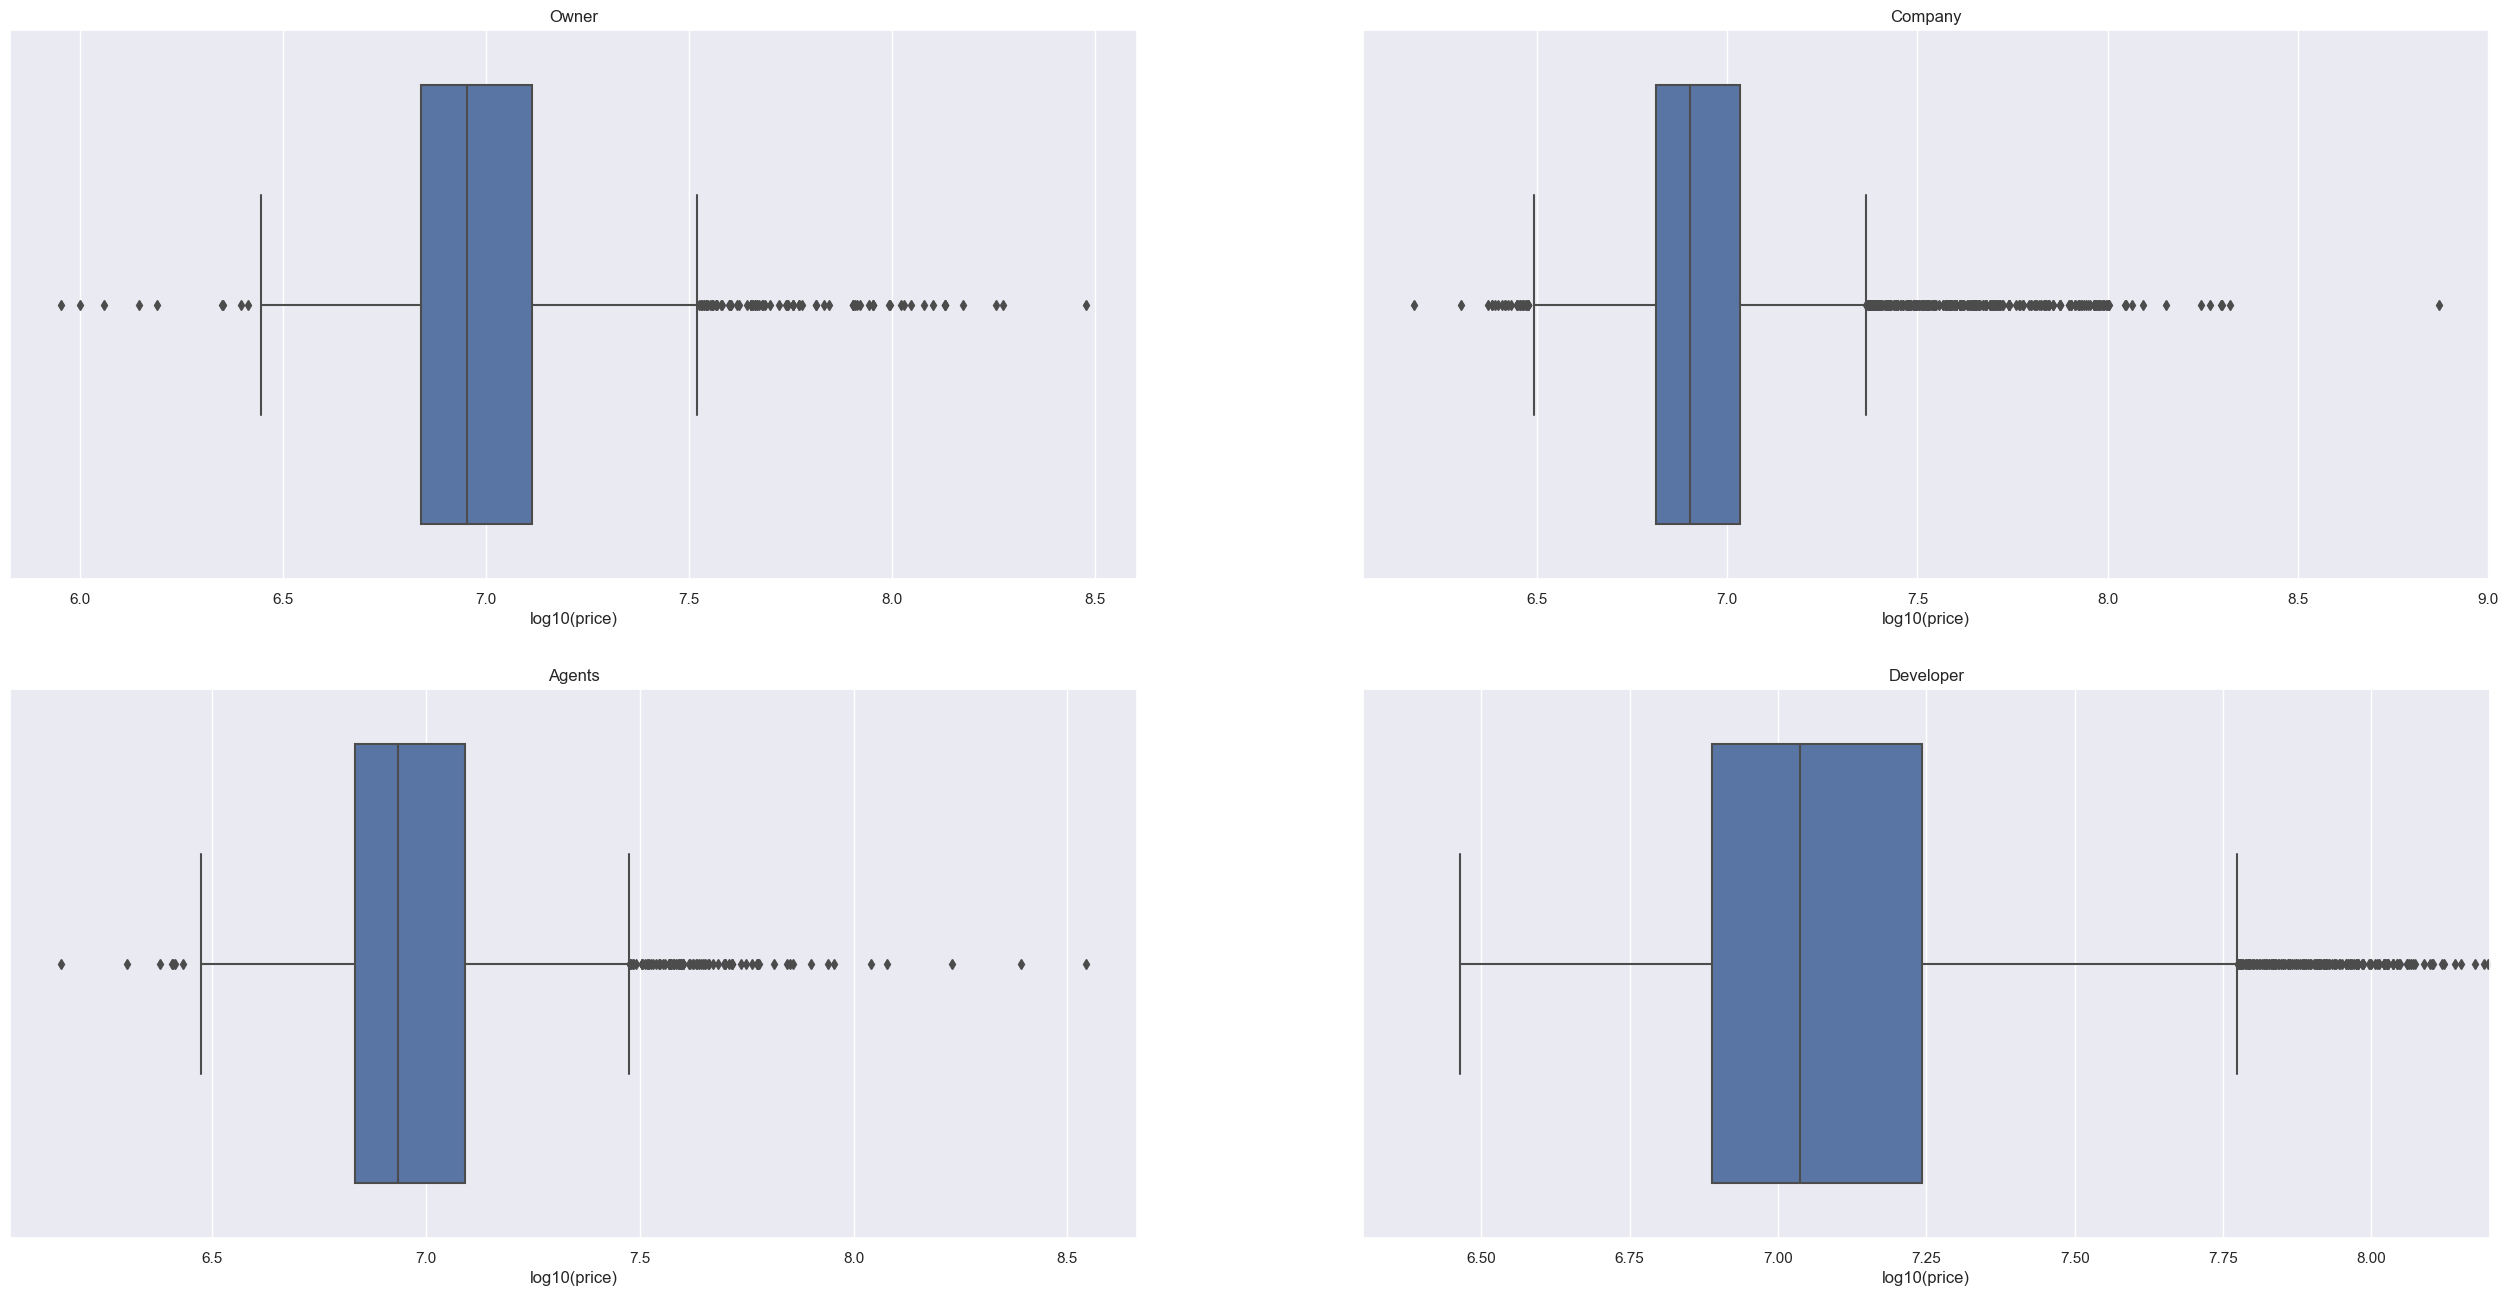

In [357]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(figsize=(32, 16), nrows=2, ncols=2, dpi=100)
plt.xlim(6.3, 8.2)

sns.boxplot(x=df_train.loc[df_train['seller'] == 0].price.rename('log10(price)'), ax=ax1)
ax1.set_title('Owner');
sns.boxplot(x=df_train.loc[df_train['seller'] == 1].price.rename('log10(price)'), ax=ax2)
ax2.set_title('Company');
sns.boxplot(x=df_train.loc[df_train['seller'] == 2].price.rename('log10(price)'), ax=ax3)
ax3.set_title('Agents');
sns.boxplot(x=df_train.loc[df_train['seller'] == 3].price.rename('log10(price)'), ax=ax4)
ax4.set_title('Developer');

#### Area Total
The area correlates positively with price. The total area distribution looks like a square root function. Could potentially fit f(x) = a*sqrt(x-h) + k.
This looked good in the beginning, but y-values do not converge. Another obtion is to fit a aymptotic exponential function, bounded exponetial function, or logistic function. 

Number of NaN values: 0
f(x) = 0.6log(x + 1) + 4.5


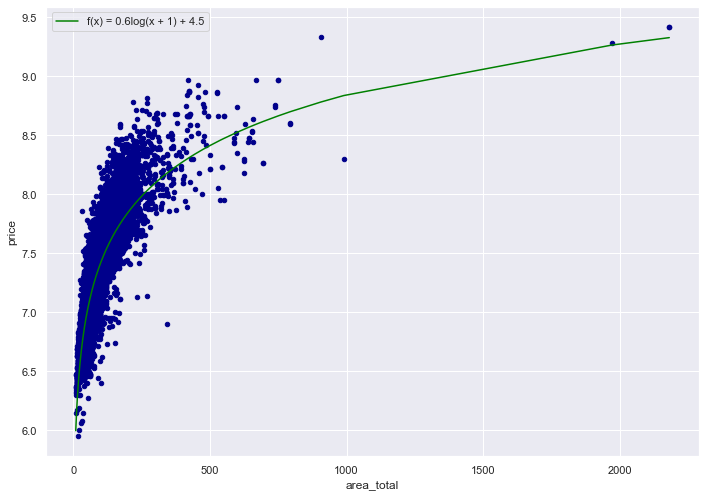

In [358]:
print("Number of NaN values:", df_train['area_total'].isnull().sum()),;
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )
df_train.plot.scatter(x='area_total', y='price', c='DarkBlue');

logistic_func = lambda x, a, off : a * np.log(x + 1) + off;
(a, off), covariance = curve_fit(logistic_func, df_train['area_total'], df_train['price']);
log_string = f"f(x) = {round(a, 1)}log(x + 1) + {round(off, 1)}";
print(f"{log_string}");
plt.plot(df_train['area_total'].sort_values(), logistic_func(df_train['area_total'].sort_values(), a, off), \
color='green', label=log_string);
plt.legend();

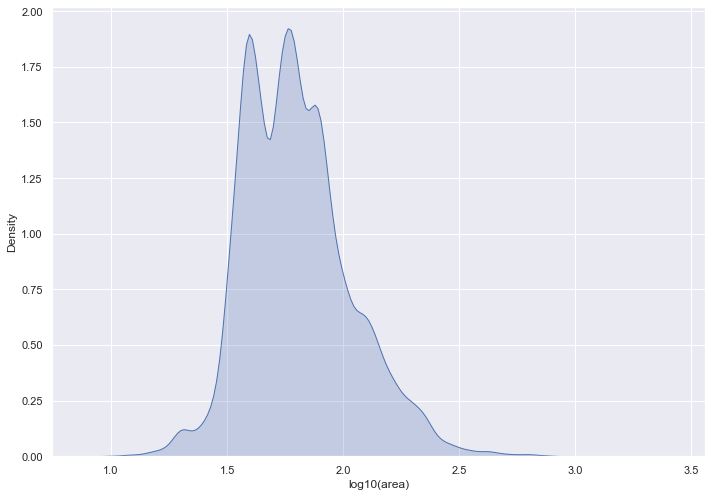

In [359]:
sns.kdeplot(x=np.log10(df_train.area_total).rename('log10(area)'), shade=True);

#### Area Kitchen
Similarly, price increases with kitchen area. Potentially because a large kitchen area indicates a large total area. Could potentially be log transformed(?). 

Number of NaN values: 4721
Calculated MSE: 0.0775
No.of.unique values: 385


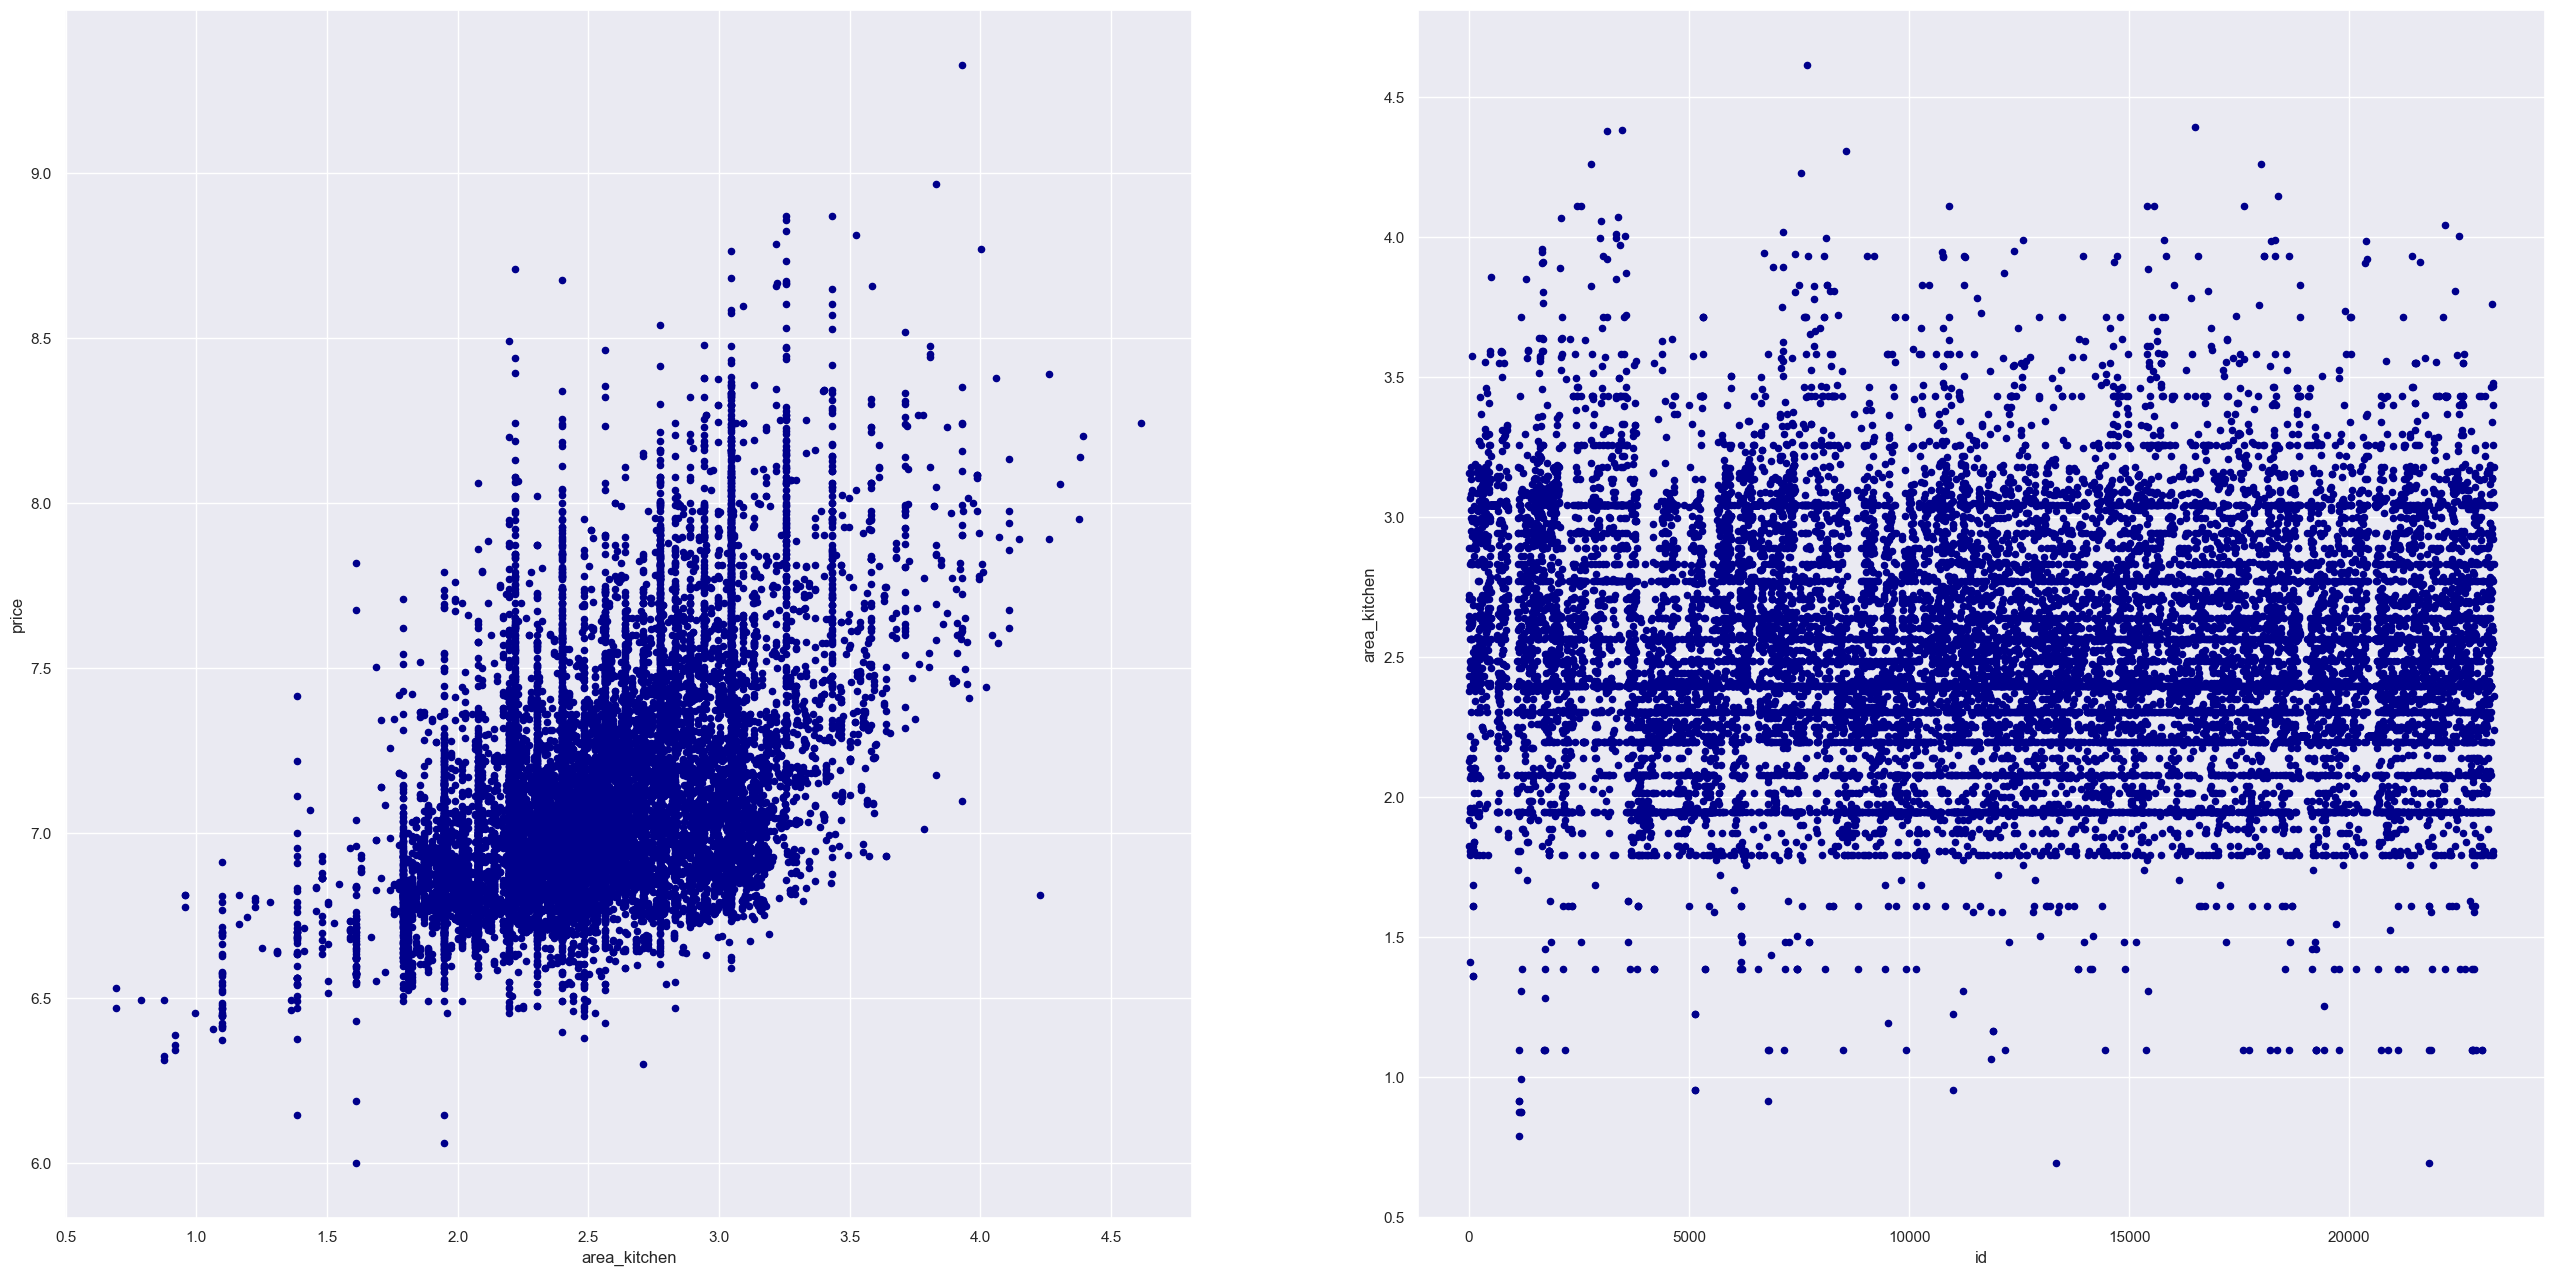

In [360]:
print("Number of NaN values:", df_train['area_kitchen'].isnull().sum());
lin_func = lambda x, a, b : a*x + b;

df_train_copy = df_train.copy();
df_train_copy.dropna(subset = ["area_kitchen"], inplace=True);

df_train_copy['area_kitchen'] = df_train_copy['area_kitchen'].apply(lambda x: np.log(x+1));
df_train['area_kitchen'] = df_train['area_kitchen'].apply(lambda x: np.log(x+1));

(a, b), covariance = curve_fit(lin_func, df_train_copy['area_kitchen'], df_train_copy['price']);
predict = lin_func(df_train_copy['area_kitchen'], a, b)
dt_mse = round(mean_squared_error(predict, df_train_copy['price']), 4)
print('Calculated MSE:', dt_mse)
print(f"No.of.unique values: {len(pd.unique(df_train_copy['area_kitchen']))}")
fig, (ax1, ax2) = plt.subplots(figsize=(32, 16), nrows=1, ncols=2, dpi=100)

df_train_copy.plot.scatter(x='area_kitchen', y='price', c='DarkBlue', ax=ax1);
df_train_copy.plot.scatter(x='id', y='area_kitchen', c='DarkBlue', ax=ax2);
#plt.plot(df_train['area_kitchen'], '.', ax=ax2);

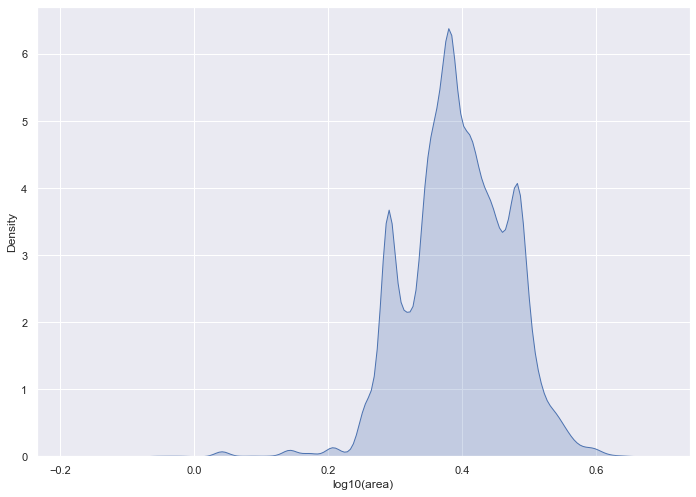

In [361]:
sns.kdeplot(x=np.log10(df_train.area_kitchen).rename('log10(area)'), shade=True);

#### Area Living
Simirarly to kitchen area, living area has a strong correlation with total area. This can potentially be used in a missing value problem. Maybe strip the dataset for NaN and 0 values, since 0 m^2? Or does this mean that there is no living room in the apartment? Total area can not be less than the living room area or kitchen area. Have to do something with these rows.

In [362]:
print("Number of NaN values:", df_train['area_living'].isnull().sum());
print("Number of 0 values:", df_train[df_train['area_living'] == 0]['area_living'].count());

Number of NaN values: 3882
Number of 0 values: 94


f(x) = 1.1log(x + 57.4) + 2.1 
covariance = 
[[ 8.31163753e-04  7.85339855e-02 -4.72764117e-03]
 [ 7.85339855e-02  7.73723138e+00 -4.50568458e-01]
 [-4.72764117e-03 -4.50568458e-01  2.69399552e-02]]


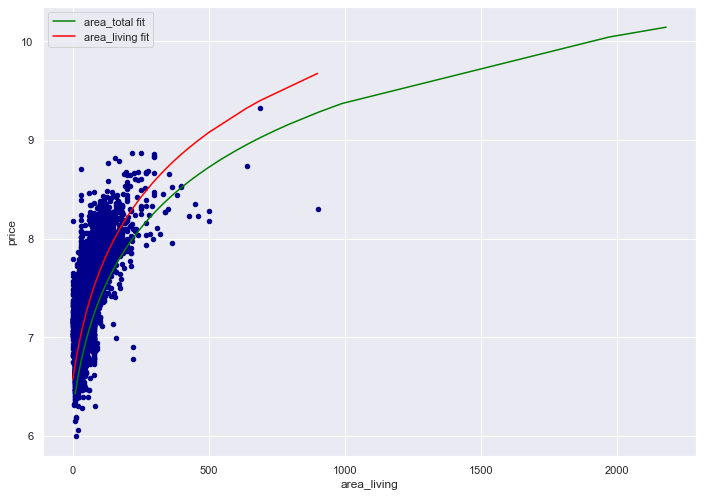

In [363]:
df_train.plot.scatter(x='area_living', y='price', c='DarkBlue');

logistic_func = lambda x, a, b, off : a * np.log(x + b) + off;
(a, b, off), covariance = curve_fit(logistic_func, df_train['area_total'], df_train['price']);
plt.plot(df_train['area_total'].sort_values(), logistic_func(df_train['area_total'].sort_values(), a, b, off), \
color='green', label="area_total fit");

df_train_copy = df_train.copy()[df_train.area_living != 0];
df_train_copy.dropna(subset = ["area_living"], inplace=True);
p0 = [a, b, off]
(a, b, off), covariance = curve_fit(logistic_func, df_train_copy['area_living'], df_train_copy['price'], p0);
log_string = f"f(x) = {round(a, 1)}log(x + {round(b, 1)}) + {round(off, 1)}"
print(f"{log_string} \ncovariance = \n{covariance}");
plt.plot(df_train_copy['area_living'].sort_values(), \
logistic_func(df_train_copy['area_living'].sort_values(), a, b, off), color='red', label='area_living fit');
plt.legend();

Looks like there are some apartments upon 500 m^2 with living room area equal to 0. Interesting...

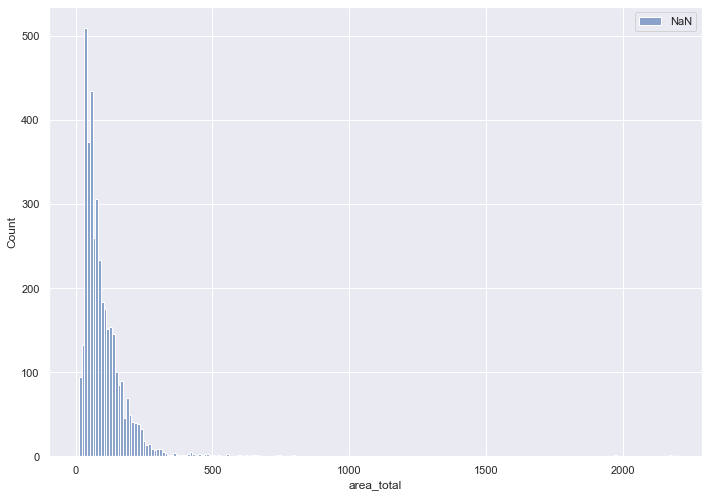

In [364]:
colors = ['r', 'g', 'b', 'y']
layouts =['Decorated', 'Euro_repair', 'Special_design', 'Undecorated']

#plt.xlim(6.3, 8.2)    
sns.histplot(
       data= df_train, x=df_train.loc[df_train['area_living'].isnull()].area_total, 
       fill=True, common_norm=False, palette="crest", color='b',
       alpha=.6, linewidth=1, label='NaN')

plt.legend();

Calculated MSE: 0.0432


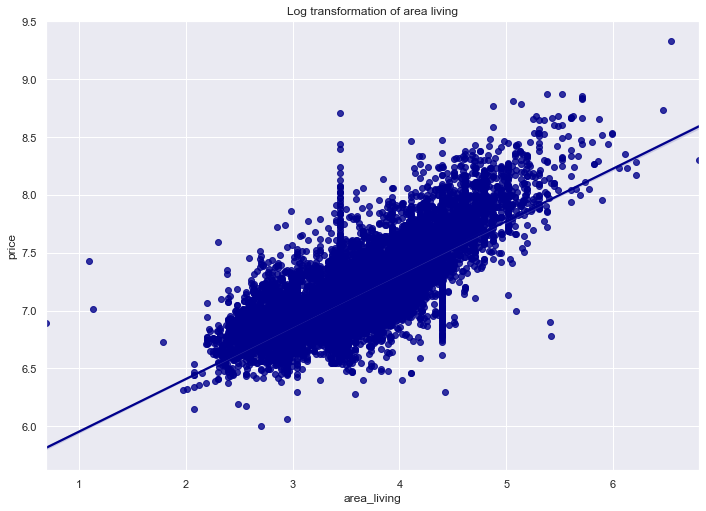

In [365]:
df_train_copy = df_train.copy();
df_train_copy.dropna(subset = ["area_living"], inplace=True);
df_train_copy = df_train_copy[df_train_copy.area_living != 0]

df_train_copy['area_living'] = df_train_copy['area_living'].apply(lambda x: np.log(x+1));

(a, b), covariance = curve_fit(lin_func, df_train_copy['area_living'], df_train_copy['price']);
predict = lin_func(df_train_copy['area_living'], a, b)
dt_mse = round(mean_squared_error(predict, df_train_copy['price']), 4)
print('Calculated MSE:', dt_mse)
sns.regplot(x="area_living", y="price", data=df_train_copy, color="DarkBlue").set_title('Log transformation of area living');

df_train['area_living']= df_train['area_living'].replace(0, np.nan)
df_train['area_living'] = df_train['area_living'].apply(lambda x: np.log(x + 1));

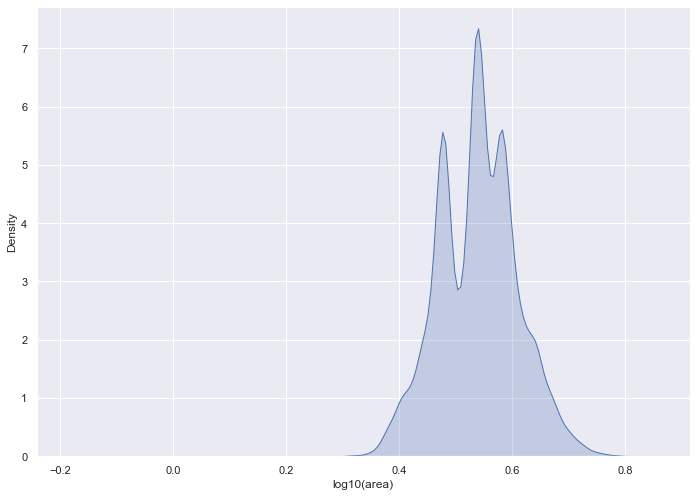

In [366]:
sns.kdeplot(x=np.log10(df_train.area_living).rename('log10(area)'), shade=True);

##### Living area vs tota area ratio
The plot below shows high correlation between living area and total area ratio and price. A large living room indicates a higher price. 

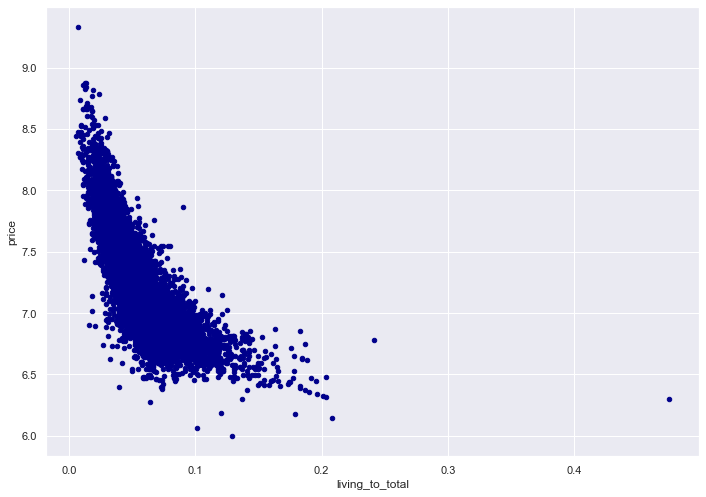

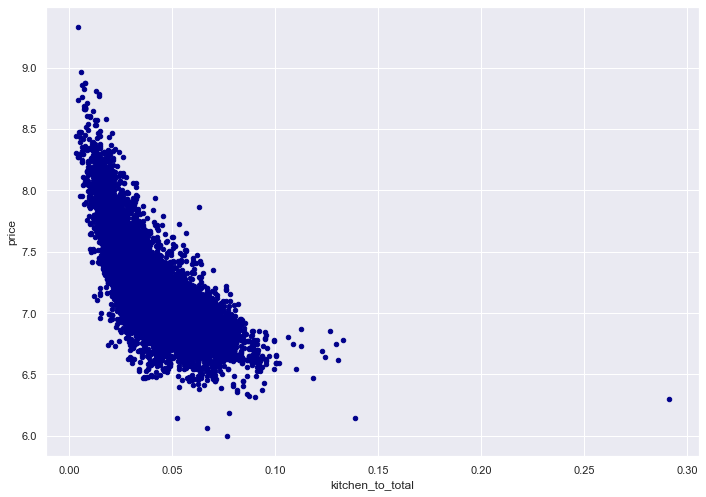

In [367]:
df_train["living_to_total"] = df_train.apply(lambda row: row['area_living'] / row['area_total'], axis=1)
df_test["living_to_total"] = df_test.apply(lambda row: row['area_living'] / row['area_total'], axis=1)

df_train.plot.scatter(x='living_to_total', y='price', c='DarkBlue');

df_train["kitchen_to_total"] = df_train.apply(lambda row: row['area_kitchen'] / row['area_total'], axis=1)
df_train.plot.scatter(x='kitchen_to_total', y='price', c='DarkBlue');

#### Room
Many outliers in some of the room values. 

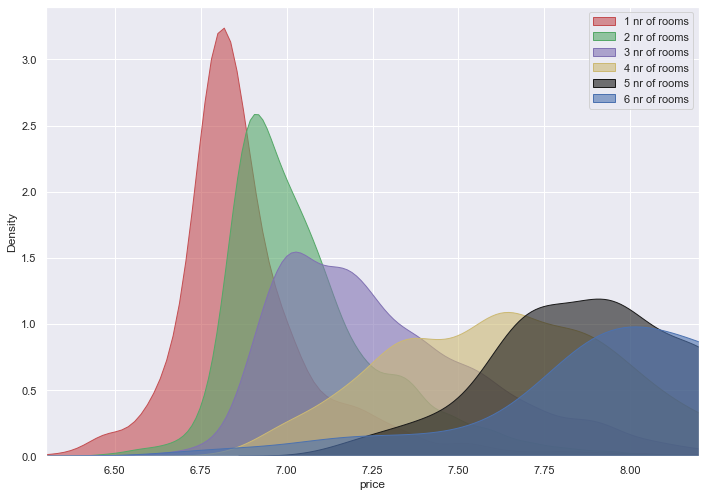

In [368]:
colors = ['r', 'g', 'm', 'y', 'k', 'b']

label_patches = []
plt.xlim(6.3, 8.2)
for i, color in enumerate(colors):
    sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['rooms'] == i+1].price, 
       fill=True, common_norm=False, palette="crest", color=color,
       alpha=.6, linewidth=1, label=f'{i+1} nr of rooms'
    )
plt.legend();

#### Layout

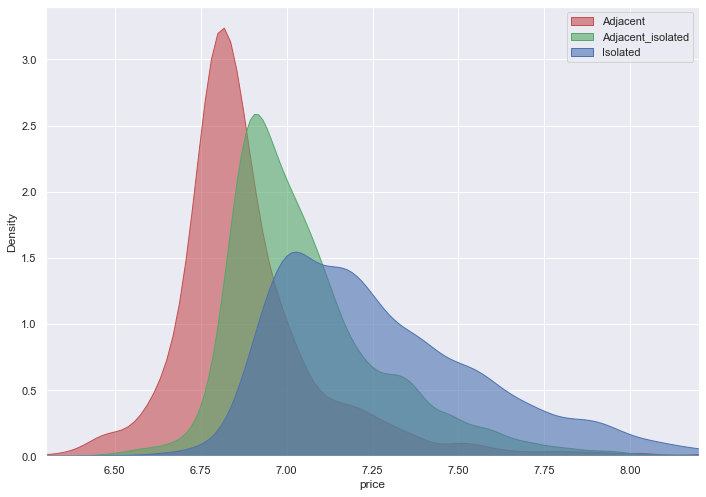

In [369]:
colors = ['r', 'g', 'b']
layouts =['Adjacent', 'Adjacent_isolated', 'Isolated']

label_patches = []
plt.xlim(6.3, 8.2)
for i, color in enumerate(colors):
    sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['rooms'] == i+1].price, 
       fill=True, common_norm=False, palette="crest", color=color,
       alpha=.6, linewidth=1, label=layouts[i]
    )
plt.legend();

#### Ceiling
Ceiling (height) should be around 2m. However, looks like there are some differences in units here. Those above 250 are potentially in cm and not in m. Those around 30 are potentially in dm?

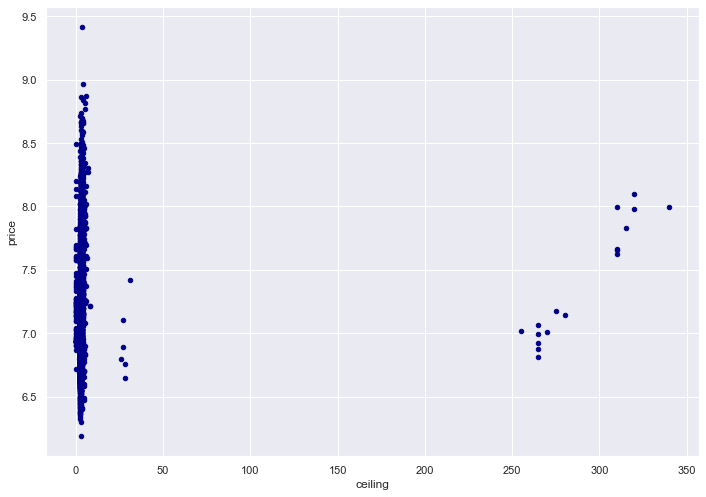

In [370]:
df_train.plot.scatter(x='ceiling', y='price', c='DarkBlue');

#### Bathrooms
No clear trend between price and whether the bathroom is private or not. However, some correlation between price and number of toilets. 

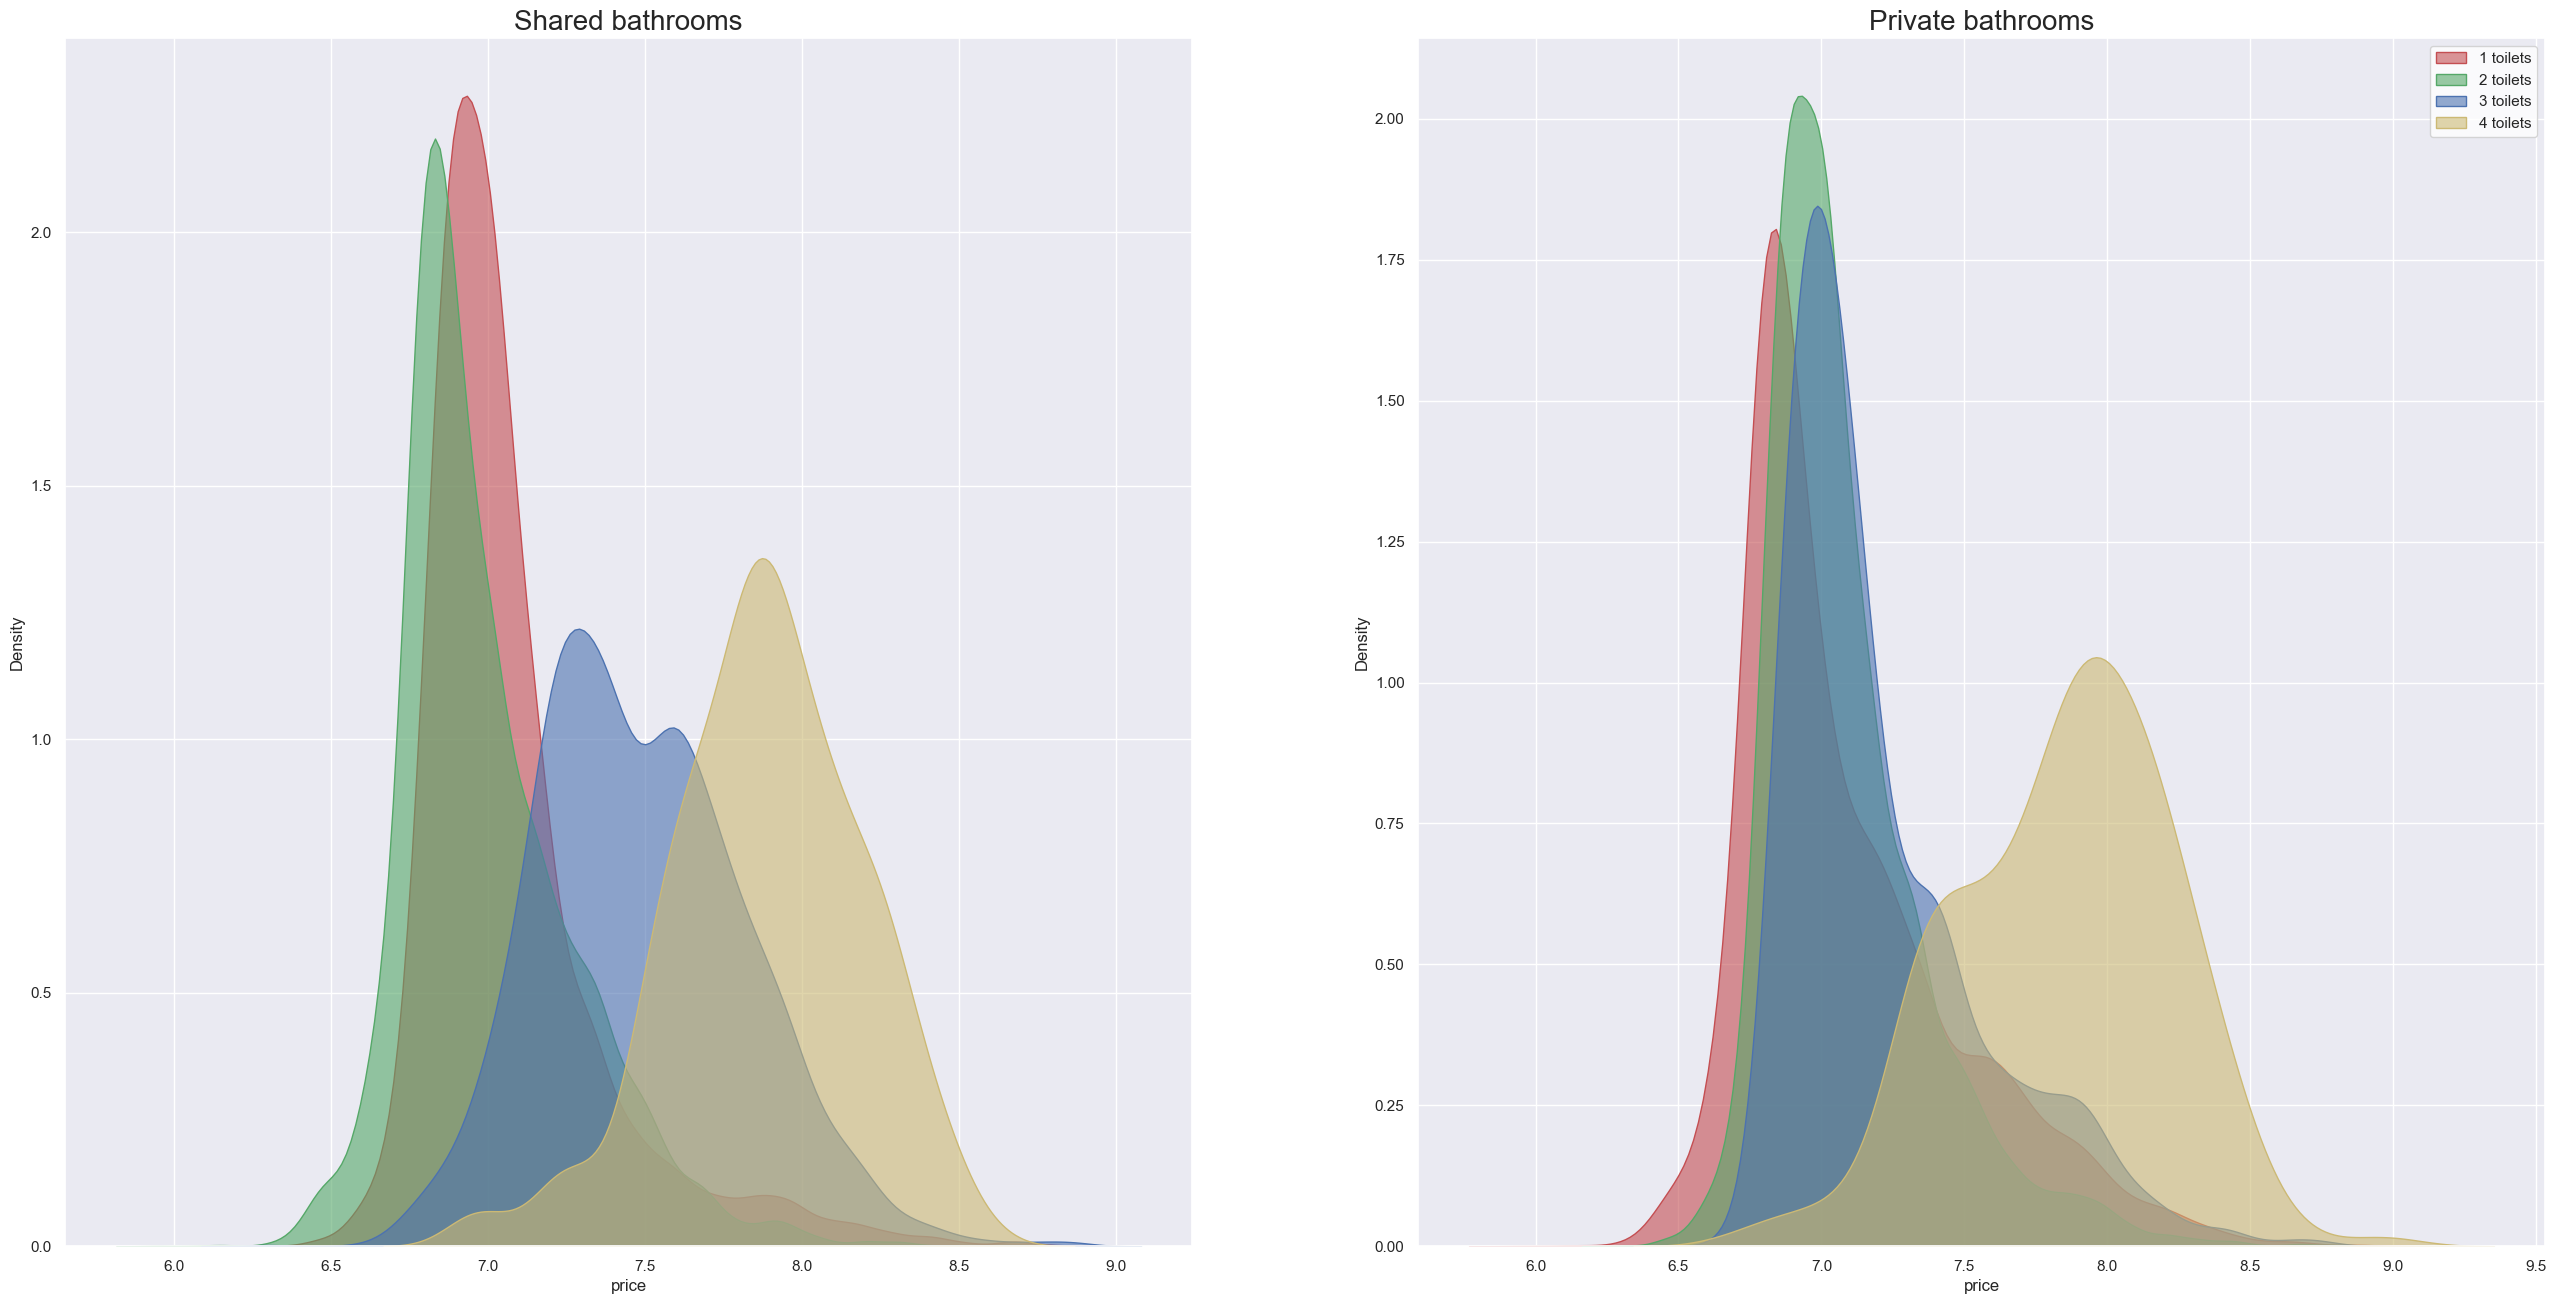

In [371]:
fig, (ax1, ax2) = plt.subplots(figsize=(32, 16), nrows=1, ncols=2, dpi=100)
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
colors = ['r', 'g', 'b', 'y']

label_patches = []
for i, color in enumerate(colors):
    sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['bathrooms_shared'] == i].price, 
       fill=True, common_norm=False, palette="crest", color=colors[i],
       alpha=.6, linewidth=1, label=f'{i+1} number of toilets', ax = ax1
    ).set(title='Shared bathrooms')
    
for i, color in enumerate(colors):
    sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['bathrooms_private'] == i].price, 
       fill=True, common_norm=False, palette="crest", color=colors[i],
       alpha=.6, linewidth=1, label=f'{i+1} toilets', ax = ax2
    ).set(title='Private bathrooms')
plt.legend();

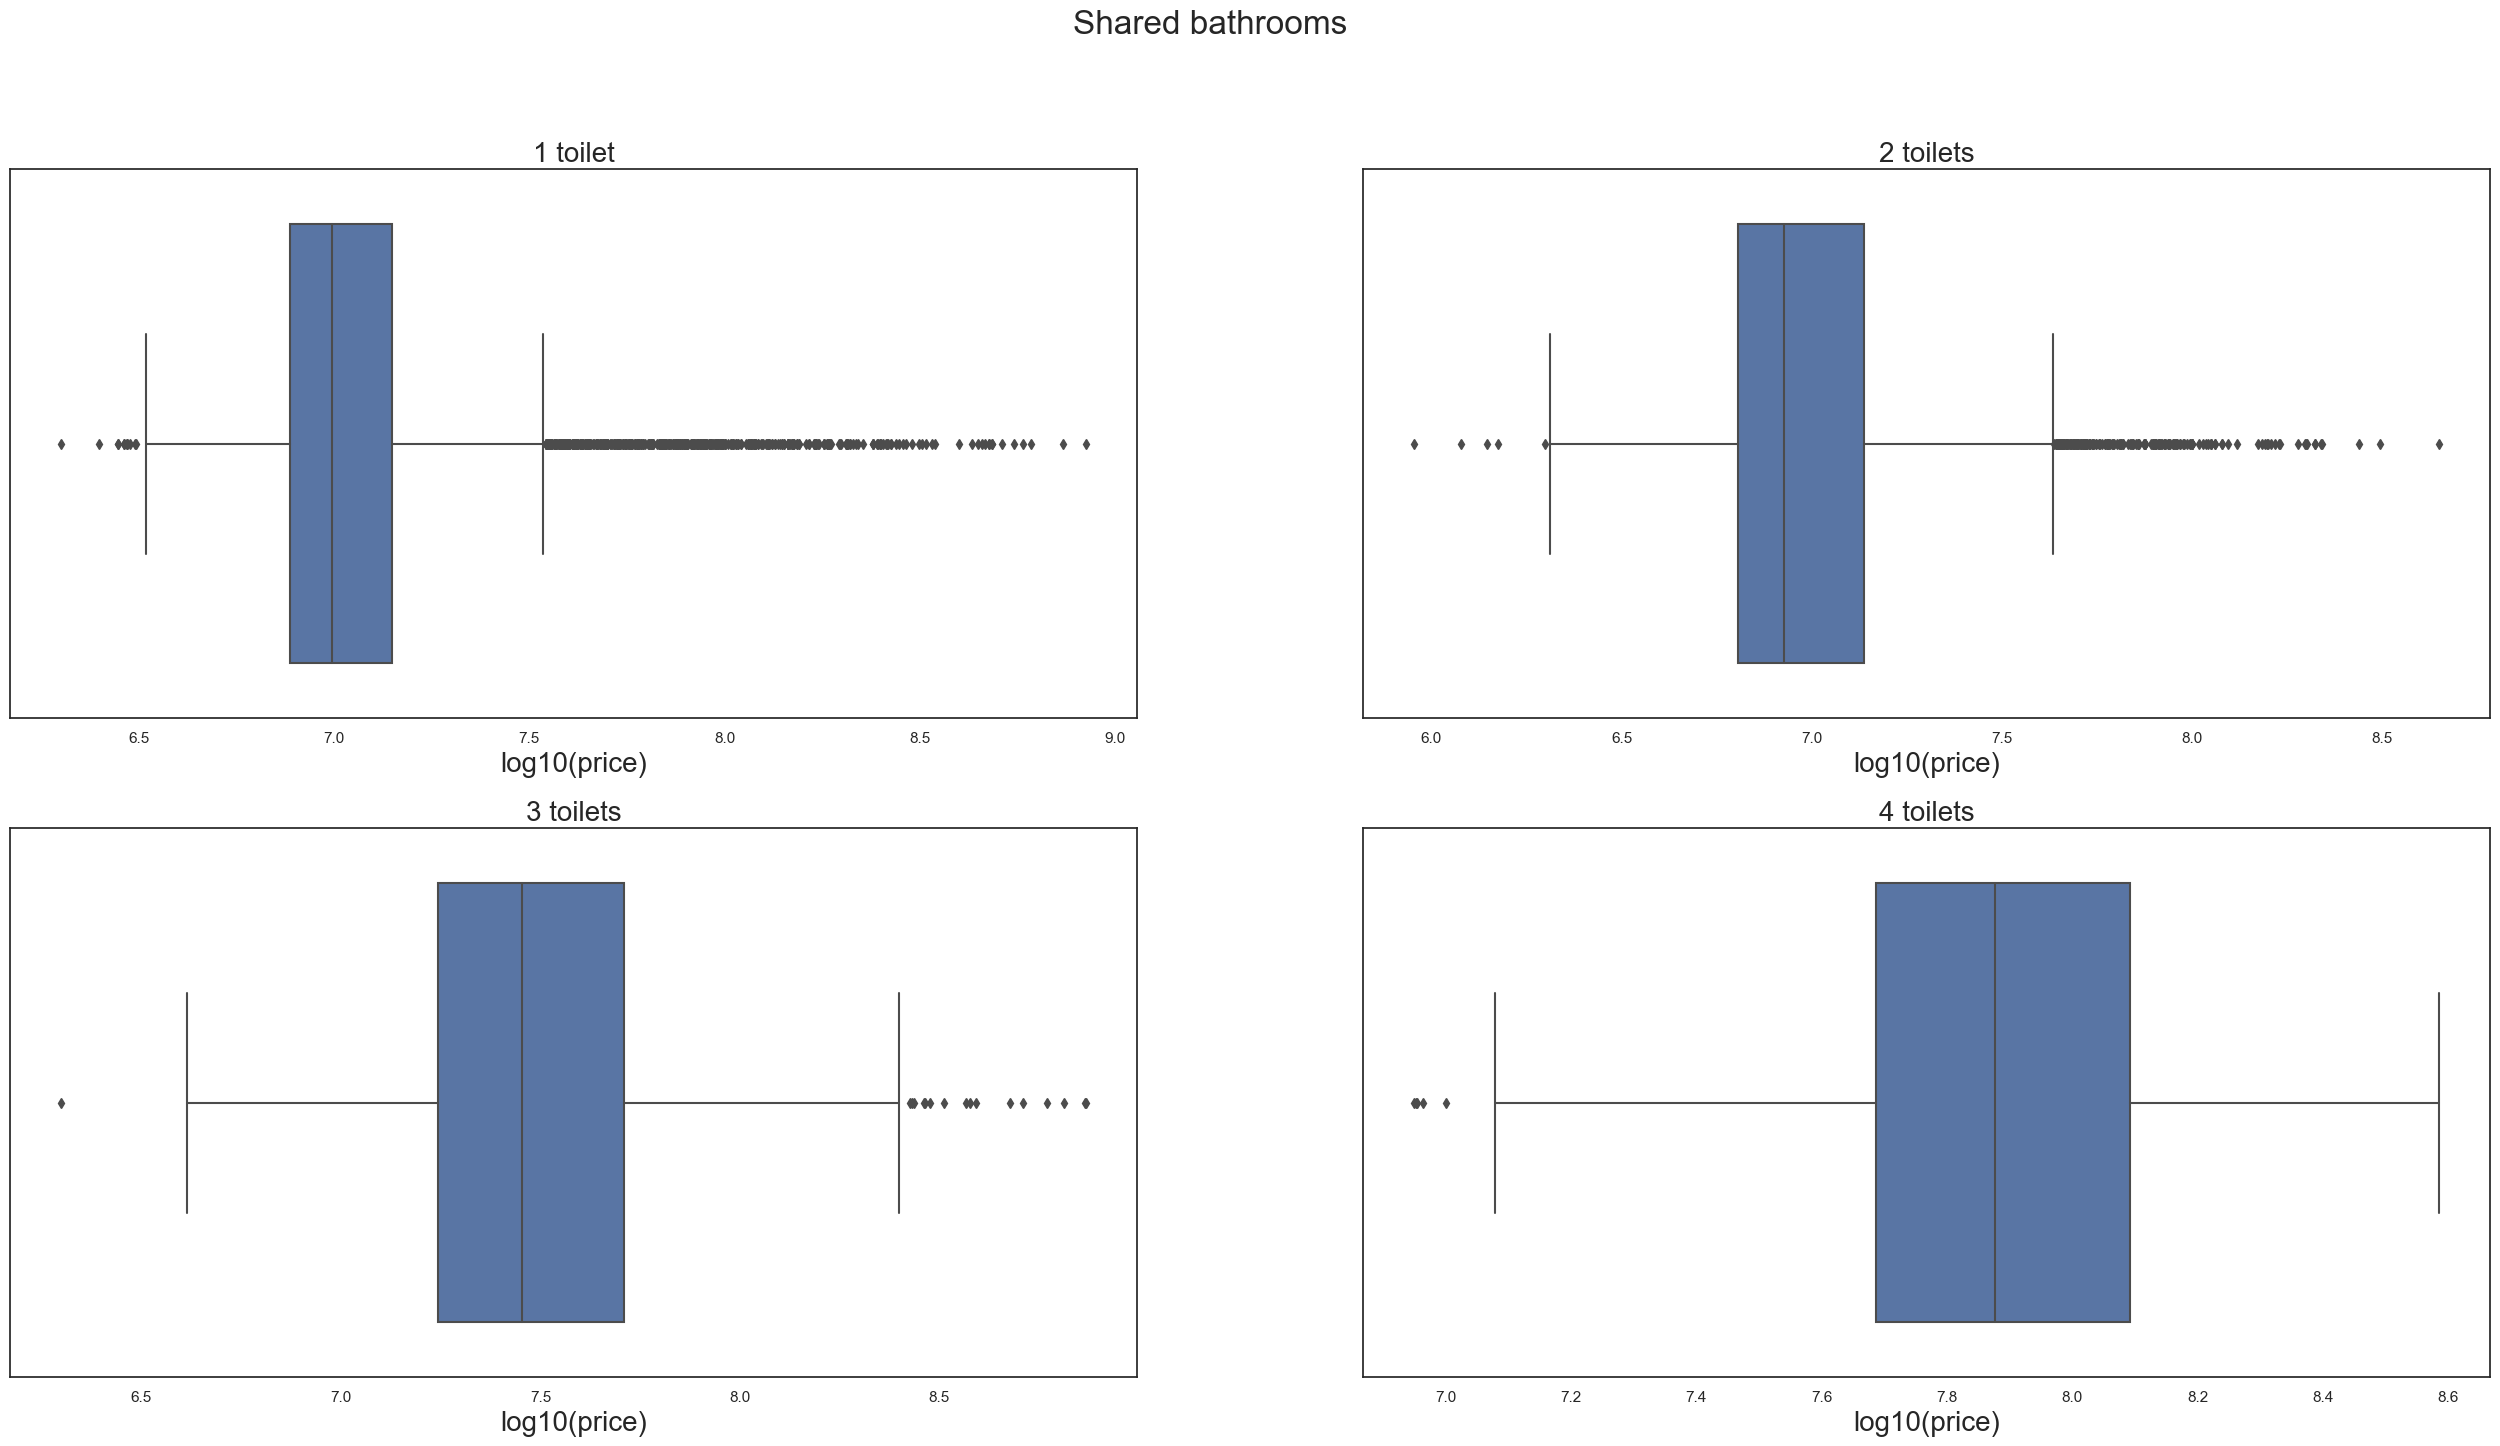

In [372]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(figsize=(32, 16), nrows=2, ncols=2, dpi=100)
sns.boxplot(x=df_train.loc[df_train['bathrooms_shared'] == 0].price.rename('log10(price)'), ax=ax1)
ax1.set_title('1 toilet');
sns.boxplot(x=df_train.loc[df_train['bathrooms_shared'] == 1].price.rename('log10(price)'), ax=ax2)
ax2.set_title('2 toilets');
sns.boxplot(x=df_train.loc[df_train['bathrooms_shared'] == 2].price.rename('log10(price)'), ax=ax3)
ax3.set_title('3 toilets');
sns.boxplot(x=df_train.loc[df_train['bathrooms_shared'] == 3].price.rename('log10(price)'), ax=ax4)
ax4.set_title('4 toilets');
fig.suptitle('Shared bathrooms');


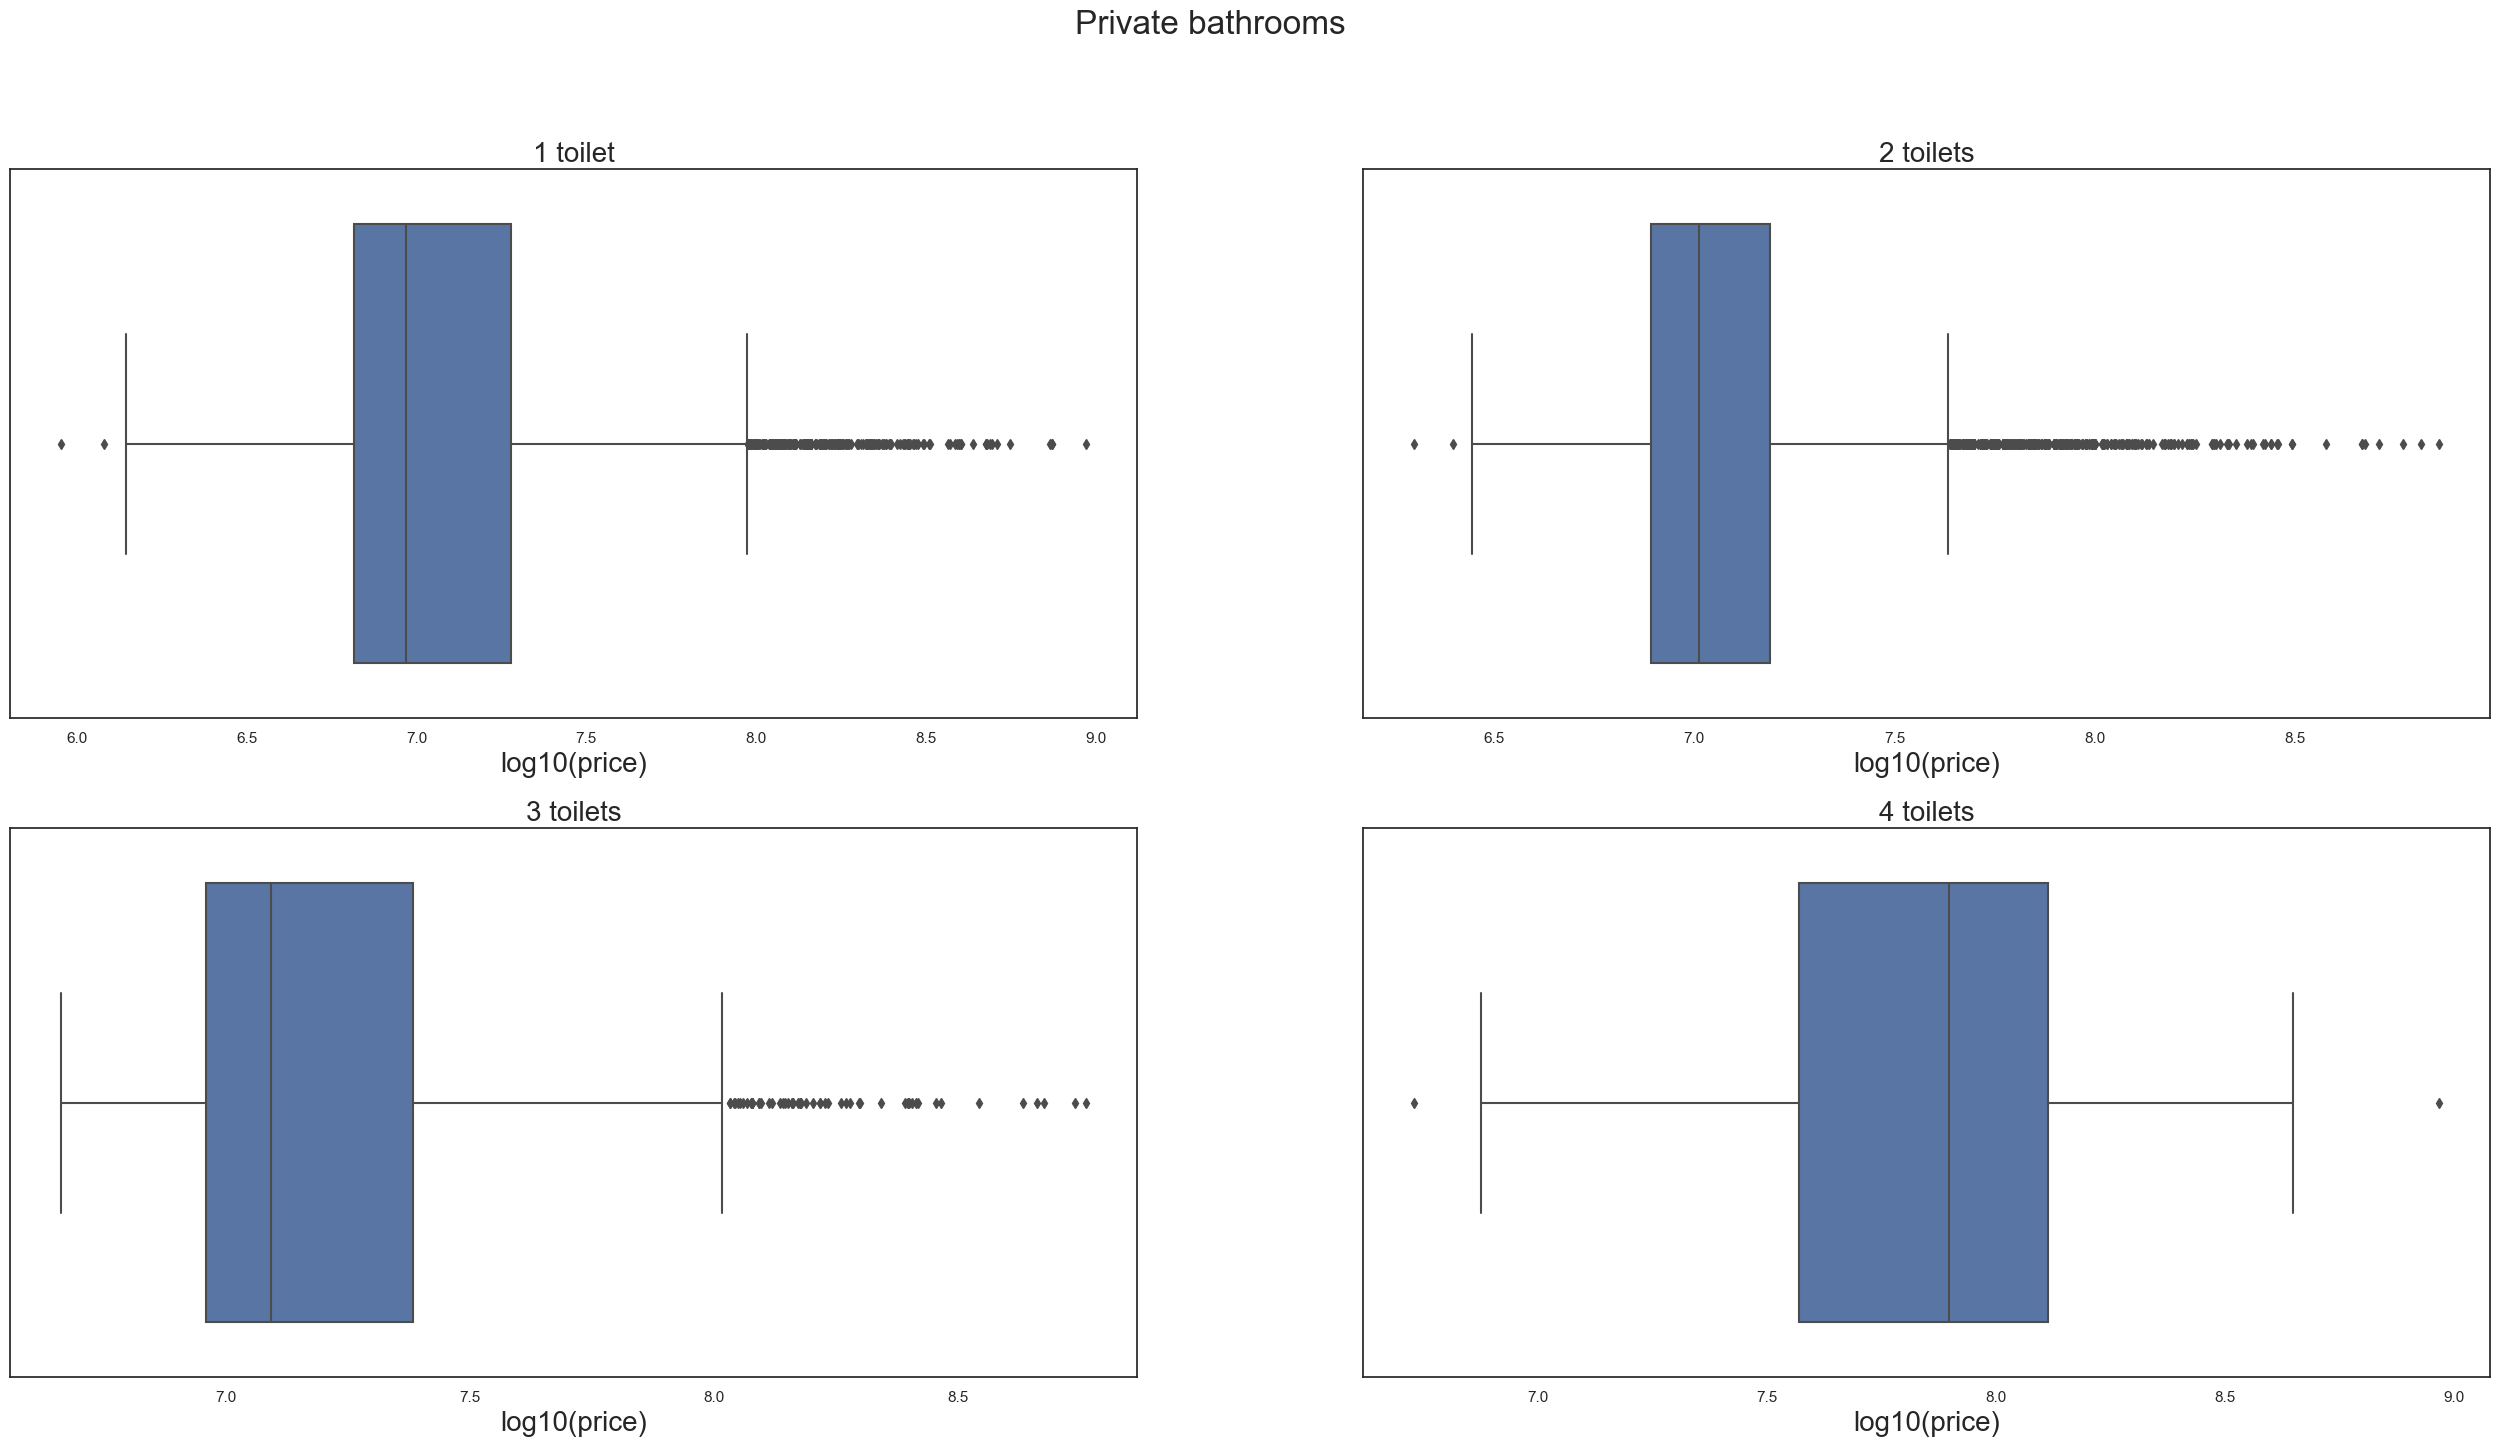

In [373]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(figsize=(32, 16), nrows=2, ncols=2, dpi=100)
sns.boxplot(x=df_train.loc[df_train['bathrooms_private'] == 0].price.rename('log10(price)'), ax=ax1)
ax1.set_title('1 toilet');
sns.boxplot(x=df_train.loc[df_train['bathrooms_private'] == 1].price.rename('log10(price)'), ax=ax2)
ax2.set_title('2 toilets');
sns.boxplot(x=df_train.loc[df_train['bathrooms_private'] == 2].price.rename('log10(price)'), ax=ax3)
ax3.set_title('3 toilets');
sns.boxplot(x=df_train.loc[df_train['bathrooms_private'] == 3].price.rename('log10(price)'), ax=ax4)
ax4.set_title('4 toilets');
fig.suptitle('Private bathrooms');


#### Windows
There are no apartments without windows (which makes sense). However, there are some apartments with court windows only. 

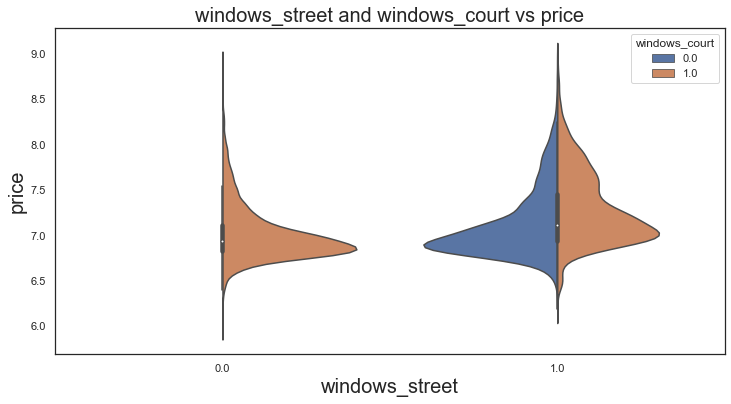

In [374]:
f, ax=plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot("windows_street","price", hue="windows_court", data=df_train, split=True, ax=ax)
ax.set_title('windows_street and windows_court vs price')
plt.show()

#### Condition
NaN values have approx. identical distribution as special_decign. Most apartments with euro_repear condition.

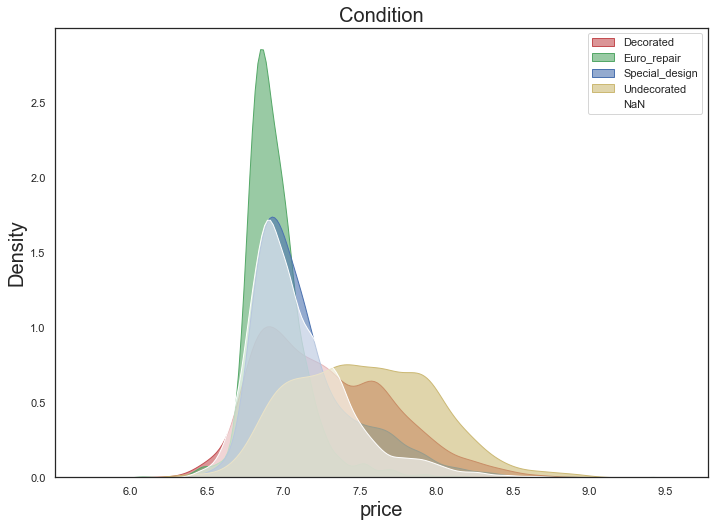

In [375]:
colors = ['r', 'g', 'b', 'y']
layouts =['Decorated', 'Euro_repair', 'Special_design', 'Undecorated']

#plt.xlim(6.3, 8.2)
for i, color in enumerate(colors):
    sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['condition'] == i].price, 
       fill=True, common_norm=False, palette="crest", color=color,
       alpha=.6, linewidth=1, label=layouts[i]
    ).set(title='Condition')
    
sns.kdeplot(
       data= df_train, x=df_train.loc[np.isnan(df_train['condition'])].price, 
       fill=True, common_norm=False, palette="crest", color='w',
       alpha=.6, linewidth=1, label='NaN')

plt.legend();

#### Phones
The distribution of phone values are approx. equal. Not much information gain here. 

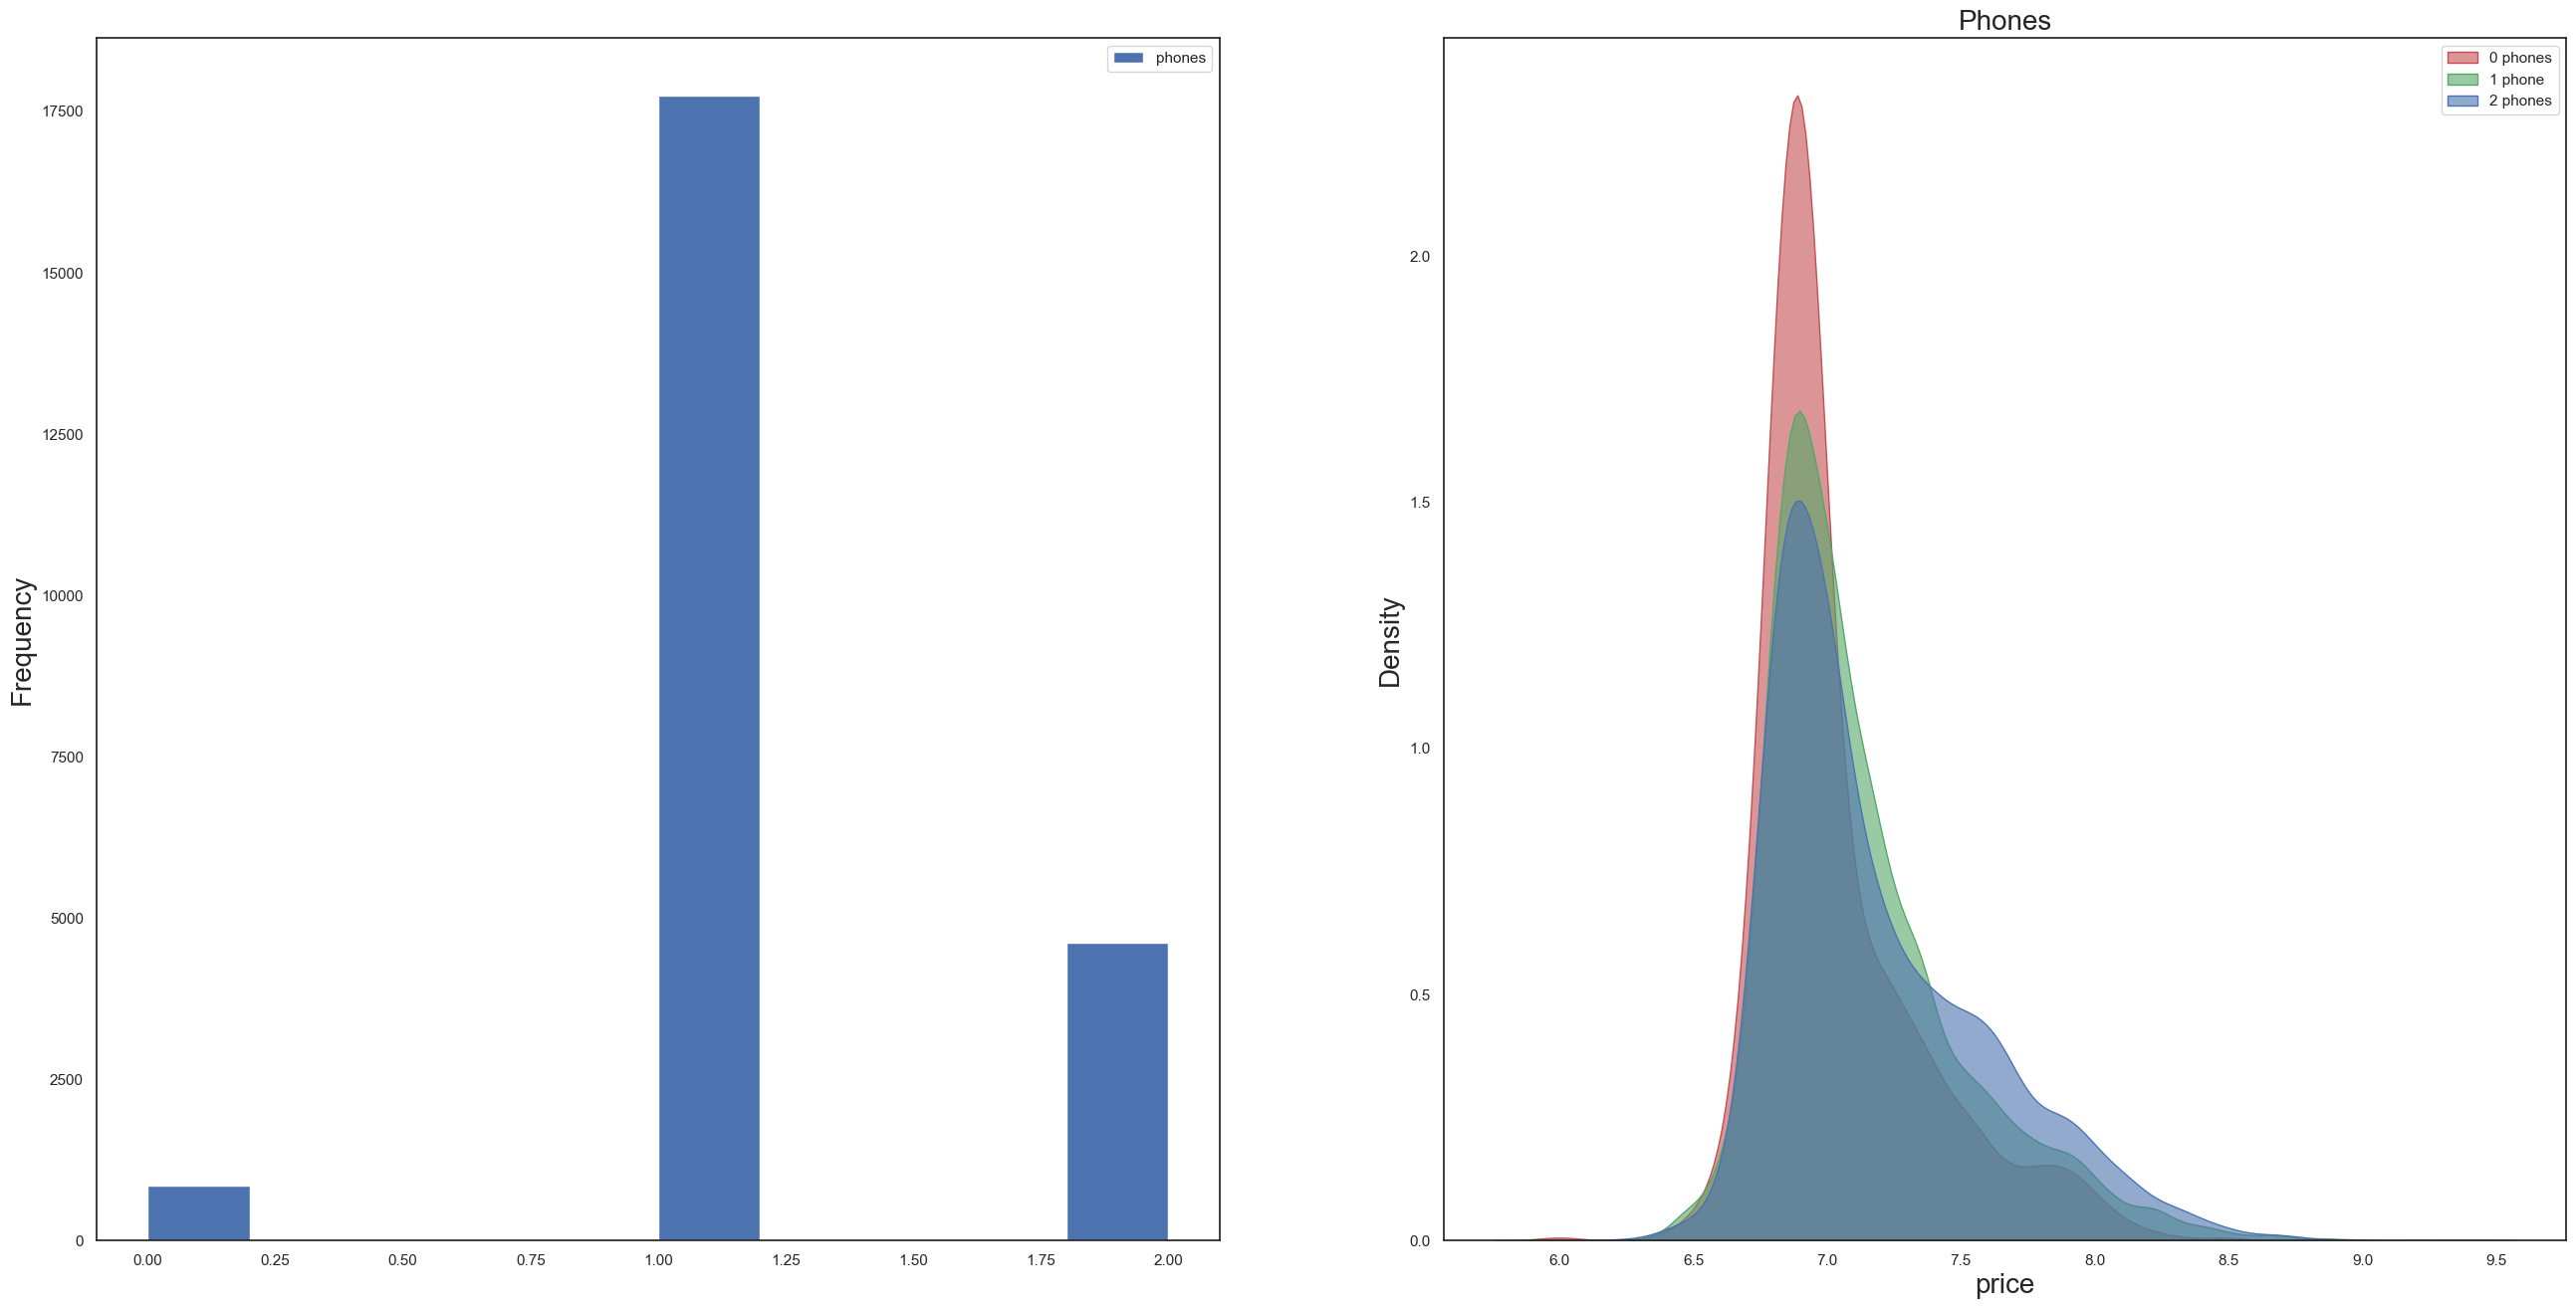

In [376]:
fig, (ax1, ax2) = plt.subplots(figsize=(32, 16), nrows=1, ncols=2, dpi=100)
df_train.plot.hist(y ='phones', ax=ax1);

colors = ['r', 'g', 'b', ]
layouts =['0 phones', '1 phone', '2 phones']

#plt.xlim(6.3, 8.2)
for i, color in enumerate(colors):
    sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['phones'] == i].price, 
       fill=True, common_norm=False, palette="crest", color=color,
       alpha=.6, linewidth=1, label=layouts[i], ax=ax2
    ).set(title='Phones')
    
    
plt.legend();

#### Floor and Stories
The ratio of number of floors vs stories in a building should maximum be one, i.e. an apartment cannot be in a floor higher than the total number of floors in the building. As plottet below, there are several apartments having a floor higher than stories which makes no sense. Interesting...

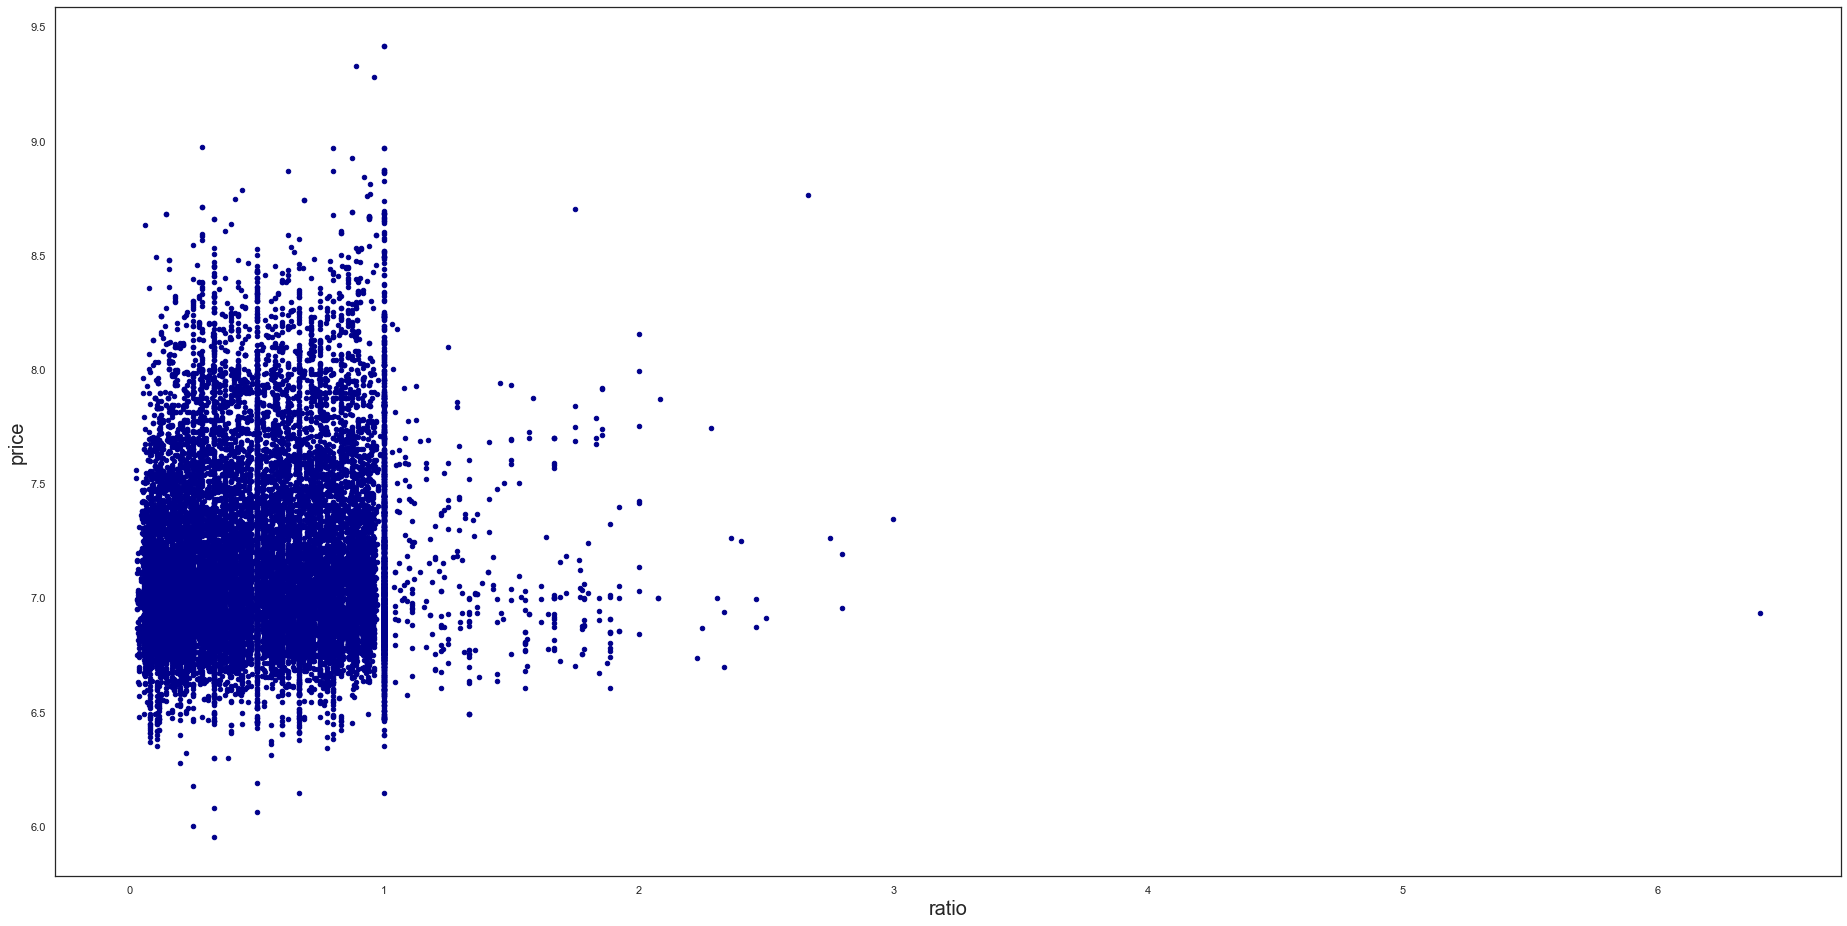

In [377]:
df_train['ratio'] = df_train['floor'] / df_train['stories']


fig, ax = plt.subplots(figsize=(32, 16))

df_train.plot.scatter(x='ratio', y='price', c='DarkBlue', ax=ax)

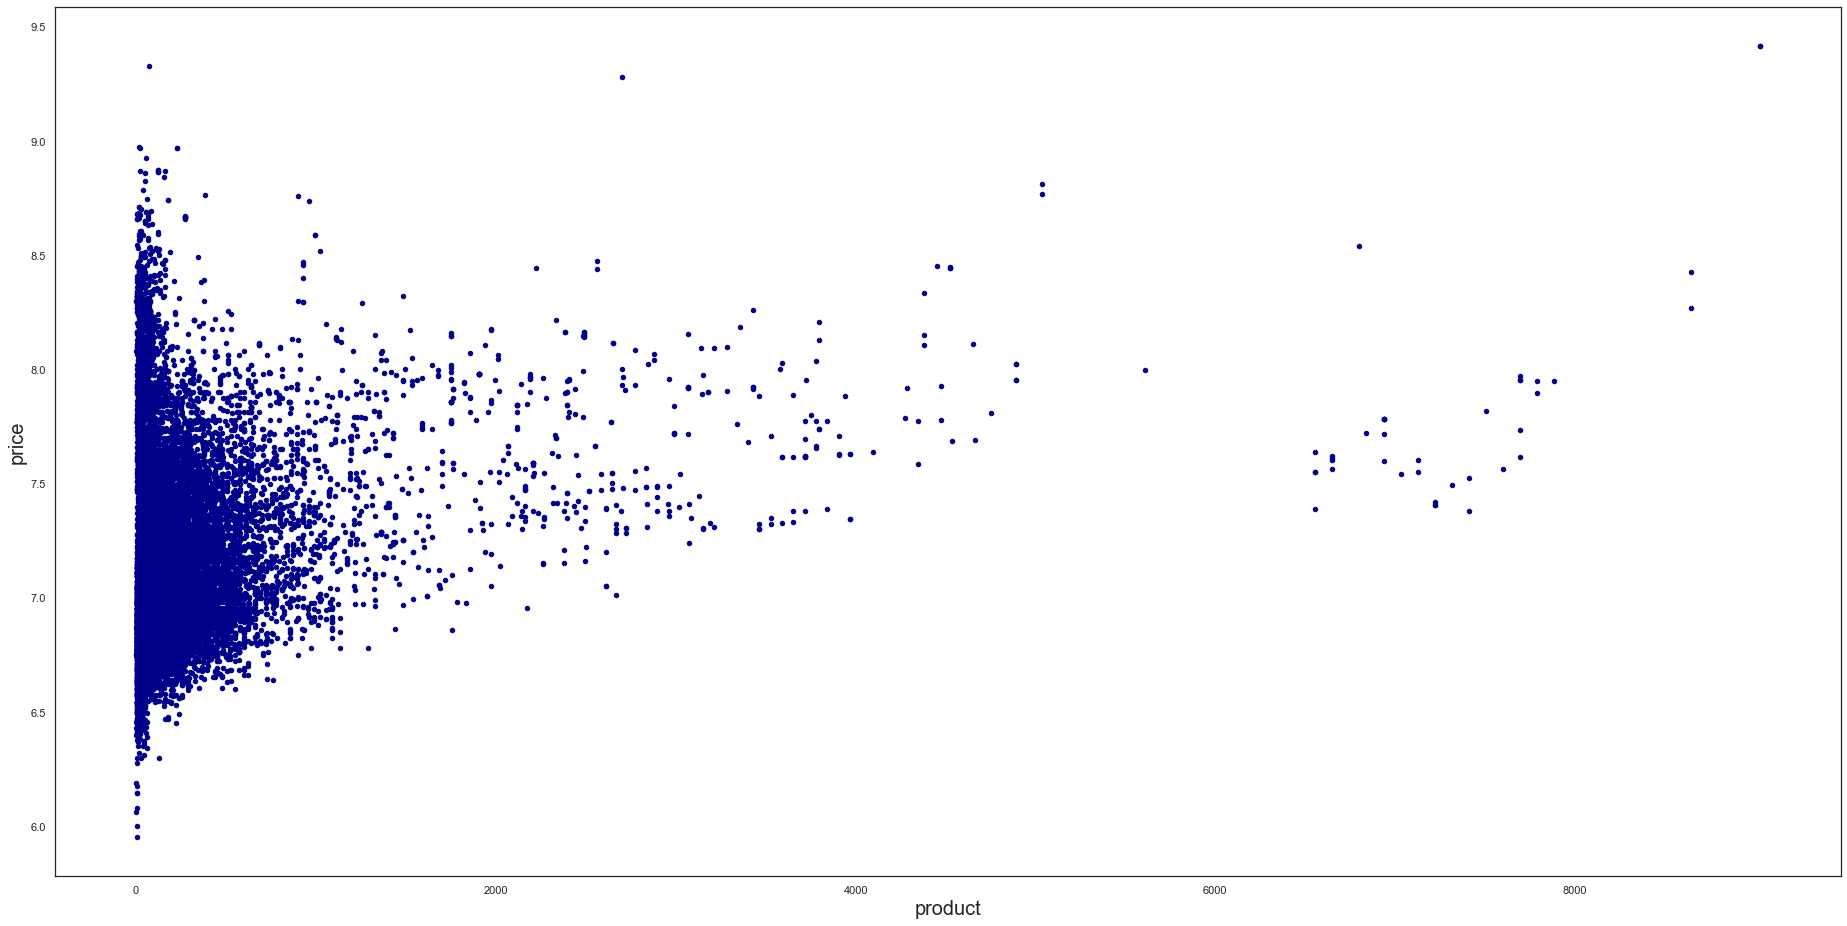

In [378]:
df_train['product'] = df_train['floor'] * df_train['stories']


fig, ax = plt.subplots(figsize=(32, 16))

df_train.plot.scatter(x='product', y='price', c='DarkBlue', ax=ax)

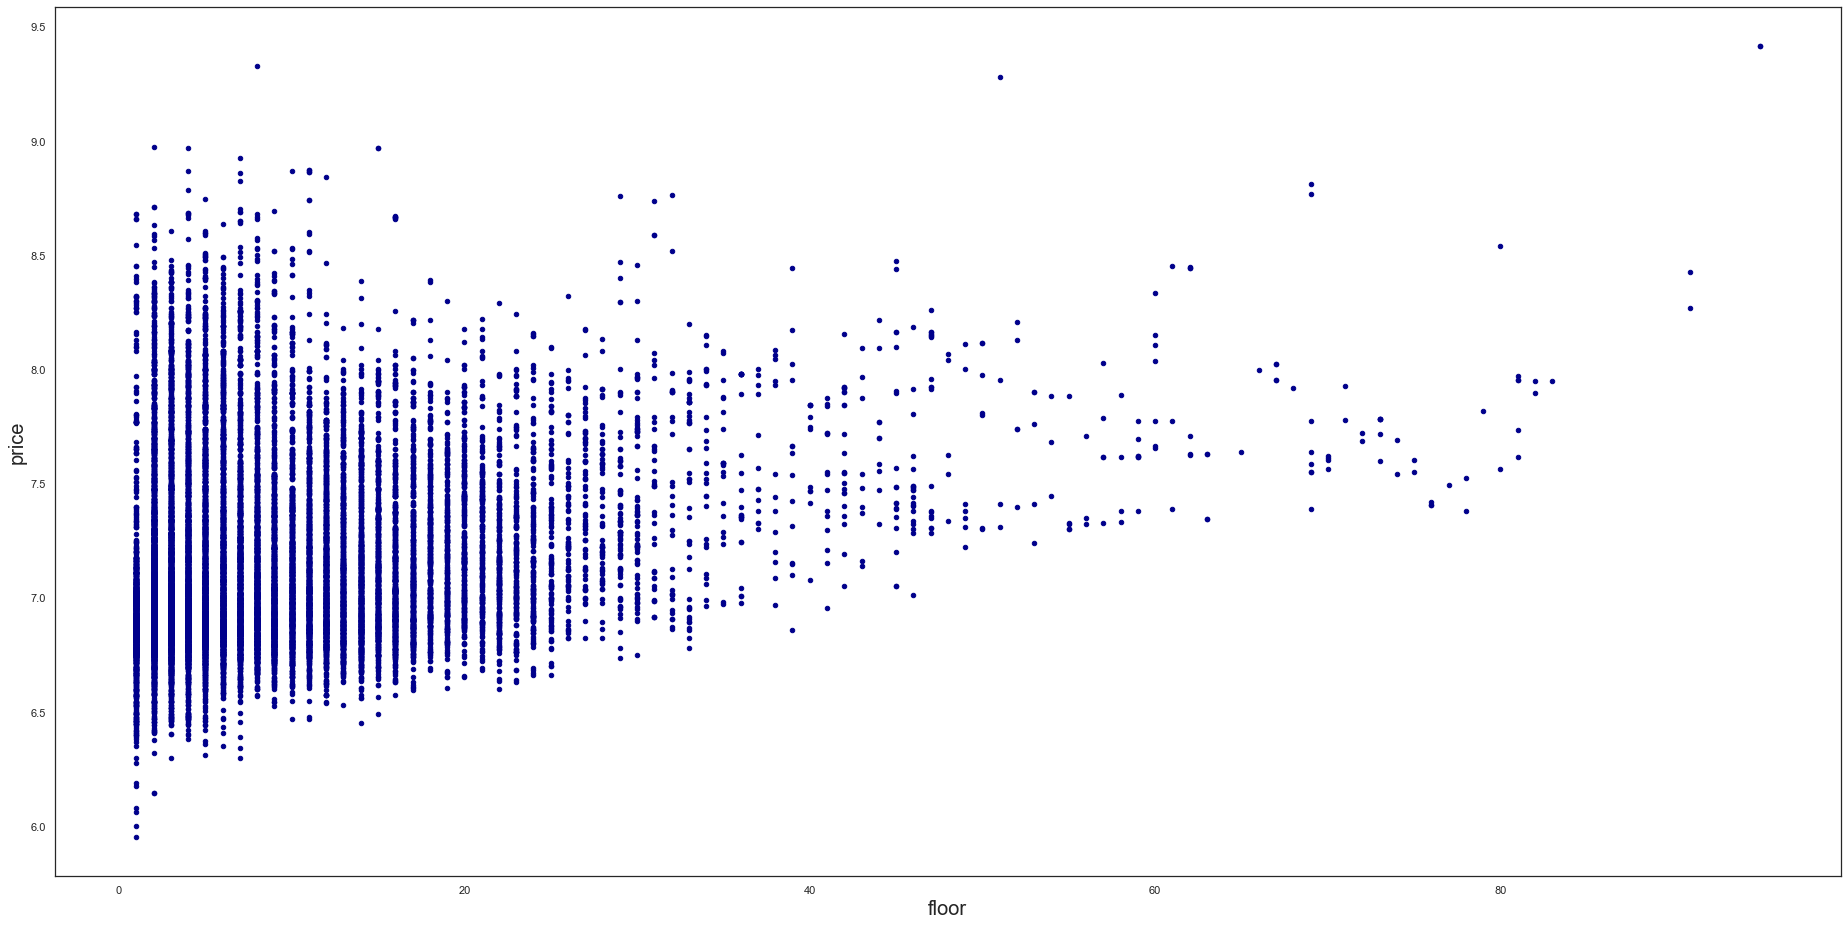

In [379]:
fig, ax = plt.subplots(figsize=(32, 16))

df_train.plot.scatter(x='floor', y='price', c='DarkBlue', ax=ax);


#### Balconies and Loggias
Distributions of NaN values look equal for baclonies and loggias. 

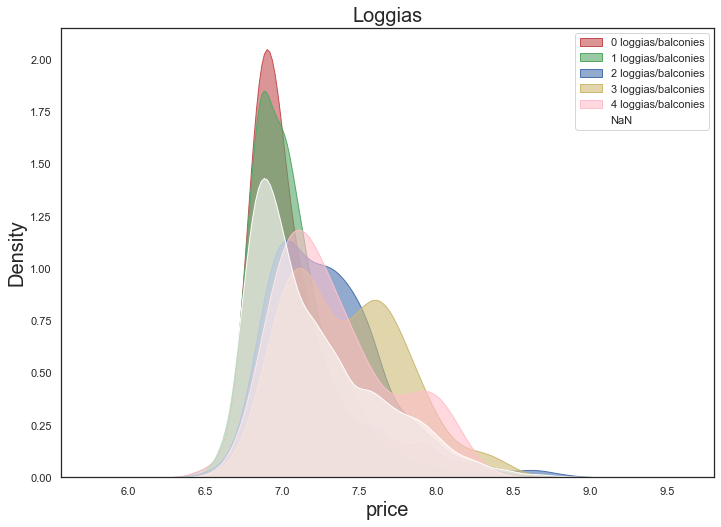

In [380]:
colors = ['r', 'g', 'b', 'y', 'pink']


for i, color in enumerate(colors):
    sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['loggias'] == i].price, 
       fill=True, common_norm=False, palette="crest", color=colors[i],
       alpha=.6, linewidth=1, label=f'{i} loggias/balconies'
    ).set(title='Loggias')
    
sns.kdeplot(
       data= df_train, x=df_train.loc[np.isnan(df_train['loggias'])].price, 
       fill=True, common_norm=False, palette="crest", color='w',
       alpha=.6, linewidth=1, label='NaN')
plt.legend();

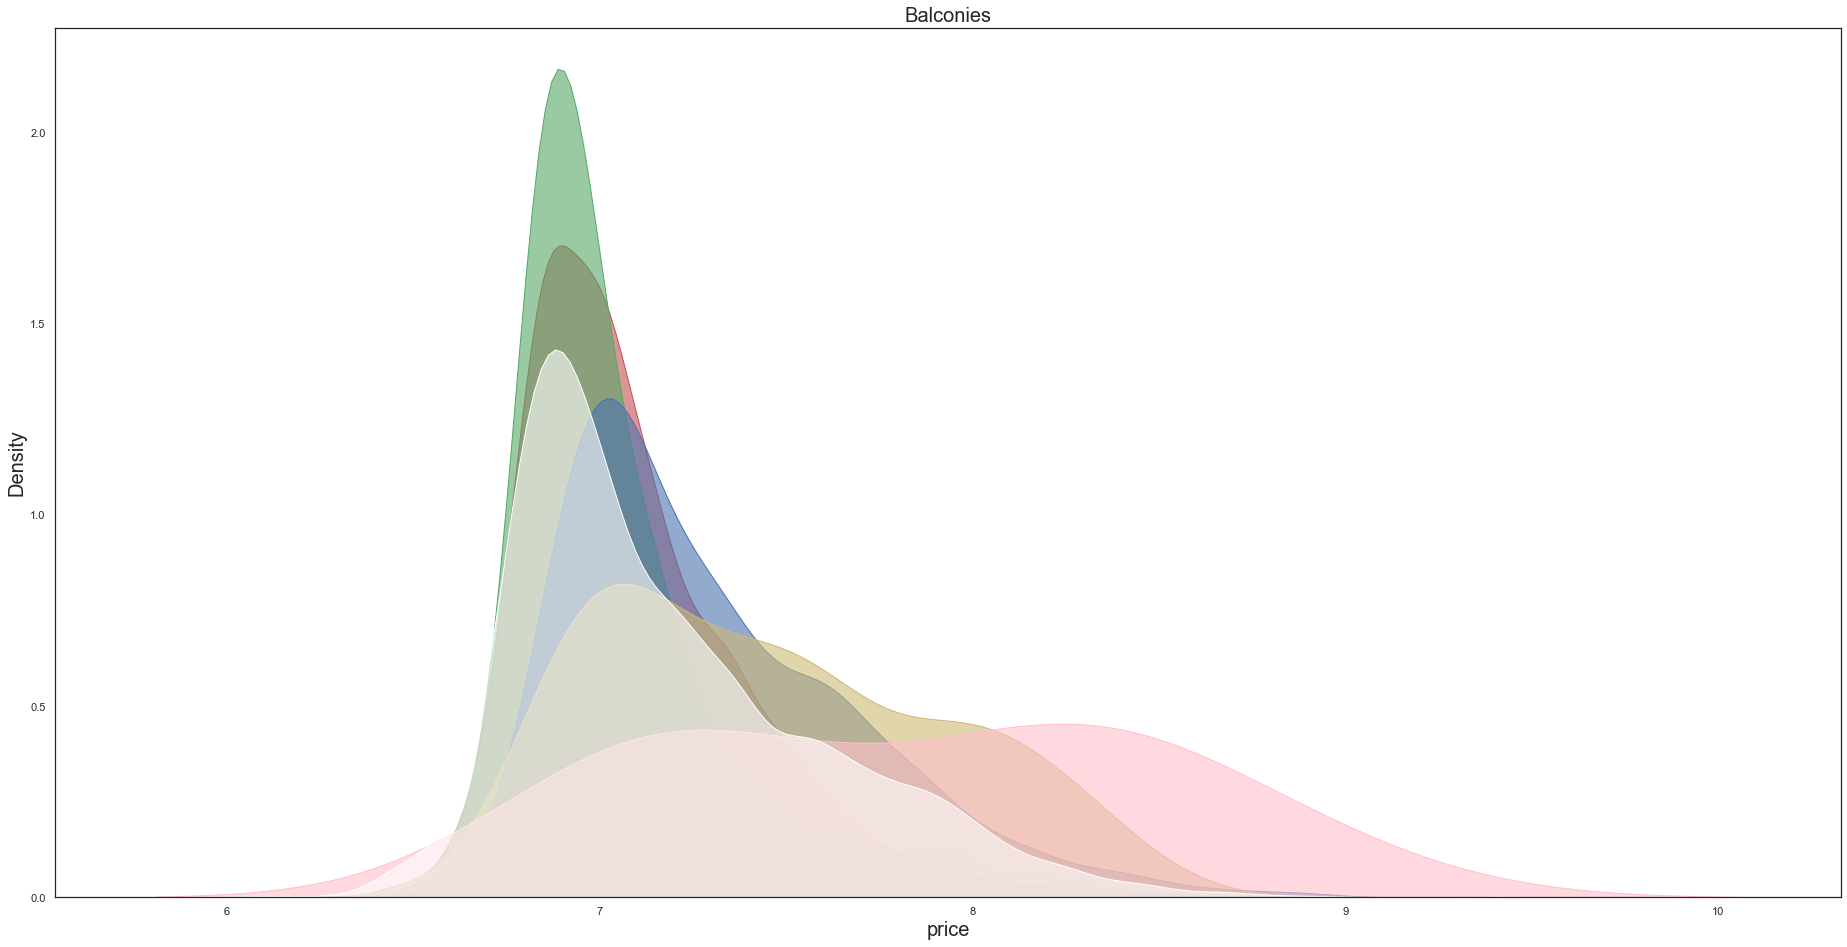

In [381]:
fig, ax = plt.subplots(figsize=(32, 16))
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
colors = ['r', 'g', 'b', 'y', 'pink']

label_patches = []
for i, color in enumerate(colors):
    sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['balconies'] == i].price, 
       fill=True, common_norm=False, palette="crest", color=colors[i],
       alpha=.6, linewidth=1, label=f'{i} number of balconies'
    ).set(title='Balconies')
    
sns.kdeplot(
       data= df_train, x=df_train.loc[np.isnan(df_train['balconies'])].price, 
       fill=True, common_norm=False, palette="crest", color='w',
       alpha=.6, linewidth=1, label='NaN')

### 2.3. Pairs and groups of features by apartment
[Go back to the "Table of contents"](#Table-of-contents)

#### Correlation plots 
Positive price correlation with area features, rooms and shared bathroom. High correlation between the area featurs and room feature (makes sense). 

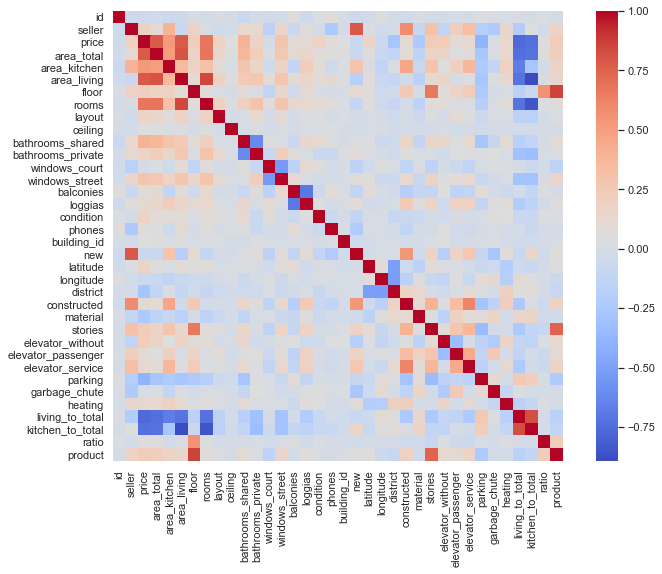

In [382]:
sns.heatmap(df_train.corr(),  square=True, cmap='coolwarm');

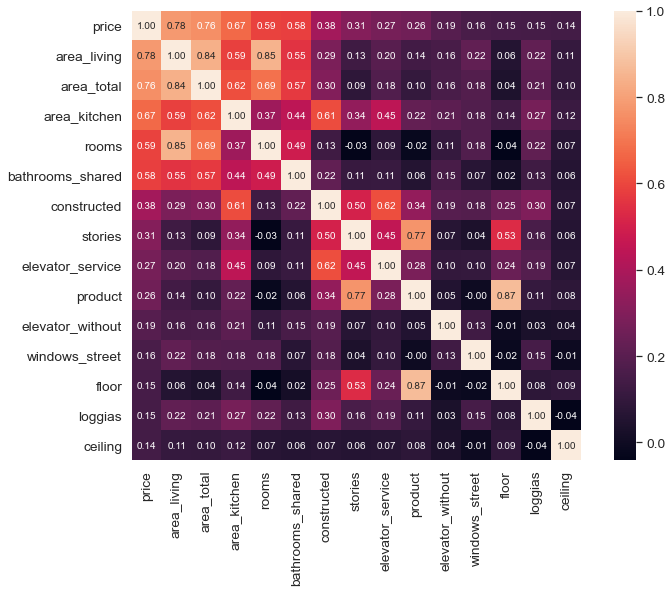

In [383]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
cols = df_train.dropna().corr().nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_train.dropna()[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);

#### Overview of feature scatterplots
The plots verify that area values increase with price. So does year floor. These features also correlates positively internally.


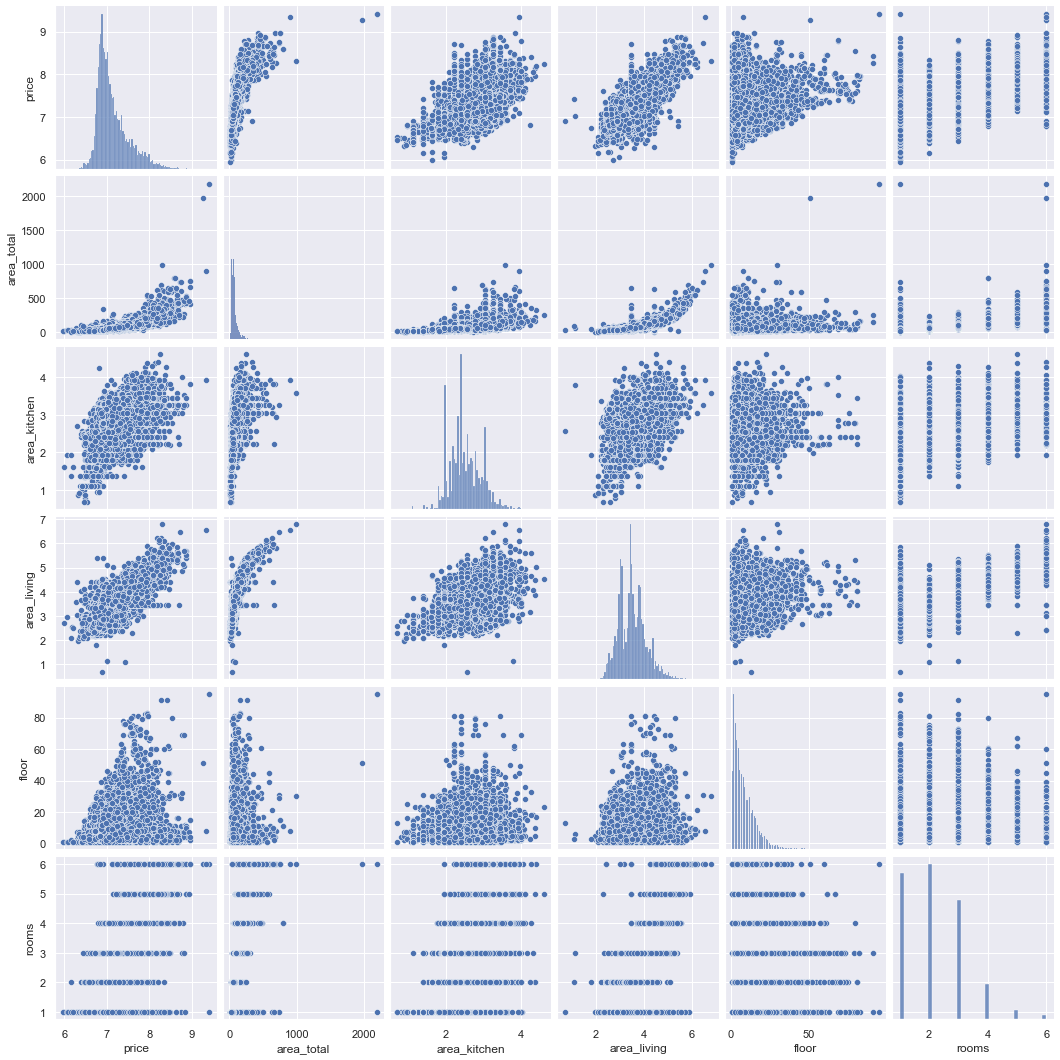

In [384]:
#scatterplot
sns.set()
cols = ['price', 'area_total','area_kitchen', 'area_living', 'floor', 'rooms']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

### 2.4. Individual feature analysis by building
[Go back to the "Table of contents"](#Table-of-contents)

#### Assign price value to buildings dataset 
In order to provide analysis of building features agains price, a price per building value is aggregated based on the mean price of the apartments in the building.

In [385]:
df_train['price'] = df_train['price'].apply(lambda x: np.log10(x));

#buildings with price:
df_buildings = df_train.groupby(['building_id'], as_index=False)['price'].mean()
buildings_train = pd.merge(df_buildings, data.buildings_train.set_index('id'), how='left', left_on='building_id', right_on='id', right_index=True)

#### District

District 0 has the most expencive apartments, followed by 7 and 8. 0 and 7 have few outliers despite the high number of buildings in the district.

Number of values: 23285
Number of NaN values: 130


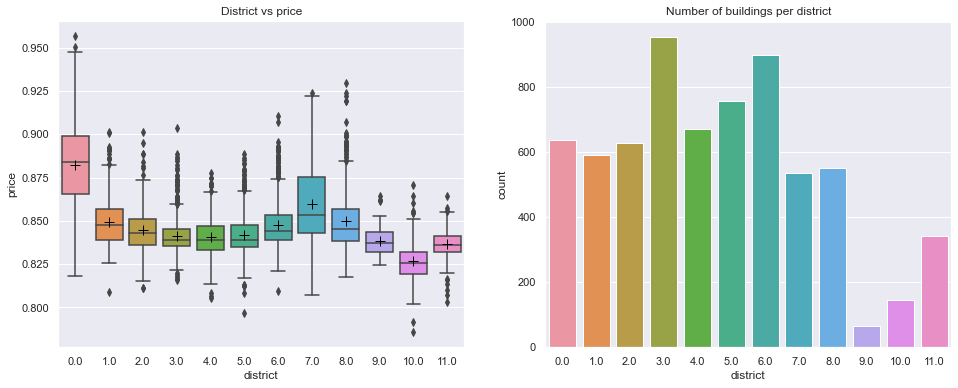

In [386]:
#colors = ['r', 'g', 'b', 'y']
#district = ['Central', 'East', 'North', 'North-East', 'North-west', 'Novomskovsk', 'South', 'South-East', 'South-West', 'Troitsk', 'West', 'Zelenograd']

sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )
f,ax=plt.subplots(1, 2, figsize=(16, 6))
ax[0].set_title('District vs price')
ax[1].set_title('Number of buildings per district')
#sns.barplot(x="district", y="price", data=buildings_train, ax=ax[0], estimator=np.mean)
sns.countplot('district', data=buildings_train, ax=ax[1]);

sns.boxplot(x="district", y="price",
                    data=buildings_train, ax=ax[0], showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})

print("Number of values:", len(df_train['district']));
print("Number of NaN values:", df_train['district'].isnull().sum());

#### Material

Material 2, 5, 6 with less outliers compared to the others. However, few buildings of these materials. 

material
0.0    1226
1.0       4
2.0    1312
3.0    2384
4.0     679
5.0      19
6.0       2
Name: building_id, dtype: int64

Number of values: 23285
Number of NaN values: 3972
Ratio: 0.17058191969078806


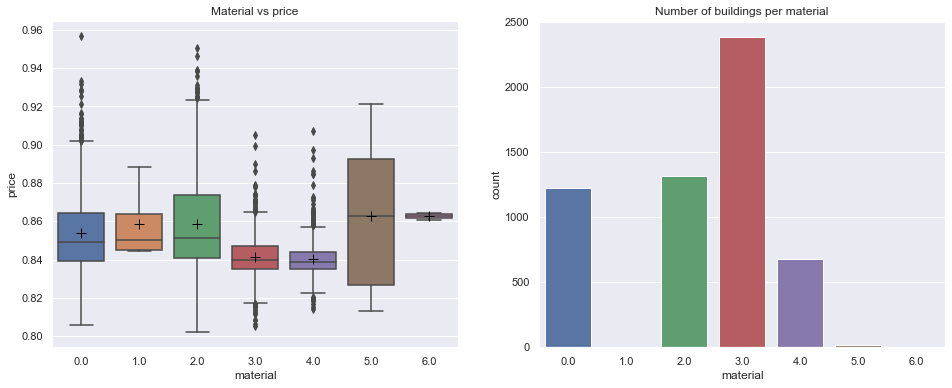

In [387]:
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )
f,ax=plt.subplots(1, 2, figsize=(16, 6))
ax[0].set_title('Material vs price')
ax[1].set_title('Number of buildings per material')
sns.boxplot(x="material", y="price",
                    data=buildings_train, ax=ax[0], showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})
sns.countplot('material', data=buildings_train, ax=ax[1])

display(buildings_train.groupby('material')['building_id'].count())

print("Number of values:", len(df_train['material']));
print("Number of NaN values:", df_train['material'].isna().sum());
print("Ratio:", df_train['material'].isnull().sum()/len(df_train['material']));

#### Elevator

Quite same elevator distributions regardless of passenger/service. 

When building is old: then there is quite the same distribution of price regardless of elevator. Some tendency of higher price. 

When building is new: the price in buildings without elevator is more spread, compared to price in buildings with elevator. Easier to predict for distributions with sharp peaks. 

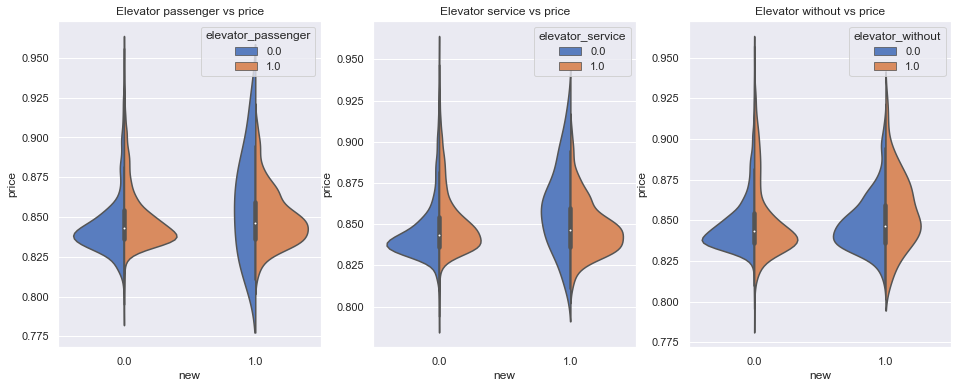

In [388]:
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )
f,ax=plt.subplots(1, 3, figsize=(16, 6))
ax[0].set_title('Elevator passenger vs price')
ax[1].set_title('Elevator service vs price')
ax[2].set_title('Elevator without vs price')

sns.violinplot(x="new", y="price", hue="elevator_passenger",
                    data=buildings_train, palette="muted", split=True, ax=ax[0])
sns.violinplot(x="new", y="price", hue="elevator_service",
                    data=buildings_train, palette="muted", split=True, ax=ax[1])
sns.violinplot(x="new", y="price", hue="elevator_without",
                    data=buildings_train, palette="muted", split=True, ax=ax[2])


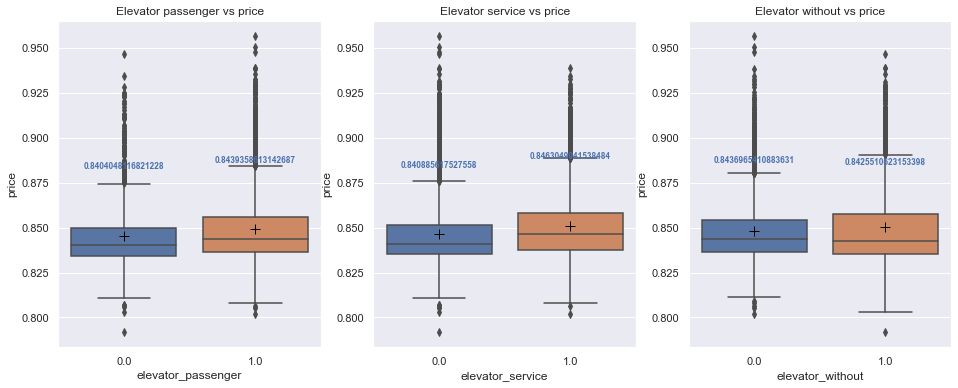

In [389]:
f,ax=plt.subplots(1, 3, figsize=(16, 6))
ax[0].set_title('Elevator passenger vs price')
ax[1].set_title('Elevator service vs price')
ax[2].set_title('Elevator without vs price')

box_plot0 = sns.boxplot(x="elevator_passenger", y="price", data=buildings_train, ax=ax[0], showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})

medians = buildings_train.groupby(['elevator_passenger'])['price'].median()
vertical_offset = buildings_train['price'].median() * 0.05 # offset from median for display

for xtick in box_plot0.get_xticks():
    box_plot0.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')

box_plot1 = sns.boxplot(x="elevator_service", y="price", data=buildings_train, ax=ax[1], showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})

medians = buildings_train.groupby(['elevator_service'])['price'].median()
vertical_offset = buildings_train['price'].median() * 0.05 # offset from median for display

for xtick in box_plot1.get_xticks():
    box_plot1.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')

box_plot2 = sns.boxplot(x="elevator_without", y="price", data=buildings_train, ax=ax[2], showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})

medians = buildings_train.groupby(['elevator_without'])['price'].median()
vertical_offset = buildings_train['price'].median() * 0.05 # offset from median for display

for xtick in box_plot2.get_xticks():
    box_plot2.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')

No handles with labels found to put in legend.


       elevator_without  elevator_passenger  elevator_service
171                 NaN                 NaN               NaN
904                 NaN                 NaN               NaN
905                 NaN                 NaN               NaN
906                 NaN                 NaN               NaN
907                 NaN                 NaN               NaN
...                 ...                 ...               ...
22988               NaN                 NaN               NaN
23043               NaN                 NaN               NaN
23176               NaN                 NaN               NaN
23250               NaN                 NaN               NaN
23284               NaN                 NaN               NaN

[357 rows x 3 columns]


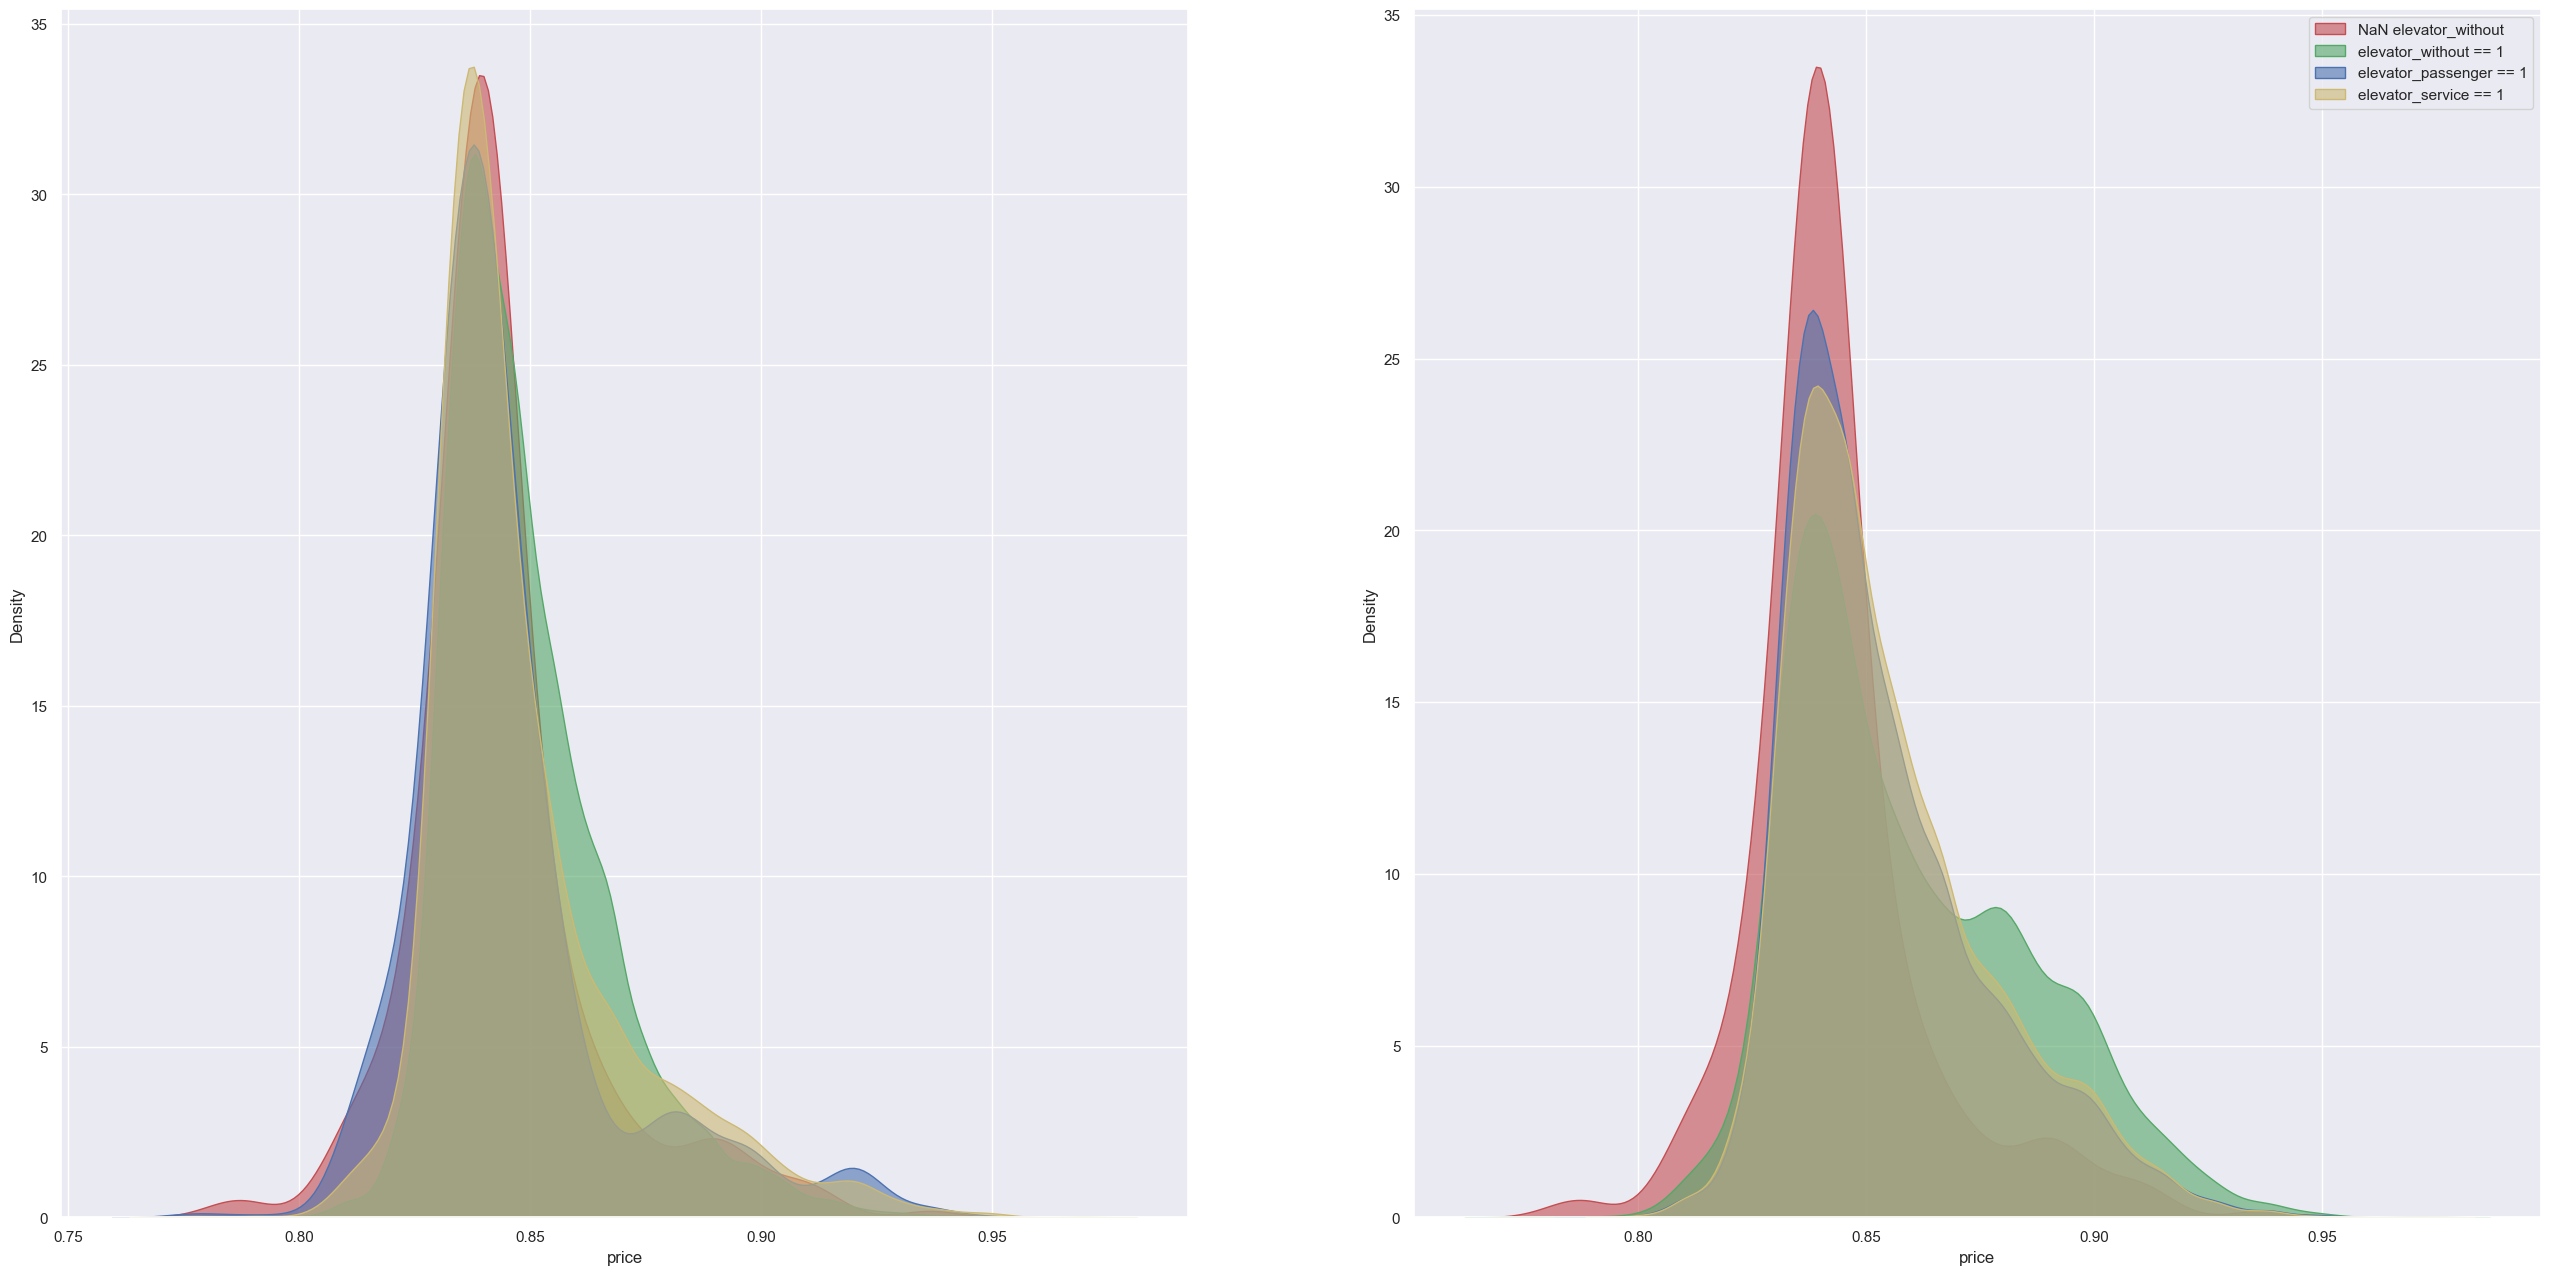

In [390]:
fig, (ax1, ax2) = plt.subplots(figsize=(32, 16), nrows=1, ncols=2, dpi=100)
sns.kdeplot(
       data= df_train, x=df_train.loc[np.isnan(df_train['elevator_without'])].price, 
       fill=True, common_norm=False, palette="crest", color='r',
       alpha=.6, linewidth=1, label='NaN elevator_without', ax = ax1)

sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['elevator_without'] == 0].price, 
       fill=True, common_norm=False, palette="crest", color='g',
       alpha=.6, linewidth=1, label='elevator_without == 0',ax = ax1
)

sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['elevator_passenger'] == 0].price, 
       fill=True, common_norm=False, palette="crest", color='b',
       alpha=.6, linewidth=1, label='elevator_passenger == 0',ax = ax1
)

sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['elevator_service'] == 0].price, 
       fill=True, common_norm=False, palette="crest", color='y',
       alpha=.6, linewidth=1, label='elevator_service == 0',ax = ax1
)
plt.legend();

sns.kdeplot(
       data= df_train, x=df_train.loc[np.isnan(df_train['elevator_without'])].price, 
       fill=True, common_norm=False, palette="crest", color='r',
       alpha=.6, linewidth=1, label='NaN elevator_without', ax = ax2)

sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['elevator_without'] == 1].price, 
       fill=True, common_norm=False, palette="crest", color='g',
       alpha=.6, linewidth=1, label='elevator_without == 1', ax = ax2
)

sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['elevator_passenger'] == 1].price, 
       fill=True, common_norm=False, palette="crest", color='b',
       alpha=.6, linewidth=1, label='elevator_passenger == 1', ax = ax2
)

sns.kdeplot(
       data= df_train, x=df_train.loc[df_train['elevator_service'] == 1].price, 
       fill=True, common_norm=False, palette="crest", color='y',
       alpha=.6, linewidth=1, label='elevator_service == 1', ax = ax2
)



plt.legend();
print(df_train.loc[np.isnan(df_train['elevator_service'])][['elevator_without','elevator_passenger' ,'elevator_service']])

#### Elevator (service/private) vs elevatore_without

***NB!*** There are True values of elevator_without that also have True values of elevator_service og elevator_passenger. This makes no sense:

7443


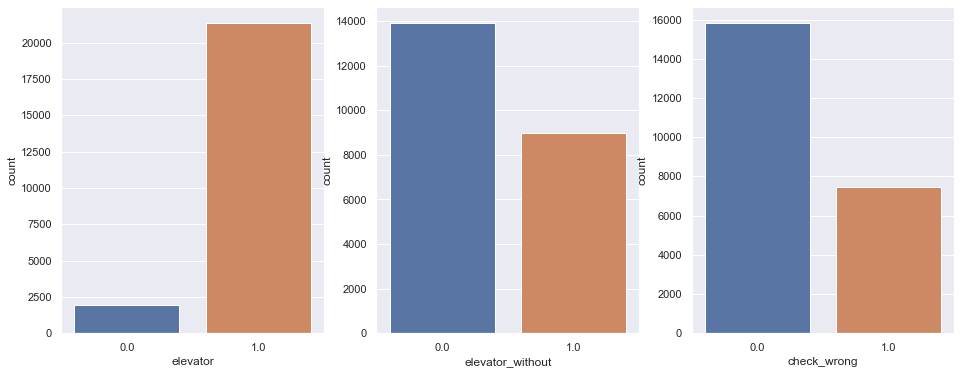

In [391]:
df_train['elevator'] = df_train.apply(lambda x : 1.0 if x['elevator_passenger'] == 1.0 or x['elevator_service'] == 1.0 else 0.0, axis = 1)

df_train['check_wrong'] = df_train.apply(lambda x : 1.0 if x['elevator'] == 1.0 and x['elevator_without'] == 1.0 else 0.0, axis = 1)
true_count = (df_train['check_wrong']).value_counts()[1.0]

print(true_count)

f,ax=plt.subplots(1, 3, figsize=(16, 6))

sns.countplot('elevator', data=df_train, ax=ax[0]);
sns.countplot('elevator_without', data=df_train, ax=ax[1]);
sns.countplot('check_wrong', data=df_train, ax=ax[2]);

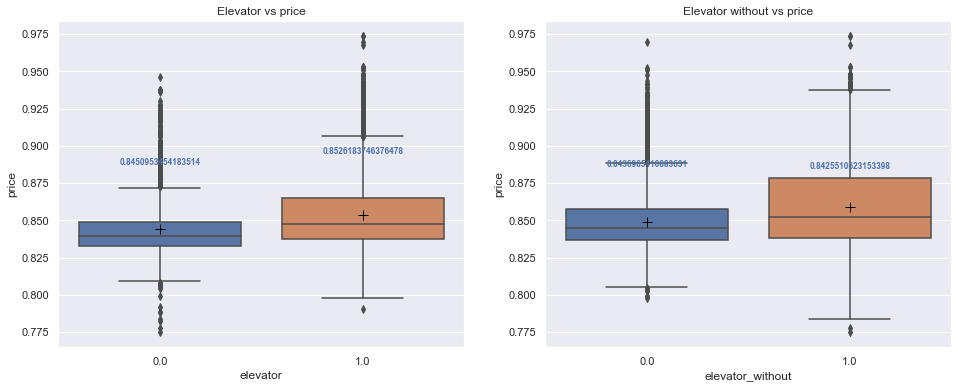

In [392]:
f,ax=plt.subplots(1, 2, figsize=(16, 6))
ax[0].set_title('Elevator vs price')
ax[1].set_title('Elevator without vs price')

box_plot0 = sns.boxplot(x="elevator", y="price", data=df_train, ax=ax[0], showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})

medians = df_train.groupby(['elevator_without'])['price'].median()
vertical_offset = buildings_train['price'].median() * 0.05 # offset from median for display

for xtick in box_plot0.get_xticks():
    box_plot0.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')
    
box_plot2 = sns.boxplot(x="elevator_without", y="price", data=df_train, ax=ax[1], showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})

medians = buildings_train.groupby(['elevator_without'])['price'].median()
vertical_offset = df_train['price'].median() * 0.05 # offset from median for display

for xtick in box_plot2.get_xticks():
    box_plot2.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')

#### Parking

The buildings with parking at ground has an overall higher price compared to underground, as well as more specific.

Parking and garbage have almost 50% NaN values. To be ignored?

parking
0.0     749
1.0    2113
2.0      60
Name: building_id, dtype: int64

Number of all values: 6791
Number of NaN values: 3869
Ratio: 0.5697246355470476


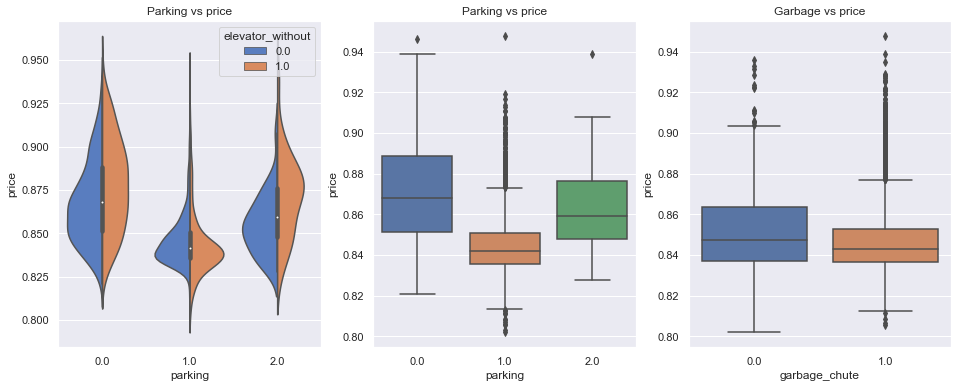

In [393]:
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )
f,ax=plt.subplots(1, 3, figsize=(16, 6))
ax[0].set_title('Parking vs price')
ax[1].set_title('Parking vs price')
ax[2].set_title('Garbage vs price')

sns.violinplot(x="parking", y="price", hue="elevator_without", data=buildings_train, palette="muted", split=True, ax=ax[0])

sns.boxplot(x="parking", y="price",
                    data=buildings_train, ax=ax[1])

sns.boxplot(x="garbage_chute", y="price",
                    data=buildings_train, ax=ax[2])


display(buildings_train.groupby('parking')['building_id'].count())

print("Number of all values:", len(buildings_train['parking']));
print("Number of NaN values:", buildings_train['parking'].isnull().sum());
print("Ratio:", buildings_train['parking'].isnull().sum()/len(buildings_train['parking']));



#0: ground, 1: underground 2: multilevel

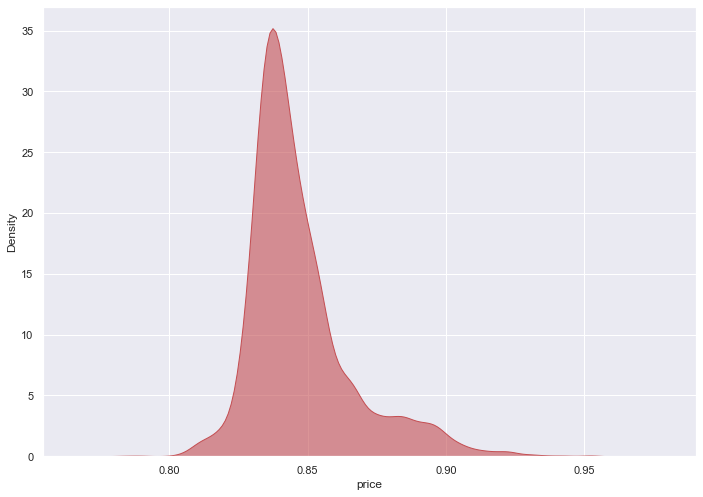

In [394]:
sns.kdeplot(
       data= df_train, x=df_train.loc[np.isnan(df_train['parking'])].price, 
       fill=True, common_norm=False, palette="crest", color='r',
       alpha=.6, linewidth=1, label='NaN');

#### Year of construction

Scatter plot shows no clear correlatation between construction year and price. However, shows a smal tendency of increasing price with increasing number of floors in the building in addition to more high buildings built after year 2000. 

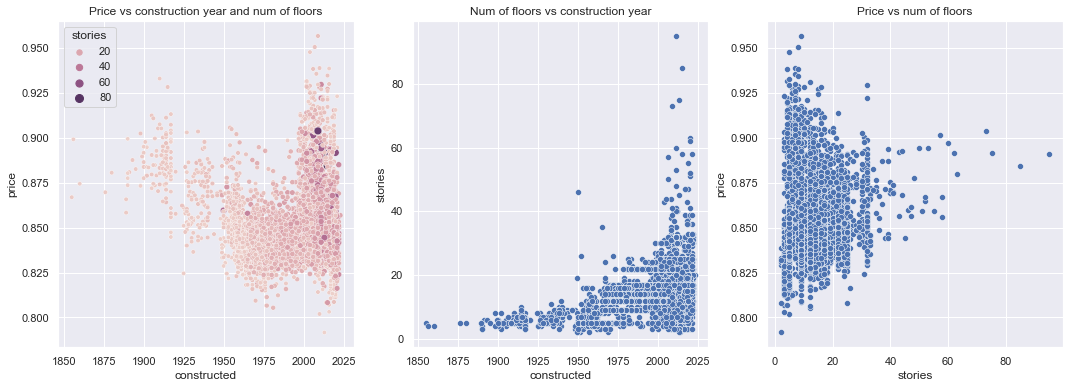

In [395]:
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )
f,ax=plt.subplots(1, 3, figsize=(18, 6))


ax[0].set_title('Price vs construction year and num of floors')
ax[1].set_title('Num of floors vs construction year')
ax[2].set_title('Price vs num of floors')


sns.scatterplot(x="constructed", y="price", hue= "stories", size="stories", data=buildings_train[buildings_train['constructed'].notna()], ax=ax[0])
sns.scatterplot(x="constructed", y="stories", data=buildings_train[buildings_train['constructed'].notna()], ax=ax[1])
#sns.scatterplot(x="constructed", y="stories", data=df_train[df_train['constructed'].notna()], ax=ax[1])
sns.scatterplot(x="stories", y="price", data=buildings_train[buildings_train['constructed'].notna()], ax=ax[2])


    


#### New building

ALmost all buildings are defined as old buildings, and the avg price (by meadian) price does not differ a lot between new and old buildings. However, the box plots indicate that there are many more outliers within the old buildings compared to the new ones (mey be explained by the many more labels), and the max/ min price is a lot higher/lower respectively.

Number of NaN values: 264


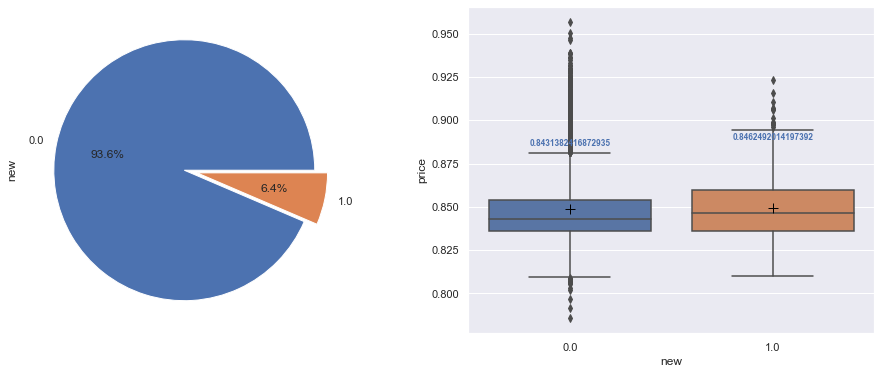

In [396]:
print("Number of NaN values:", df_train['new'].isnull().sum());

#fig, (ax1, ax2) = plt.subplots(figsize=(32, 16), nrows=1, ncols=2, dpi=100)
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )
f, ax = plt.subplots(1, 2, figsize=(16,6))
buildings_train['new'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=False)

box_plot = sns.boxplot(x="new", y="price", data=buildings_train, showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})

medians = buildings_train.groupby(['new'])['price'].median()
vertical_offset = buildings_train['price'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')

#### Garbage and heating: 
Garbage correlates positively with elevator_passenger. Almost all garbage_chute values are True when elevator_passenger is true.

In [397]:
print('Garbage')
print("Number of values:", len(df_train['garbage_chute']));
print("Number of NaN values:", df_train['garbage_chute'].isnull().sum());
print("Ratio:", df_train['garbage_chute'].isnull().sum()/len(df_train['garbage_chute']));

print('\n')

print('Heating')
print("Number of values:", len(df_train['heating']));
print("Number of NaN values:", df_train['heating'].isnull().sum());
print("Ratio:", df_train['heating'].isnull().sum()/len(df_train['heating']));

Garbage
Number of values: 23285
Number of NaN values: 8811
Ratio: 0.3783981103714838


Heating
Number of values: 23285
Number of NaN values: 8161
Ratio: 0.35048314365471334


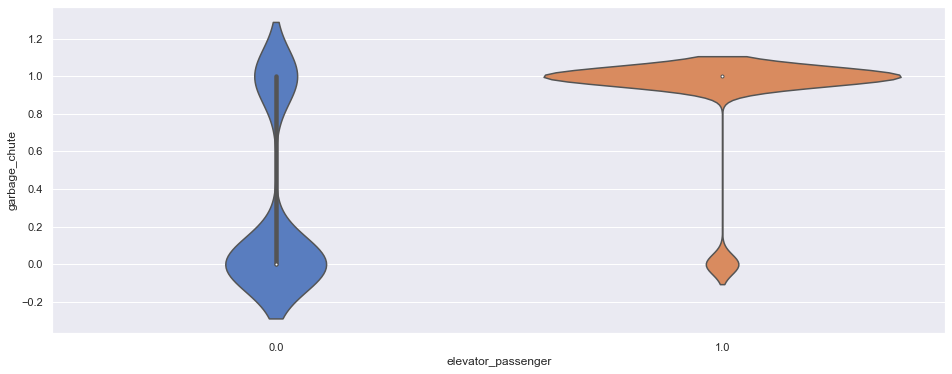

In [398]:
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )
f, ax = plt.subplots(1, 1, figsize=(16,6))

sns.violinplot(x="elevator_passenger", y="garbage_chute",
                    data=buildings_train, palette="muted", split=True, ax=ax)

### 2.5. Pairs and groups of features by building
[Go back to the "Table of contents"](#Table-of-contents)

#### Correlation plots
Year of construction is correalated with elevator service and stories (floors). The higher construction year the higher the num of stories. Price correlates highly negatively with parking. 

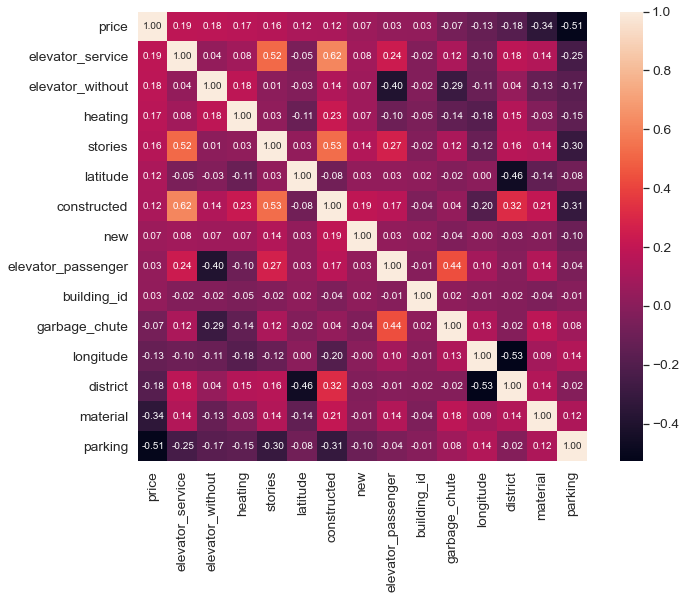

In [399]:
k = 22 #number of variables for heatmap
cols = buildings_train.dropna().corr().nlargest(k, 'price')['price'].index
cm = np.corrcoef(buildings_train.dropna()[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);

#### Constructed and stories
Year of construction correlates with number of floors in the building. The newer the building, the moore floors. 

Number of NaN values: 479
Values for attribute stories:62

Values for attribute constructed:129

Min/max speed, stories: 1.0 / 95.0


stories
constructed           
1855.0        5.000000
1856.0        4.000000
1860.0        4.000000
1876.0        5.000000
1880.0        5.000000
...                ...
2019.0       16.418367
2020.0       18.108333
2021.0       19.495146
2022.0       20.666667
2023.0       20.000000

[128 rows x 1 columns]

<class 'pandas.core.frame.DataFrame'>
Float64Index: 128 entries, 1855.0 to 2023.0
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stories  128 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


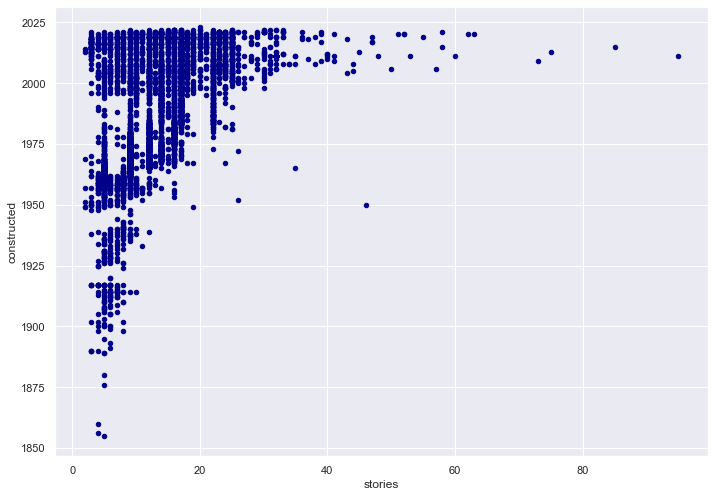

In [400]:
print("Number of NaN values:", buildings_train['constructed'].isnull().sum()),;
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)} )

print('Values for attribute stories:' + str(len(list(buildings_train['stories'].unique()))) + "\n")
print('Values for attribute constructed:' + str(len(list(buildings_train['constructed'].unique()))) + "\n")

print("Min/max speed, stories: " + str(buildings_train['stories'].min()) + " / " + str(buildings_train['stories'].max()))

storcon = buildings_train.groupby('constructed')['stories'].agg('mean').to_frame()
check = buildings_train[buildings_train['stories'] == 1]
display(storcon)

storcon.info()


buildings_train.plot.scatter(x='stories', y='constructed', c='DarkBlue');

#### New buildings vs year of construction

Buildings categorized as new are mostly from > 2010. Those under within the new category may be considered as outliers, and should be labeled as old. 

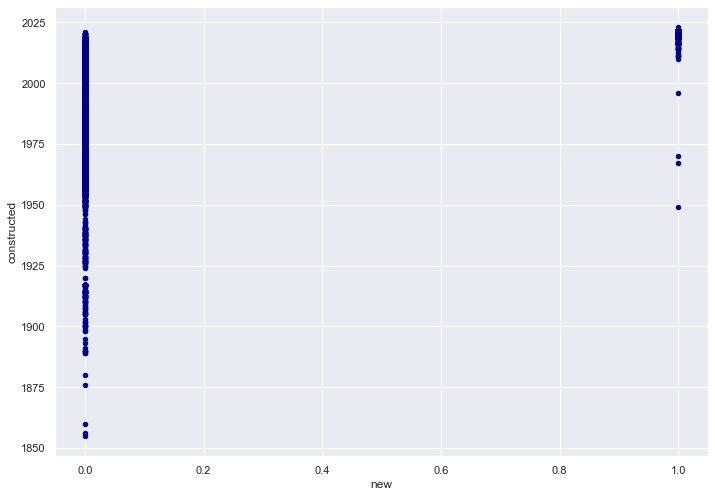

In [401]:
buildings_train.plot.scatter(x='new', y='constructed', c='DarkBlue');


#### Year of construction and stories (floors) 

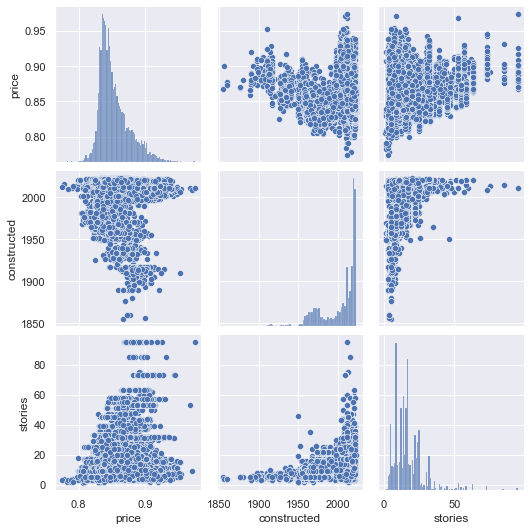

In [402]:
#scatterplot
sns.set()
cols = ['price', 'constructed', 'stories']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

#### Longitude/Latitude

The more in center of the city, the more expensive are the apartments. Especially in the south-west region (makes sense since there is more sun conditions south-west).  

In [403]:
print("Longitude min/max train:", df_train['longitude'].min(), df_train['longitude'].max())
print("Longitude min/max test:", df_test['longitude'].min(), df_test['longitude'].max())

print("Latitude min/max train:", df_train['latitude'].min(), df_train['latitude'].max())
print("Latitude min/max test:", df_test['latitude'].min(), df_test['latitude'].max())

Longitude min/max train: 36.86437100000001 37.950668
Longitude min/max test: -61.7905 132.76809699999998
Latitude min/max train: 55.21143000000001 56.00650699999999
Latitude min/max test: 17.141734 56.001625


(55.3, 56.1)

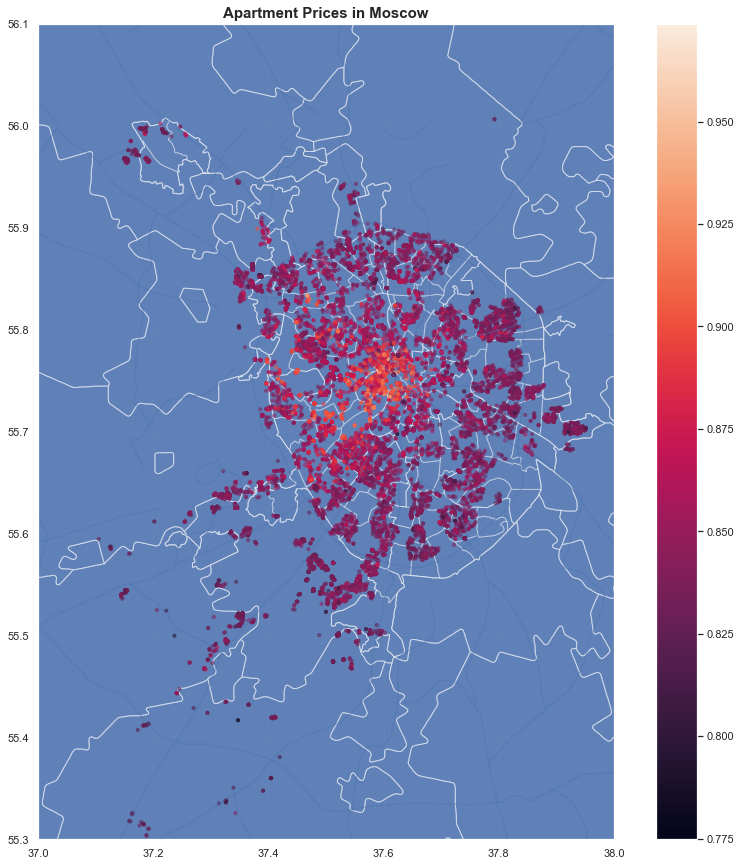

In [404]:
# Import Moscow map
#moscow = gpd.read_file('Moscow/gis_osm_places_a_free_1.shp')
#moscow = gpd.read_file('Moscow/railways.shp')

gdf1 = gpd.read_file('Moscow-shp/RUS_adm0.shp')
gdf2 = gpd.read_file('Moscow-shp/RUS_adm1.shp')
gdf3 = gpd.read_file('Moscow-shp/RUS_adm2.shp')
gdf4 = gpd.read_file('Moscow-shp/RUS_adm3.shp')
gdf5 = gpd.read_file('Moscow-shp/RUS_roads.shp')
#gdf4 = gpd.read_file('Moscow-shp/RUS_adm3.shp')

moscow = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3, gdf4, gdf5]))


# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df_train['longitude'], df_train['latitude'])]

# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df_train, geometry=geometry)

# designate coordinate system
geo_df.set_crs(epsg=4326, inplace=True)
#geo_df.to_crs(epsg=3395)
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
moscow.plot(ax=ax, alpha=0.4)
# add geodataframe to axes
# assign ‘price’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df.plot(column='price',ax=ax,alpha=0.5, legend=True,markersize=10);
# add title to graph
plt.title('Apartment Prices in Moscow', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(37,38)
plt.ylim(55.3,56.1) #55.21143000000001 56.00650699999999
# show map
#plt.show()


In [405]:
"""def south_west(df, site_coords):
    if np.isnan(site_coords).any():
        return df_train['theta'].mean()
    y = df['latitude'] - site_coords[0]
    x = df['longitude'] - site_coords[1]

    theta = np.arctan2(y, x)
    if theta < -2/3 * math.pi and theta > -5/6 * math.pi:
        return 1
   
    return 0

center_lat = 55.7558
center_lon = 37.6173

df_train['sv'] = df_train.apply(south_west, site_coords=(center_lat, center_lon), axis=1)
df_test['sv'] = df_test.apply(south_west, site_coords=(center_lat, center_lon), axis=1)

df_train = df_train.loc[df_train['sv'] == 0]""";

#### Spatial distribution of test set
Plotting test set to see spatial distribution. Use area_total as cbar since this is the value that is most correlated with price. 

(55.3, 56.1)

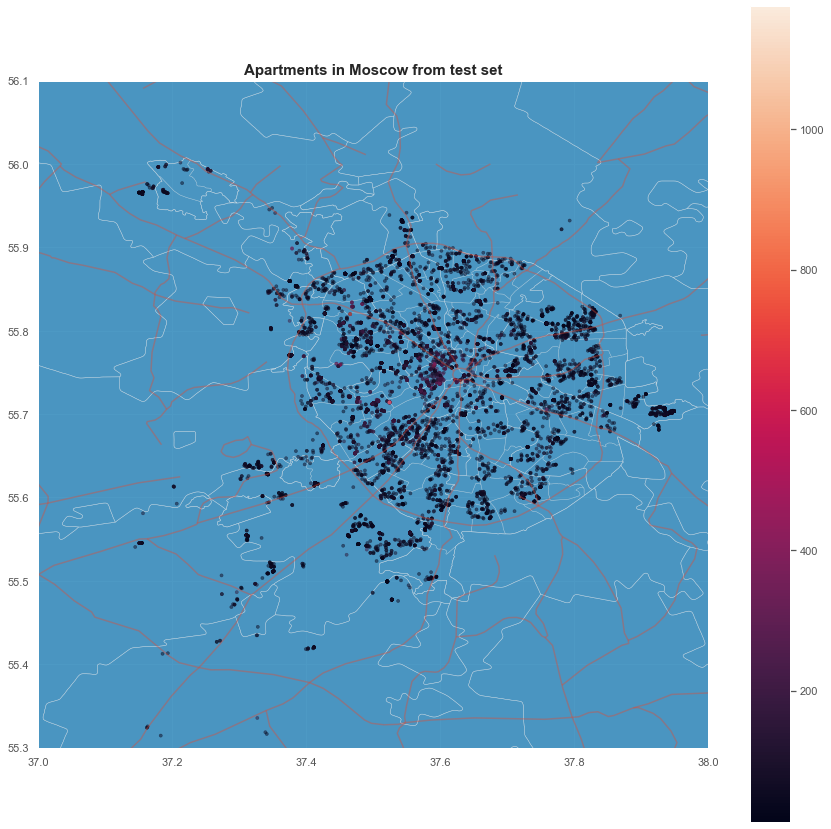

In [467]:

# Import Moscow map
#moscow = gpd.read_file('Moscow/gis_osm_places_a_free_1.shp')
#moscow = gpd.read_file('Moscow/railways.shp')

gdf1 = gpd.read_file('Moscow-shp/RUS_adm0.shp')
gdf2 = gpd.read_file('Moscow-shp/RUS_adm1.shp')
gdf3 = gpd.read_file('Moscow-shp/RUS_adm2.shp')
gdf4 = gpd.read_file('Moscow-shp/RUS_adm3.shp')
gdf5 = gpd.read_file('Moscow-shp/RUS_roads.shp')
#gdf4 = gpd.read_file('Moscow-shp/RUS_adm3.shp')

moscow = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3, gdf4, gdf5]))


# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df_test['longitude'], df_test['latitude'])]

# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df_test, geometry=geometry)

# designate coordinate system
geo_df.set_crs(epsg=4326, inplace=True)
geo_df.to_crs(epsg=3395)

# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
moscow.plot(ax=ax, alpha=0.4)
# add geodataframe to axes
# assign ‘price’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df.plot(column='area_total',ax=ax,alpha=0.5, legend=True,markersize=10);
# add title to graph
plt.title('Apartments in Moscow from test set', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(37,38)
plt.ylim(55.3,56.1) #55.21143000000001 56.00650699999999
# show map
#plt.show()


#### Spatial outlier analysis

Display all points going outside the above box 

In [407]:
display(df_test.loc[(df_test['longitude']< 36.8) | (df_test['longitude']> 38.0)])
display(df_test.loc[(df_test['latitude']< 55.2) | (df_test['latitude']> 56.1)])

coordinates_outliers = df_test.loc[(df_test['longitude']< 36.8) | (df_test['longitude']> 38.0)]
display(coordinates_outliers[['longitude', 'latitude', 'street', 'address']])

id  seller  area_total  area_kitchen  area_living  floor  rooms  \
2511  25796     NaN        19.8           5.1          9.4   11.0    1.0   
2529  25814     2.0        30.3           NaN          NaN    1.0    1.0   
4719  28004     2.0       167.0          18.0        125.0    5.0    4.0   
5090  28375     0.0        43.6           5.0         28.8    4.0    2.0   
6959  30244     NaN        19.8           5.1          9.4   11.0    1.0   
8596  31881     0.0        27.2           NaN          NaN   17.0    1.0   
9547  32832     NaN       189.0           NaN          NaN    1.0    5.0   

      layout  ceiling  bathrooms_shared  bathrooms_private  windows_court  \
2511     NaN      NaN               NaN                NaN            NaN   
2529     NaN      NaN               NaN                NaN            NaN   
4719     1.0      NaN               1.0                2.0            1.0   
5090     NaN      NaN               NaN                NaN            NaN   
6959     NaN      NaN               NaN                NaN            NaN   
8596     NaN      NaN               1.0                0.0            0.0   
9547     NaN      NaN               NaN                NaN            NaN   

      windows_street  balconies  loggias  condition  phones  building_id  new  \
2511             NaN        NaN      NaN        NaN     1.0         4636  1.0   
2529             NaN        NaN      NaN        NaN     0.0         4202  NaN   
4719             1.0        1.0      0.0        2.0     1.0         8811  0.0   
5090             NaN        NaN      NaN        NaN     0.0         4412  1.0   
6959             NaN        NaN      NaN        NaN     1.0         4636  1.0   
8596             1.0        NaN      NaN        NaN     1.0         4412  1.0   
9547             NaN        NaN      NaN        NaN     NaN         5667  NaN   

       latitude   longitude  district             street address  constructed  \
2511  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/1       2021.0   
2529  42.914700   74.517184       NaN    улица 1-я Линия      57       2016.0   
4719  43.353545  132.768097       NaN  улица Центральная      75       2007.0   
5090  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/2       2021.0   
6959  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/1       2021.0   
8596  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/2       2021.0   
9547  43.352968  132.759204       NaN  улица Центральная      48          NaN   

      material  stories  elevator_without  elevator_passenger  \
2511       3.0     17.0               1.0                 0.0   
2529       NaN      3.0               NaN                 NaN   
4719       NaN      5.0               0.0                 1.0   
5090       NaN      9.0               0.0                 1.0   
6959       3.0     17.0               1.0                 0.0   
8596       NaN      9.0               0.0                 1.0   
9547       NaN      2.0               NaN                 NaN   

      elevator_service  parking  garbage_chute  heating  living_to_total  \
2511               0.0      NaN            0.0      NaN         0.474747   
2529               NaN      NaN            NaN      NaN              NaN   
4719               1.0      1.0            1.0      NaN         0.748503   
5090               1.0      NaN            NaN      NaN         0.660550   
6959               0.0      NaN            0.0      NaN         0.474747   
8596               1.0      NaN            NaN      NaN              NaN   
9547               NaN      NaN            NaN      NaN              NaN   

                        geometry  
2511  POINT (-61.79050 17.14173)  
2529   POINT (74.51718 42.91470)  
4719  POINT (132.76810 43.35354)  
5090  POINT (-61.79050 17.14173)  
6959  POINT (-61.79050 17.14173)  
8596  POINT (-61.79050 17.14173)  
9547  POINT (132.75920 43.35297)

id  seller  area_total  area_kitchen  area_living  floor  rooms  \
2511  25796     NaN        19.8           5.1          9.4   11.0    1.0   
2529  25814     2.0        30.3           NaN          NaN    1.0    1.0   
4719  28004     2.0       167.0          18.0        125.0    5.0    4.0   
5090  28375     0.0        43.6           5.0         28.8    4.0    2.0   
6959  30244     NaN        19.8           5.1          9.4   11.0    1.0   
8596  31881     0.0        27.2           NaN          NaN   17.0    1.0   
9547  32832     NaN       189.0           NaN          NaN    1.0    5.0   

      layout  ceiling  bathrooms_shared  bathrooms_private  windows_court  \
2511     NaN      NaN               NaN                NaN            NaN   
2529     NaN      NaN               NaN                NaN            NaN   
4719     1.0      NaN               1.0                2.0            1.0   
5090     NaN      NaN               NaN                NaN            NaN   
6959     NaN      NaN               NaN                NaN            NaN   
8596     NaN      NaN               1.0                0.0            0.0   
9547     NaN      NaN               NaN                NaN            NaN   

      windows_street  balconies  loggias  condition  phones  building_id  new  \
2511             NaN        NaN      NaN        NaN     1.0         4636  1.0   
2529             NaN        NaN      NaN        NaN     0.0         4202  NaN   
4719             1.0        1.0      0.0        2.0     1.0         8811  0.0   
5090             NaN        NaN      NaN        NaN     0.0         4412  1.0   
6959             NaN        NaN      NaN        NaN     1.0         4636  1.0   
8596             1.0        NaN      NaN        NaN     1.0         4412  1.0   
9547             NaN        NaN      NaN        NaN     NaN         5667  NaN   

       latitude   longitude  district             street address  constructed  \
2511  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/1       2021.0   
2529  42.914700   74.517184       NaN    улица 1-я Линия      57       2016.0   
4719  43.353545  132.768097       NaN  улица Центральная      75       2007.0   
5090  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/2       2021.0   
6959  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/1       2021.0   
8596  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/2       2021.0   
9547  43.352968  132.759204       NaN  улица Центральная      48          NaN   

      material  stories  elevator_without  elevator_passenger  \
2511       3.0     17.0               1.0                 0.0   
2529       NaN      3.0               NaN                 NaN   
4719       NaN      5.0               0.0                 1.0   
5090       NaN      9.0               0.0                 1.0   
6959       3.0     17.0               1.0                 0.0   
8596       NaN      9.0               0.0                 1.0   
9547       NaN      2.0               NaN                 NaN   

      elevator_service  parking  garbage_chute  heating  living_to_total  \
2511               0.0      NaN            0.0      NaN         0.474747   
2529               NaN      NaN            NaN      NaN              NaN   
4719               1.0      1.0            1.0      NaN         0.748503   
5090               1.0      NaN            NaN      NaN         0.660550   
6959               0.0      NaN            0.0      NaN         0.474747   
8596               1.0      NaN            NaN      NaN              NaN   
9547               NaN      NaN            NaN      NaN              NaN   

                        geometry  
2511  POINT (-61.79050 17.14173)  
2529   POINT (74.51718 42.91470)  
4719  POINT (132.76810 43.35354)  
5090  POINT (-61.79050 17.14173)  
6959  POINT (-61.79050 17.14173)  
8596  POINT (-61.79050 17.14173)  
9547  POINT (132.75920 43.35297)

longitude   latitude             street address
2511  -61.790500  17.141734  Бунинские Луга ЖК  к2/2/1
2529   74.517184  42.914700    улица 1-я Линия      57
4719  132.768097  43.353545  улица Центральная      75
5090  -61.790500  17.141734  Бунинские Луга ЖК  к2/2/2
6959  -61.790500  17.141734  Бунинские Луга ЖК  к2/2/1
8596  -61.790500  17.141734  Бунинские Луга ЖК  к2/2/2
9547  132.759204  43.352968  улица Центральная      48

#### Three streets associated with the spatial outliers
Some of the spatial outliers belong to a street with different coordinates

In [408]:
display(df_test.loc[df_test['street'] == 'Бунинские Луга ЖК'][['longitude', 'latitude', 'street', 'address', 'district']])
display(df_test.loc[df_test['street'] == 'улица 1-я Линия'][['longitude', 'latitude', 'street', 'address', 'district']])
display(df_test.loc[df_test['street'] == 'улица Центральная'][['longitude', 'latitude', 'street', 'address',  'district']])


longitude   latitude             street address  district
6     37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
38    37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
45    37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
50    37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
80    37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
81    37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
85    37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
86    37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
88    37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
91    37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
109   37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
114   37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
136   37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
154   37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
159   37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2228  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2242  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2506  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2511 -61.790500  17.141734  Бунинские Луга ЖК  к2/2/1       NaN
2516  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2519  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2530  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2532  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2552  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2556  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2577  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2578  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2583  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2599  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2601  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2612  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
2626  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
4582  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
4583  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
4585  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
4588  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
4779  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
5090 -61.790500  17.141734  Бунинские Луга ЖК  к2/2/2       NaN
5092  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
5568  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
5750  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
6257  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
6259  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
6959 -61.790500  17.141734  Бунинские Луга ЖК  к2/2/1       NaN
6980  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
7953  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
8587  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
8596 -61.790500  17.141734  Бунинские Луга ЖК  к2/2/2       NaN
8606  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
8620  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
9518  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0
9889  37.478055  55.544046  Бунинские Луга ЖК  к2.2/1      11.0

longitude  latitude           street address  district
2529  74.517184   42.9147  улица 1-я Линия      57       NaN

longitude   latitude             street address  district
849    37.386732  55.853344  улица Центральная      4А       8.0
857    37.385493  55.853117  улица Центральная       3       8.0
859    37.384711  55.853511  улица Центральная      34       8.0
870    37.386732  55.853344  улица Центральная      4А       8.0
874    37.384711  55.853511  улица Центральная      33       8.0
876    37.385493  55.853117  улица Центральная       9       8.0
880    37.385493  55.853117  улица Центральная       3       8.0
884    37.385493  55.853117  улица Центральная       3       8.0
887    37.384711  55.853511  улица Центральная      33       8.0
891    37.384711  55.853511  улица Центральная      26       8.0
3105   37.384711  55.853511  улица Центральная      26       8.0
3113   37.387882  55.852046  улица Центральная    12к1       8.0
3126   37.384711  55.853511  улица Центральная      33       8.0
3128   37.384711  55.853511  улица Центральная      26       8.0
3424   37.386732  55.853344  улица Центральная      4А       8.0
3561   37.384711  55.853511  улица Центральная      34       8.0
3562   37.385493  55.853117  улица Центральная    11с1       8.0
4719  132.768097  43.353545  улица Центральная      75       NaN
4800   37.385493  55.853117  улица Центральная       9       8.0
5226   37.384711  55.853511  улица Центральная      34       8.0
5573   37.385493  55.853117  улица Центральная       9       8.0
5577   37.384711  55.853511  улица Центральная      26       8.0
6249   37.384711  55.853511  улица Центральная      26       8.0
6998   37.384711  55.853511  улица Центральная      26       8.0
7017   37.384711  55.853511  улица Центральная      34       8.0
7295   37.385493  55.853117  улица Центральная       3       8.0
7693   37.384711  55.853511  улица Центральная      34       8.0
7695   37.385493  55.853117  улица Центральная       9       8.0
7698   37.384711  55.853511  улица Центральная      34       8.0
7961   37.387882  55.852046  улица Центральная    12к1       8.0
8049   37.385493  55.853117  улица Центральная       9       8.0
8658   37.384711  55.853511  улица Центральная      34       8.0
9092   37.386732  55.853344  улица Центральная      4А       8.0
9098   37.384711  55.853511  улица Центральная      34       8.0
9547  132.759204  43.352968  улица Центральная      48       NaN
9565   37.384711  55.853511  улица Центральная      26       8.0
9901   37.384711  55.853511  улица Центральная      34       8.0

#### Lat/lon value corresponding to place in Kirgistan
One label in the test set does not belong to Moscow at all, however is placed in Kirgistand. Interesting...

In [409]:
df_test.loc[df_test['street'] == 'улица 1-я Линия'] 
#https://www.google.com/maps/place/42%C2%B054'52.9%22N+74%C2%B031'01.9%22E/@42.6153312,73.2399493,8z/data=!4m5!3m4!1s0x0:0x0!8m2!3d42.9147!4d74.517184





id  seller  area_total  area_kitchen  area_living  floor  rooms  \
2529  25814     2.0        30.3           NaN          NaN    1.0    1.0   

      layout  ceiling  bathrooms_shared  bathrooms_private  windows_court  \
2529     NaN      NaN               NaN                NaN            NaN   

      windows_street  balconies  loggias  condition  phones  building_id  new  \
2529             NaN        NaN      NaN        NaN     0.0         4202  NaN   

      latitude  longitude  district           street address  constructed  \
2529   42.9147  74.517184       NaN  улица 1-я Линия      57       2016.0   

      material  stories  elevator_without  elevator_passenger  \
2529       NaN      3.0               NaN                 NaN   

      elevator_service  parking  garbage_chute  heating  living_to_total  \
2529               NaN      NaN            NaN      NaN              NaN   

                       geometry  
2529  POINT (74.51718 42.91470)

### 2.6. Domain knowledge
[Go back to the "Table of contents"](#Table-of-contents)

The aim of the project is to predict prices of apartments in Moscow. In order to understand the target, we must understand the city. As appartement characteristics generally are common knowledge, we focused on acquiring new information on the specific characteristics of the city. The following resources were used for domain knowledge:

- Russia Beyond, June 12 2020 (retrieved from: https://www.rbth.com/travel/332318-expensive-rich-districts-moscow) - From this article we tried implementing features based on the distance to the seven areas presented, however we ended up using three of them as these gave the best results. 
- Edarabia, (retrieved from: https://www.edarabia.com/schools/moscow/) - From this online site we retrieved information about the most prestigious private schools in Moscow. 


### 2.7. Intuition
[Go back to the "Table of contents"](#Table-of-contents)


Based on the EDA analysis above, we have the following conclusions about the most sensible data:
- The price of an apartment increases with the area features and number of rooms. The bigger the apartment, the higher the price which is reasonable. 
- Consequently, the area features correlates positively with each other.
- There are no apartments without any types of windows. 

At the same time, there are examples in the data that are less intuitive: 
- Some apartments have a floor higher than the stories of the buildings. 
- Some apartments have living areas bigger than the total area. 
- Some apartments are categorized as old although other apartments categorized as new have the same year of construction. 
- Some apartments have a ceiling height of 0 which makes no sense. 
- There are several examples of apartments located far away from Moscow centre, but at the same time located in a street located in the centre. 
- Some buildings are said to both have an elevator and not.


### 2.8. Understanding of data generation
[Go back to the "Table of contents"](#Table-of-contents)

The EDA analysis has resulted in the following assumptions on data generation: 
- There are cases where it reasonable to replace NaN values with zero (i.e. no occurences for numerical values) or as a new category: 
    - For missing values in the elevator features, it is reasonable to assume that the building lacks an elevator and the seller avoids informing about this. Therefor NaN values within the elevator features are categorized as no elevator. This also applies for balconies/loggias. 
    
    - Originally, there is no category of parking indicating no parking. Therefore it is assumed that NaN values of parking means no parking facilities. 
    
    - If there are no information about bathroom condition, it is reasonable to assume that there are not multiple private bathrooms nor public bathrooms, only one single bathrom (since this is the most common). 
    
- Ceiling values are represented by different units, both in metres and centimetres. 

## 3. Feature clean-up
[Go back to the "Table of contents"](#Table-of-contents)

#### Module imports

In [410]:
import mxnet as mx
import scipy
import datawig
import time
import lightgbm as lgb

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox 

#### Load data: 

In [411]:
pd.set_option('display.max_columns', None)

data = Data()
data.open()
train = data.train
test = data.test
df_all = data.all

train = train.sort_index()
test = test.sort_index()
display(train)
display(test)

Loaded 23285 training samples
Loaded 9937 test samples 



id  seller       price  area_total  area_kitchen  area_living  \
0          0     3.0   7139520.0        59.2          12.5         31.0   
1          1     NaN  10500000.0        88.0          14.2         48.0   
2          2     3.0   9019650.0        78.5          22.5         40.8   
3          3     NaN  10500000.0        88.0          14.0         48.0   
4          4     NaN  13900000.0        78.0          17.0         35.0   
...      ...     ...         ...         ...           ...          ...   
23280  23280     NaN  13300000.0        65.0          16.0         32.0   
23281  23281     3.0  15854300.0        56.9           9.6         36.5   
23282  23282     NaN  19800000.0        73.4          23.0         29.3   
23283  23283     0.0  29999000.0       100.8          20.0          NaN   
23284  23284     0.0  10950000.0        57.7           8.4          NaN   

       floor  rooms  layout  ceiling  bathrooms_shared  bathrooms_private  \
0        2.0    2.0     NaN     2.65               0.0                2.0   
1       18.0    3.0     1.0      NaN               2.0                0.0   
2       12.0    3.0     NaN     2.65               0.0                2.0   
3       18.0    3.0     NaN      NaN               0.0                2.0   
4        7.0    2.0     1.0     2.90               1.0                0.0   
...      ...    ...     ...      ...               ...                ...   
23280    3.0    2.0     NaN     3.00               0.0                1.0   
23281    6.0    2.0     NaN      NaN               NaN                NaN   
23282   16.0    2.0     NaN      NaN               NaN                NaN   
23283    4.0    3.0     NaN      NaN               NaN                NaN   
23284    4.0    2.0     NaN      NaN               NaN                NaN   

       windows_court  windows_street  balconies  loggias  condition  phones  \
0                0.0             1.0        NaN      NaN        NaN     1.0   
1                1.0             1.0        1.0      0.0        3.0     1.0   
2                1.0             1.0        NaN      NaN        NaN     1.0   
3                1.0             1.0        0.0      1.0        2.0     1.0   
4                1.0             1.0        0.0      1.0        3.0     1.0   
...              ...             ...        ...      ...        ...     ...   
23280            1.0             0.0        0.0      1.0        3.0     1.0   
23281            NaN             NaN        NaN      NaN        NaN     1.0   
23282            NaN             NaN        NaN      NaN        NaN     0.0   
23283            NaN             NaN        NaN      NaN        NaN     0.0   
23284            NaN             NaN        NaN      NaN        NaN     0.0   

       building_id  new   latitude  longitude  district  \
0             4076  1.0  55.544046  37.478055      11.0   
1             1893  0.0  55.861282  37.666647       2.0   
2             5176  1.0  55.663299  37.515335       6.0   
3             1893  0.0  55.861282  37.666647       2.0   
4             6604  0.0  55.590785  37.451438      11.0   
...            ...  ...        ...        ...       ...   
23280         3139  1.0  55.770775  37.376626       7.0   
23281         7624  1.0  55.785777  37.585790       1.0   
23282         8021  0.0  55.753686  37.513143       7.0   
23283         4591  0.0  55.611302  37.696741       5.0   
23284         6553  NaN  55.708633  37.610152       5.0   

                        street address  constructed  material  stories  \
0            Бунинские Луга ЖК  к2.5/2       2021.0       3.0      9.0   
1               улица Радужная    14к3       2010.0       3.0     25.0   
2            Саларьево Парк ЖК      38       2021.0       3.0     15.0   
3               улица Радужная    14к3       2010.0       3.0     25.0   
4             улица Сервантеса     1к3       2017.0       2.0     15.0   
...                        ...     ...          ...       ...      ...   
23280   

id  seller  area_total  area_kitchen  area_living  floor  rooms  \
0     23285     NaN        71.4           NaN          NaN    2.0    1.0   
1     23286     NaN        54.0           4.0         50.0    4.0    1.0   
2     23287     3.0        39.4          19.6         11.2   10.0    1.0   
3     23288     NaN        60.9           NaN          NaN    5.0    2.0   
4     23289     NaN        34.0           9.0         17.0   14.0    1.0   
...     ...     ...         ...           ...          ...    ...    ...   
9932  33217     3.0       106.0          19.9         56.7   16.0    3.0   
9933  33218     NaN        82.0           NaN          NaN    3.0    3.0   
9934  33219     NaN        49.3           NaN          NaN   15.0    1.0   
9935  33220     NaN        38.8          10.5         15.1   14.0    1.0   
9936  33221     1.0        71.5           7.0         49.0    2.0    3.0   

      layout  ceiling  bathrooms_shared  bathrooms_private  windows_court  \
0        NaN      NaN               NaN                NaN            1.0   
1        NaN     3.00               NaN                NaN            1.0   
2        NaN     2.65               1.0                0.0            1.0   
3        1.0      NaN               1.0                0.0            0.0   
4        NaN     2.75               1.0                0.0            1.0   
...      ...      ...               ...                ...            ...   
9932     NaN     3.30               NaN                NaN            NaN   
9933     NaN      NaN               2.0                0.0            1.0   
9934     NaN     0.00               NaN                NaN            NaN   
9935     NaN     3.30               1.0                0.0            0.0   
9936     NaN      NaN               NaN                NaN            NaN   

      windows_street  balconies  loggias  condition  phones  building_id  new  \
0                0.0        1.0      0.0        0.0     1.0         5148  0.0   
1                0.0        NaN      NaN        3.0     1.0         1290  0.0   
2                0.0        NaN      NaN        NaN     1.0          681  1.0   
3                1.0        NaN      NaN        0.0     1.0         4261  0.0   
4                0.0        0.0      1.0        1.0     1.0         7530  0.0   
...              ...        ...      ...        ...     ...          ...  ...   
9932             NaN        0.0      1.0        NaN     1.0         4252  1.0   
9933             0.0        NaN      NaN        1.0     2.0         7380  1.0   
9934             NaN        NaN      NaN        NaN     1.0         1480  1.0   
9935             1.0        0.0      1.0        0.0     2.0         2154  0.0   
9936             NaN        NaN      NaN        NaN     0.0         3007  NaN   

       latitude  longitude  district                      street address  \
0     55.762247  37.549040       0.0     2-я Черногрязская улица     6к3   
1     55.591467  37.452651      11.0            улица Сервантеса     3к2   
2     55.617017  37.413718      11.0           Саларьево Парк ЖК      27   
3     55.569052  37.479510      11.0  улица Александры Монаховой      23   
4     55.518041  37.343829      11.0   улица 3-я Нововатутинская    13к1   
...         ...        ...       ...                         ...     ...   
9932  55.789750  37.456468       8.0               улица Паршина     10А   
9933  55.751639  37.516260       7.0            Западный Порт ЖК      к1   
9934  55.770659  37.375234       7.0            Рублевское шоссе    70к5   
9935  55.699943  37.637183       5.0    улица Архитектора Щусева       1   
9936  55.506510  37.273787      10.0              Ильичевка хут.       2   

      constructed  material  stories  elevator_without  elevator_passenger  \
0          2017.0       2.0     20.0               1.0                 1.0   
1          2017.0       2.0     15.0               0.0                 1.0   
2          2021.0       3.0      9.0               

### 3.1. Nonsensicle labels
[Go back to the "Table of contents"](#Table-of-contents)

#### Latitude/longitude

These coordinates are outside of Moscow, imputing with mean compared to street.

In [412]:
#Check if the data is intuitive
display(test.loc[((test['latitude'] < 55.2) | (df_test['latitude']> 56.1))][['longitude', 'latitude']])
test.loc[((test['latitude'] < 55.2) | (test['latitude'] > 56.1)) & (df_test['street'] =='Бунинские Луга ЖК' ),
         ['longitude', 'latitude']] = [37.478055, 55.544046]

mean = test.loc[((test['latitude'] > 55.2) & (test['latitude'] < 56.1)) & (df_test['street'] == 'улица Центральная'),
         ['longitude', 'latitude']].mean().values

test.loc[((test['latitude'] < 55.2) | (test['latitude']> 56.1)) & (df_test['street'] == 'улица Центральная'),
         ['longitude', 'latitude']] = mean

display(test.loc[((test['latitude'] < 55.2) | (test['latitude']> 56.1))][['longitude', 'latitude']])
display(test[test.index.isin([2511,2529,4719,5090,6959,8596,9547])][['longitude', 'latitude']])


longitude   latitude
2511  -61.790500  17.141734
2529   74.517184  42.914700
4719  132.768097  43.353545
5090  -61.790500  17.141734
6959  -61.790500  17.141734
8596  -61.790500  17.141734
9547  132.759204  43.352968

longitude  latitude
2529  74.517184   42.9147

longitude   latitude
2511  37.478055  55.544046
2529  74.517184  42.914700
4719  37.385347  55.853296
5090  37.478055  55.544046
6959  37.478055  55.544046
8596  37.478055  55.544046
9547  37.385347  55.853296

#### Ceiling

We should not use the mean, since it makes sense that the seller only informs about the ceiling height if it is a good ceiling height. Let's use 200 cm which is below the standard. 

In [413]:
#· Understand how the data was generated

train.loc[(train['ceiling'] == 0), ['ceiling']] = np.nan
test.loc[(train['ceiling'] == 0), ['ceiling']] = np.nan
train['ceiling'] = train['ceiling'].fillna(200)
test['ceiling'] = test['ceiling'].fillna(200)

train['ceiling'] = train['ceiling'].apply(lambda h: h*100 if h < 150 else h)
test['ceiling'] = test['ceiling'].apply(lambda h: h*100 if h < 150 else h)

#### Floors and Stories

There are several apartments that have a higher floor than the corresponding building's stories. We did not find any successfull solution to this problem.

In [414]:
# Set floor to number of stories in building 
# train.loc[(train['floor'] > train['stories']), ['floor']] = train['stories']
# test.loc[(test['floor'] > test['stories']), ['floor']] = test['stories']

# Let's try the opposite 
# train.loc[(train['floor'] > train['stories']), ['stories']] = train['floor']
# test.loc[(test['floor'] > test['stories']), ['stories']] = test['floor']


# Let's try the opposite 
# train.loc[(train['floor'] > train['stories']), ['stories']] = train['floor']
# test.loc[(test['floor'] > test['stories']), ['stories']] = test['floor']

### 3.2. Missing values
[Go back to the "Table of contents"](#Table-of-contents)

Displaying each attribute's number of missing values.

In [415]:
meta_lst = data.describe_data(data.apartments_train, data.apartments_meta);
meta_lst += data.describe_data(data.buildings_train, data.buildings_meta);

meta={}
for attribute in meta_lst:
    meta[attribute['name']] = {'type': attribute['type'], 'nan': df_train[attribute['name']].isna().sum()};

### 3.2.1. Continuous values
[Go back to the "Table of contents"](#Table-of-contents)

Tried fixing continuous missing values with linear regression, turned out that using Datawig gave better results.

In [416]:
# Missing value for longitude and latitude, street: пос. Коммунарка on both
mean_lat = df_test.loc[df_test['street'] == 'пос. Коммунарка']['latitude'].mean()
mean_lon = df_test.loc[df_test['street'] == 'пос. Коммунарка']['longitude'].mean()
test['latitude'] = test['latitude'].fillna(mean_lat)
test['longitude'] = test['longitude'].fillna(mean_lon)

# Linear regression on area_living and area_kitchen
def linear_regression(df, attribute, predict):
    x_train = df.loc[df.area_living.notnull()][attribute].values.reshape(-1, 1)
    y_train = df.loc[df.area_living.notnull()][predict].values.reshape(-1, 1)
    x_test = df.loc[np.isnan(df[predict])][attribute].values.reshape(-1, 1)
    reg = LinearRegression().fit(x_train, y_train)
    prediction = reg.predict(x_test)
    df.loc[df[predict].isna(), predict] = prediction

#linear_regression(train, 'area_total', 'area_living')
#linear_regression(test, 'area_total', 'area_living')


### 3.2.2. Categorical values
[Go back to the "Table of contents"](#Table-of-contents)

#### Street

Encoding values for street from string to numerical.

In [417]:
train_street = train['street'].unique()
test_street = test['street'].unique()
mask = np.isin(test_street, train_street)
overlapping_streets = test_street[mask]

print("Streets in train", train_street.size)
print("Streets in test", test_street.size)
print("Streets from test in training:", overlapping_streets.size)

for index, row in test.iterrows():
    if row['street'] in train_street:
        test.loc[index, 'street'] = np.where(train_street == row['street'])[0][0]
    else:
        train_street = np.append(train_street, row['street'])
        test.loc[index, 'street'] = np.where(train_street == row['street'])[0][0]
    
for index, row in train.iterrows():
    train.loc[index, 'street'] = np.where(train_street == row['street'])[0][0]


Streets in train 1682
Streets in test 1174
Streets from test in training: 1004


### 3.2.3. Intuitive imputation
[Go back to the "Table of contents"](#Table-of-contents)

Imputing some of the missing values based on intuition.

#### Simple imputation

Implementations by fillna

In [418]:
# The missing value of seller don't fit any of the other categories, let's make it its own.
train['seller'] = train['seller'].fillna(4)
test['seller'] = test['seller'].fillna(4)

# Plotting the missing value illustrates a consentrated graph, therefore let's make it its own.
train['parking'] = train['parking'].fillna(3)
test['parking'] = test['parking'].fillna(3)

# The three elevator attributes share the same rows for missing values, it makes sense that it means that the 
# buildings have no elevators.
train['elevator_without'] = train['elevator_without'].fillna(0)
test['elevator_without'] = test['elevator_without'].fillna(0)

train['elevator_passenger'] = train['elevator_passenger'].fillna(0) 
test['elevator_passenger'] = test['elevator_passenger'].fillna(0) 

train['elevator_service'] = train['elevator_service'].fillna(0)
test['elevator_service'] = test['elevator_service'].fillna(0)

# Don't know what to do with windows, set to new value even though they are binary?
# train['windows_court'] = train['windows_court'].fillna(2)
# test['windows_court'] = test['windows_court'].fillna(2)


# train['windows_street'] = train['windows_street'].fillna(2)
# test['windows_street'] = test['windows_street'].fillna(2)

# Assume that NaN values of balconies and loggias refer to no balconies or loggias 
train['balconies'] = train['balconies'].fillna(0)
test['balconies'] = test['balconies'].fillna(0)

train['loggias'] = train['loggias'].fillna(0)
test['loggias'] = test['loggias'].fillna(0)

# Since the range of old-building category expands from 1855-2021 and new building range from > 2010,
# we will set the limit to new buildings at 2010 (according to google - law insider). Change new category: constructed > 2010
# train.new = train.constructed.apply(lambda y: 1 if y>=2010 else 0)
# test.new = test.constructed.apply(lambda y: 1 if y>=2010 else 0)

# Assume that NaN values of garbage_chute refer to no garbage_chute
# train['garbage_chute'] = train['garbage_chute'].fillna(0)
# test['garbage_chute'] = test['garbage_chute'].fillna(0)

# Assume that NaN values of garbage_chute refer to no garbage_chute heeeeeer
# train['heating'] = train['heating'].fillna(4)
# test['heating'] = test['heating'].fillna(4)

# If both bathrooms shared and privat is NaN, the webscraping most likely did not fin any information on
# the given topic. Therefore it is logical to assume that the most minimalistic and conventional arrangement is true. 
# That is, no shared bathrooms, but only 1 privat bathroom.
train['bathrooms_shared'] = train['bathrooms_shared'].fillna(0)
test['bathrooms_shared'] = test['bathrooms_shared'].fillna(0)

train['bathrooms_private'] = train['bathrooms_private'].fillna(1)
test['bathrooms_private'] = test['bathrooms_private'].fillna(1)

# The missing value of seller don't fit any of the other categories, let's make it its own.
train['condition'] = train['condition'].fillna(4)
test['condition'] = test['condition'].fillna(4)


# The missing value of seller don't fit any of the other categories, let's make it its own.
train['layout'] = train['layout'].fillna(3)
test['layout'] = test['layout'].fillna(3)

#### District

Missing district values are filled by lokking at the district of the closest building

In [419]:
def find_closest_row(df, attribute):
    start_id = df.iloc[0]['id']
    coordinates = df[['latitude', 'longitude']]*100000
    missing_test_district = df.loc[np.isnan(df['district'])][['latitude', 'longitude']]*100000
    ary = scipy.spatial.distance.cdist(coordinates, missing_test_district, metric='euclidean')
    min_dist = pd.DataFrame(ary)
    for i, row in enumerate(missing_test_district.itertuples()):
        missing_row_index = missing_test_district.iloc[[i]].index.values[0]
        min_dist_series = min_dist[i]
        closest = min_dist_series.nsmallest(300).index.values
        for neighboor in closest:
            district_row = df_train.loc[df_train['id'] == neighboor]
            if not np.isnan(district_row['district'].values[0]):
                district = district_row['district'].values[0]
                df.loc[df['id'] == missing_row_index + start_id, ['district']] = district
                break;
                
find_closest_row(train, 'district');
find_closest_row(test, 'district');

#### Material

Material, let's check the materials of the closest building

In [420]:
def find_closest_row(df, n):
    start_id = df.iloc[0]['id']
    coordinates = df[['latitude', 'longitude']]*100000
    missing_test_district = df.loc[np.isnan(df['material'])][['latitude', 'longitude']]*100000
    ary = scipy.spatial.distance.cdist(coordinates, missing_test_district, metric='euclidean')
    min_dist = pd.DataFrame(ary)
    for i, row in enumerate(missing_test_district.itertuples()):
        missing_row_index = missing_test_district.iloc[[i]].index.values[0]
        min_dist_series = min_dist[i]
        closest = min_dist_series.nsmallest(1000).index.values
        materials = [np.nan]*n
        j = 0
        for i, neighboor in enumerate(closest):
            district_row = df_train.loc[df_train['id'] == neighboor]
            if not np.isnan(district_row['material'].values[0]):
                material = int(district_row['material'].values[0])
                materials[j] = material
                j += 1
                if j == n:
                    break;
        most_frequent = np.bincount(materials).argmax()
        df.loc[df['id'] == missing_row_index + start_id, ['material']] = most_frequent
        
find_closest_row(train, 15);
find_closest_row(test, 15);

#### Garbage chute

Garbage_chute correlates with elevator. Assume that elevator_passenger = true means that garbage_chute = true.

In [421]:
train['garbage_chute'] = train['garbage_chute'].fillna(train['elevator_passenger'])
test['garbage_chute'] = test['garbage_chute'].fillna(test['elevator_passenger'])

#### Constructed

Constructed, year of construction with number of floors in a building. Thus, make a fitted function of their correlation and replace NaN values of constructed accordingly

In [422]:
storcon = train.groupby('stories')['constructed'].agg('mean').to_frame()
storcon = storcon.reset_index().round()
#Fill "constructed" values with mean of next and previous value
storcon = (storcon.ffill()+storcon.bfill())/2
#If first value isna, fill with next
storcon = storcon.fillna(method='ffill')
#If last value isna, fill with previous
storcon = storcon.fillna(method='bfill')

for index, row in train.iterrows():
    if pd.isna(row['constructed']):
        dist = min(abs(storcon['stories'] - row['stories']))
       
        if (row['stories'] + dist) in storcon.stories:
            val = storcon.loc[storcon['stories'] == row['stories'] + dist, 'constructed'].iloc[0]
            train.loc[index, 'constructed'] = val
        else:
            val = storcon.loc[storcon['stories'] == row['stories'] + dist, 'constructed'].iloc[0]
            train.loc[index, 'constructed'] = val
            
for index, row in test.iterrows():
    if pd.isna(row['constructed']):
        dist = min(abs(storcon['stories'] - row['stories']))
       
        if (row['stories'] + dist) in storcon.stories:
            val = storcon.loc[storcon['stories'] == row['stories'] + dist, 'constructed'].iloc[0]
            test.loc[index, 'constructed'] = val
        else:
            val = storcon.loc[storcon['stories'] == row['stories'] + dist, 'constructed'].iloc[0]
            test.loc[index, 'constructed'] = val 
            

#### Datawig

We used Datawig to build a neural network, based on the N-most correlated features to the feature with missing values. Based on if the feature was continious or categorical, we decided to round the result. The rest of the missing values were imputed by this. 

In [423]:
omit_cols = ['id', 'building_id', 'street', 'address', 'price']
nan_cols = test.columns[test.isna().any()].tolist();
N = 7
ctx = mx.cpu();
start_time = time.time();

for i, nan_col in enumerate(nan_cols):
    print(nan_col)
    print(f"Attribute ({i+1}/{len(nan_cols)})")
    
    c_train = train.corr().abs().nlargest(N, nan_col)[nan_col].index;
    if 'price' in c_train:
        c_train = c_train.drop(pd.Index(['price']))
    c_train = c_train.drop(pd.Index([nan_col])); 

    print("Most correlated:", c_train.tolist())
    if nan_col not in omit_cols:
        imputer = datawig.SimpleImputer(
            input_columns=c_train, # column(s) containing information about the column we want to impute
            output_column=nan_col, # the column we'd like to impute values for
            output_path = 'datawig_imputer' # stores model data and metrics
            )
        # Fit an imputer model on the train data
        imputer.fit(train_df=train, ctx=ctx,
                   learning_rate=4e-2,
                    #num_epochs=20,
                    patience=3,
                    test_split=0.1,
                    weight_decay=0.1)

        # Impute missing values and return original dataframe with predictions
        imputed_col = nan_col + "_imputed"
        
        imputed_test = imputer.predict(test)
        imputed_train = imputer.predict(train)
        

        test.loc[np.isnan(test[nan_col]), [nan_col]] = imputed_test.loc[np.isnan(test[nan_col])][imputed_col]
        train.loc[np.isnan(train[nan_col]), [nan_col]] = imputed_train.loc[np.isnan(train[nan_col])][imputed_col]
        #test[nan_col] = imputed_test[imputed_col]
        #train[nan_col] = imputed_train[imputed_col]


    # Categorical complete
    if meta[nan_col]['type'] != 'real':
        print("Reverse categorical")
        train[nan_col] = train[nan_col].round().astype(int)
        test[nan_col] = test[nan_col].round().astype(int)
        print(test[nan_col])



print("--- %s seconds ---" % (time.time() - start_time));

area_kitchen
Attribute (1/7)
Most correlated: ['area_total', 'area_living', 'constructed', 'parking', 'rooms']
area_living
Attribute (2/7)
Most correlated: ['area_total', 'rooms', 'area_kitchen', 'bathrooms_shared', 'windows_street']
windows_court
Attribute (3/7)
Most correlated: ['windows_street', 'new', 'stories', 'constructed', 'floor', 'elevator_service']
Reverse categorical
0       1
1       1
2       1
3       0
4       1
       ..
9932    1
9933    1
9934    1
9935    0
9936    1
Name: windows_court, Length: 9937, dtype: int64
windows_street
Attribute (4/7)
Most correlated: ['windows_court', 'rooms', 'area_total', 'area_living', 'bathrooms_private', 'seller']
Reverse categorical
0       0
1       0
2       0
3       1
4       0
       ..
9932    1
9933    0
9934    0
9935    1
9936    0
Name: windows_street, Length: 9937, dtype: int64
phones
Attribute (5/7)
Most correlated: ['condition', 'new', 'layout', 'bathrooms_shared', 'balconies', 'bathrooms_private']
Reverse categorical
0

In [424]:
print("Number of missing values")
df_nan = pd.concat([train.isnull().sum().rename("Train"), test.isnull().sum().rename("Test")], axis=1)
display(df_nan)

Number of missing values


Train  Test
id                      0   0.0
seller                  0   0.0
price                   0   NaN
area_total              0   0.0
area_kitchen            0   0.0
area_living             0   0.0
floor                   0   0.0
rooms                   0   0.0
layout                  0   0.0
ceiling                 0   0.0
bathrooms_shared        0   0.0
bathrooms_private       0   0.0
windows_court           0   0.0
windows_street          0   0.0
balconies               0   0.0
loggias                 0   0.0
condition               0   0.0
phones                  0   0.0
building_id             0   0.0
new                     0   0.0
latitude                0   0.0
longitude               0   0.0
district                0   0.0
street                  0   0.0
address                 0   0.0
constructed             0   0.0
material                0   0.0
stories                 0   0.0
elevator_without        0   0.0
elevator_passenger      0   0.0
elevator_service        0   0.0
parking                 0   0.0
garbage_chute           0   0.0
heating                 0   0.0

#### LightGBM imputation

Tried using LightGBM to impute missing values, turned out that Datawig was better.

In [425]:
model = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=3, 
    random_state=42, 
    verbose=-1, 
    metric='squared_error',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
);

def light_gbm(df, predict, isTest):
    if isTest:
        X_train = df.loc[df[predict].notnull()].drop([predict], axis=1)
        y_train = df.loc[df[predict].notnull()][predict]
        X_test = df.loc[np.isnan(df[predict])].drop([predict], axis=1)
    else:
        X_train = df.loc[df[predict].notnull()].drop([predict, 'price'], axis=1)
        y_train = df.loc[df[predict].notnull()][predict]
        X_test = df.loc[np.isnan(df[predict])].drop([predict, 'price'], axis=1)
        
    model.fit(X_train, y_train);
    lgbm_prediction = model.predict(X_test)
    df.loc[df[predict].isna(), predict] = lgbm_prediction
    
# light_gbm(train, 'area_living', False)
# light_gbm(test, 'area_living', True)

In [426]:
print("Number of missing values")
df_nan = pd.concat([train.isnull().sum().rename("Train"), test.isnull().sum().rename("Test")], axis=1)
display(df_nan)

Number of missing values


Train  Test
id                      0   0.0
seller                  0   0.0
price                   0   NaN
area_total              0   0.0
area_kitchen            0   0.0
area_living             0   0.0
floor                   0   0.0
rooms                   0   0.0
layout                  0   0.0
ceiling                 0   0.0
bathrooms_shared        0   0.0
bathrooms_private       0   0.0
windows_court           0   0.0
windows_street          0   0.0
balconies               0   0.0
loggias                 0   0.0
condition               0   0.0
phones                  0   0.0
building_id             0   0.0
new                     0   0.0
latitude                0   0.0
longitude               0   0.0
district                0   0.0
street                  0   0.0
address                 0   0.0
constructed             0   0.0
material                0   0.0
stories                 0   0.0
elevator_without        0   0.0
elevator_passenger      0   0.0
elevator_service        0   0.0
parking                 0   0.0
garbage_chute           0   0.0
heating                 0   0.0

## 4. Feature engineering
[Go back to the "Table of contents"](#Table-of-contents)

#### Module imports

In [427]:
import geopy.distance

### 4.1. Feature transformations
[Go back to the "Table of contents"](#Table-of-contents)

#### Price transformation

##### Squaremeter price

Using squaremeter price instead of just price, because this often is more a descriptive parameter for a residents value.

In [428]:
df_train['price'] = df_train['price']/df_train['area_total'];

##### Log-transformation

Price has an exponential growth, therefore changing price val to log scale 

In [429]:
df_train['price'] = df_train['price'].apply(lambda x: np.log10(x));

##### Boxcox-transformation

Using box-cox instead of log-transformation

In [430]:
"""
price_arr = np.asarray(boxcox(df_train['price'].to_numpy()))
price_df = pd.DataFrame(price_arr[0], columns=['price'])
box_lambda = price_arr[1]
df_train['price'] = price_df
""";

### 4.2. Creating new features - feature extraction
[Go back to the "Table of contents"](#Table-of-contents)

#### Area Engineering

Tried creating new features with different variations of ratio between area_living, area_total, area_kitchen and rooms.

In [431]:
train["living_to_total"] = train.apply(lambda row: row['area_living'] / row['area_total'], axis=1);
test["living_to_total"] = test.apply(lambda row: row['area_living'] / row['area_total'], axis=1);

"""
train["kitchen_to_total"] = train.apply(lambda row: row['area_kitchen'] / row['area_total'], axis=1);
test["kitchen_to_total"] = test.apply(lambda row: row['area_kitchen'] / row['area_total'], axis=1);

train["kitchen_to_living"] = train.apply(lambda row: row['area_kitchen'] / row['area_living'], axis=1);
test["kitchen_to_living"] = test.apply(lambda row: row['area_kitchen'] / row['area_living'], axis=1);

train["area_per_room"] = train.apply(lambda row: row['area_total'] / row['rooms'], axis=1);
test["area_per_room"] = test.apply(lambda row: row['area_total'] / row['rooms'], axis=1);

train["living_per_room"] = train.apply(lambda row: row['area_living'] / row['rooms'], axis=1);
test["living_per_room"] = test.apply(lambda row: row['area_living'] / row['rooms'], axis=1);
""";

#### Penthouse & Ground Floor engineering

Creating categorical features for top-floor- and ground-floor-apartments. Did not work.

In [432]:
"""
mask_ground_train = train['floor']==1
mask_ground_test = test['floor']==1

mask_ground_train.loc[mask_ground_train==False] = 0
mask_ground_train.loc[mask_ground_train==True] = 1
mask_ground_test.loc[mask_ground_test==False] = 0
mask_ground_test.loc[mask_ground_test==True] = 1

train['is_ground'] = mask_ground_train
test['is_ground'] = mask_ground_test

mask_top_train = train['floor']==train['stories']
mask_top_test = test['floor']==test['stories']

mask_top_train.loc[mask_top_train==False] = 0
mask_top_train.loc[mask_top_train==True] = 1
mask_top_test.loc[mask_top_test==False] = 0
mask_top_test.loc[mask_top_test==True] = 1

train['is_penthouse'] = mask_top_train
test['is_penthouse'] = mask_top_test
""";

#### Age

Creating feature for distance age for every apartment.

In [433]:
train['age'] = 2021 - train['constructed'].astype(float) #years old from 2021
test['age'] = 2021 - test['constructed'].astype(float) #years old from 2021

train['rel_floor'] = train['floor'] / train['stories'].astype(float)
test['rel_floor'] = test['floor'] / test['stories'].astype(float)

#### Elevator and floor engineering

Creating feature for floor-to-stories-ratio for every apartment

In [434]:
train['elevator_floor'] = train.apply(lambda df: df['floor']* -1 if df['elevator_without']== 1 else df['floor']* 1, axis=1)
test['elevator_floor'] = test.apply(lambda df: df['floor']* -1 if df['elevator_without']== 1 else df['floor']* 1, axis=1)

#### Distance and Angle Engineering

All coordinates, with exception of metro, was collected using Google Maps.
All datasets are attached in the submission.

##### Red square engineering

Creating feature for distance from Red Square to every apartment.

In [435]:
def calc_distance(df, site_coords):
    station_coords = (df['latitude'], df['longitude'])
    d = geopy.distance.distance(site_coords, station_coords).km
    return(d)

In [436]:
center_lat = 55.7558
center_lon = 37.6173
train['distance'] = train.apply(calc_distance, site_coords=(center_lat, center_lon), axis=1)
test['distance'] = test.apply(calc_distance, site_coords=(center_lat, center_lon), axis=1)

##### Theta engineering

Creating feature for angle from City Centre to every apartment.

In [439]:
 def calc_degrees(df, site_coords):
    y = df['latitude'] - site_coords[0]
    x = df['longitude'] - site_coords[1]
    theta = np.arctan2(y, x)/math.pi*180 + 180
    return theta

train['theta'] = train.apply(calc_degrees, site_coords=(center_lat, center_lon), axis=1)
test['theta'] = test.apply(calc_degrees, site_coords=(center_lat, center_lon), axis=1)

##### Rublevka

Creating feature for distance from Rublevka District to every apartment.

In [440]:
rublevka_lat = 55.7380095
rublevka_lon = 37.2588927
train['rublevka'] = train.apply(calc_distance, site_coords=(rublevka_lat, rublevka_lon), axis=1)
test['rublevka'] = test.apply(calc_distance, site_coords=(rublevka_lat, rublevka_lon), axis=1)

##### Golden mile

Creating feature for distance from Golden Mile highway to every apartment. Did not work.

In [441]:
"""
golde_mile_lat = 55.739063
golde_mile_lon = 37.595975
train['golden_mile'] = train.apply(calc_distance, site_coords=(golde_mile_lat, golde_mile_lon), axis=1)
test['golden_mile'] = test.apply(calc_distance, site_coords=(golde_mile_lat, golde_mile_lon), axis=1)
""";

##### Khamovniki

Creating feature for distance from Khamovniki District to every apartment.

In [442]:
Khamovniki_lat = 55.7297634
Khamovniki_lon = 37.5710506
train['Khamovniki'] = train.apply(calc_distance, site_coords=(Khamovniki_lat, Khamovniki_lon), axis=1)
test['Khamovniki'] = test.apply(calc_distance, site_coords=(Khamovniki_lat, Khamovniki_lon), axis=1)

##### Yakimank

Creating feature for distance from Yakimank District to every apartment. Did not work.

In [443]:
"""
Yakimank_lat = 55.7287309
Yakimank_lon = 37.6121884
train['Yakimank'] = train.apply(calc_distance, site_coords=(Yakimank_lat, Yakimank_lon), axis=1)
test['Yakimank'] = test.apply(calc_distance, site_coords=(Yakimank_lat, Yakimank_lon), axis=1)
""";

##### Arbat

Creating feature for distance from Arbat District to every apartment. Did not work.

In [444]:
"""
Arbat_lat = 55.7287309
Arbat_lon = 37.6121884
train['Arbat'] = train.apply(calc_distance, site_coords=(Arbat_lat, Arbat_lon), axis=1)
test['Arbat'] = test.apply(calc_distance, site_coords=(Arbat_lat, Arbat_lon), axis=1)
""";

##### Patriarch Ponds

Creating feature for distance from Yakimank District to every apartment.

In [445]:
patriach_ponds_lat = 55.7641852
patriach_ponds_lon = 37.5898885
train['patriarch_ponds'] = train.apply(calc_distance, site_coords=(patriach_ponds_lat, patriach_ponds_lon), axis=1)
test['patriarch_ponds'] = test.apply(calc_distance, site_coords=(patriach_ponds_lat, patriach_ponds_lon), axis=1)

##### Moscow City Business Center

Creating feature for distance from Moscow City Business Center to every apartment. Did not work.

In [446]:
"""
business_center_lat = 55.7528123
business_center_lon = 37.5277152
train['patriarch_ponds'] = train.apply(calc_distance, site_coords=(business_center_lat, business_center_lon), axis=1)
test['patriarch_ponds'] = test.apply(calc_distance, site_coords=(business_center_lat, business_center_lon), axis=1)
""";

##### Barviha

Creating feature for distance from Barviha District to every apartment.

In [447]:
"""
barviha_lat = 55.7272402
barviha_lon = 37.2555005
train['barviha'] = train.apply(calc_distance, site_coords=(barviha_lat, barviha_lon), axis=1)
test['barviha'] = test.apply(calc_distance, site_coords=(barviha_lat, barviha_lon), axis=1)
""";

##### Metro engineering

Creating feature for distance to closest metro for every apartment.
The dataset was extracted from: https://en.wikipedia.org/wiki/Moscow_Metro.

In [448]:
df_metro = pd.read_csv('metro.csv', delimiter=',')
df_metro = df_metro.drop(['Snippet', 'description', 'altitude', 'name'], axis=1)

def generate_metro_distance(df_metro, df_data):
    coordinates = df_data[['longitude','latitude']]
    ary = scipy.spatial.distance.cdist(coordinates, df_metro, 'euclidean' )#lambda u,v : geopy.distance.distance(u, v).km)
    min_dist = pd.DataFrame(ary)
    min_dist = min_dist.min(axis=1)*1000
    min_dist = min_dist.reindex_like(df_data['id'], method ='ffill')
    df_data['metro_distance'] = min_dist*1000
    
generate_metro_distance(df_metro, test);
generate_metro_distance(df_metro, train);

##### Park engineering

Creating feature for distance to closest park for every apartment.
Source: Finding parks on Google Maps

In [449]:
df_parks = pd.read_csv('parks.csv', delimiter=',')
df_parks = df_parks.drop(['name'], axis=1)

def generate_park_distance(df_metro, df_data):
    coordinates = df_data[['latitude','longitude']]
    ary = scipy.spatial.distance.cdist(coordinates, df_metro, 'euclidean' ) #lambda u,v : geopy.distance.distance(u, v).km)
    min_dist = pd.DataFrame(ary)
    min_dist = min_dist.min(axis=1)*1000
    min_dist = min_dist.reindex_like(df_data['id'], method ='ffill')
    df_data['park_distance'] = min_dist*1000
    
generate_park_distance(df_parks, test);
generate_park_distance(df_parks, train);

##### School engineering

Creating feature for distance to closest prestigious private school for every apartment.
Source: https://www.edarabia.com/schools/moscow/

In [450]:
df_schools = pd.read_csv('schools.csv', delimiter=',')
df_schools = df_schools.drop(['name'], axis=1).astype(float, errors = 'raise')

def generate_school_distance(df_schools, df_data):
    coordinates = df_data[['latitude','longitude']]
    ary = scipy.spatial.distance.cdist(coordinates, df_schools, 'euclidean' ) #lambda u,v : geopy.distance.distance(u, v).km)
    min_dist = pd.DataFrame(ary)
    min_dist = min_dist.min(axis=1)*1000
    min_dist = min_dist.reindex_like(df_data['id'], method ='ffill')
    df_data['school_distance'] = min_dist*1000
    
generate_school_distance(df_schools, test);
generate_school_distance(df_schools, train);

##### Embassies engineering

Creating feature for distance to closest embassy for every apartment.
This website was used to find addresses: https://www.embassypages.com/city/moscow

In [451]:
df_embassies = pd.read_csv('embassies.csv', delimiter=',')
df_embassies= df_embassies.drop(['country'], axis=1).astype(float, errors = 'raise')

def generate_embassies_distance(df_embassies, df_data):
    coordinates = df_data[['latitude','longitude']]
    ary = scipy.spatial.distance.cdist(coordinates, df_embassies, 'euclidean' ) #lambda u,v : geopy.distance.distance(u, v).km)
    min_dist = pd.DataFrame(ary)
    min_dist = min_dist.min(axis=1)*1000
    min_dist = min_dist.reindex_like(df_data['id'], method ='ffill')
    df_data['embassy_distance'] = min_dist*1000
    
generate_embassies_distance(df_embassies, test);
generate_embassies_distance(df_embassies, train);

## 5. Drop features - feature selection
[Go back to the "Table of contents"](#Table-of-contents)

The colums omitted either have no feature importance on the LightGBM regressor, or has too many missing values. We also tried to drop the features Phone and New due to their poor feature importance scores, however the Kaggle results from these changes performed badly. Therefore we focused mostly on feature extraction as this proved to obtain satisfaying resuls.     

##### Address

Dropping address because this feature is not relevant for training.

In [452]:
train = df_train.drop(['address'], axis=1);
test = df_test.drop(['address'], axis=1);

omit_cols = []

for col in omit_cols:
    train = train.drop([col], axis=1);
    test = test.drop([col], axis=1);

##### Id

Dropping id because this feature is not relevant for training.

In [453]:
train = train.drop(['id'], axis=1);
test = test.drop(['id'], axis=1);

##### Building id

Dropping building_id because this feature is not relevant for training.

In [454]:
train = train.drop(['building_id'], axis=1);
test = test.drop(['building_id'], axis=1);

## 6. Predictors
[Go back to the "Table of contents"](#Table-of-contents)


The machine learning predictors that are used in this project are tree based and gradient boosting ensamble algorithms. We chose to use the ensamble method, Stacking, combining several boosting models in order to produce a result of higher quality than the models would have performed individually. Most tree based algorithms allow us to use skewed distributions and do not rely on scaling, thus streamline the data cleaning and modification process. 

In the following, we provide the two predictors used. Both use Stacking with LightGBM as the metamodel, but differ in choice of tree based algorithms and hyper parametres. In the first model we mainly used the handed out ensemble methods from the TDT4173 Lecture "Ensemble Learning", with the provided hyperparameters. In the second model we used the AutoML library, EvalML, to tune the hyperparameters based on cross validation, see [7.2. Tuning hyper parametres by EvalML](#7.2.-Tuning-hyper-parametres-by-EvalML). We used log transfirmation on the price for both predictors, and reversed it before submission. We also used price per square meeter as a target for the second predictor.     

#### Module imports

In [455]:
import xgboost as xgb
import sklearn.model_selection as model_selection

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from scipy.special import inv_boxcox 

### 6.1. Predictor 1
[Go back to the "Table of contents"](#Table-of-contents)

This is an old model 

In [3]:
# TRUE => no local validation prediction, only kaggle test prediction
# FALSE => no kaggle submission file, only local test on validation split
KAGGLE_SUBMISSION = True

In [4]:
pd.set_option('display.max_columns', None)
start_time = time.time();

%store -r X_train 
%store -r y_train 
%store -r X_test

%store -r df_train 
%store -r df_test


if not KAGGLE_SUBMISSION:
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=420)

display(X_train)

seller  area_total  area_kitchen  area_living  floor  rooms  layout  \
0         3.0        59.2          12.5    31.000000    2.0    2.0     3.0   
1         4.0        88.0          14.2    48.000000   18.0    3.0     1.0   
2         3.0        78.5          22.5    40.800000   12.0    3.0     3.0   
3         4.0        88.0          14.0    48.000000   18.0    3.0     3.0   
4         4.0        78.0          17.0    35.000000    7.0    2.0     1.0   
...       ...         ...           ...          ...    ...    ...     ...   
23280     4.0        65.0          16.0    32.000000    3.0    2.0     3.0   
23281     3.0        56.9           9.6    36.500000    6.0    2.0     3.0   
23282     4.0        73.4          23.0    29.300000   16.0    2.0     3.0   
23283     0.0       100.8          20.0    54.392632    4.0    3.0     3.0   
23284     0.0        57.7           8.4    23.188217    4.0    2.0     3.0   

       ceiling  bathrooms_shared  bathrooms_private  windows_court  \
0        265.0               0.0                2.0              0   
1        200.0               2.0                0.0              1   
2        265.0               0.0                2.0              1   
3        200.0               0.0                2.0              1   
4        290.0               1.0                0.0              1   
...        ...               ...                ...            ...   
23280    300.0               0.0                1.0              1   
23281    200.0               0.0                1.0              1   
23282    200.0               0.0                1.0              1   
23283    200.0               0.0                1.0              1   
23284    200.0               0.0                1.0              1   

       windows_street  balconies  loggias  condition  new   latitude  \
0                   1        0.0      0.0        4.0    1  55.544046   
1                   1        1.0      0.0        3.0    0  55.861282   
2                   1        0.0      0.0        4.0    1  55.663299   
3                   1        0.0      1.0        2.0    0  55.861282   
4                   1        0.0      1.0        3.0    0  55.590785   
...               ...        ...      ...        ...  ...        ...   
23280               0        0.0      1.0        3.0    1  55.770775   
23281               0        0.0      0.0        4.0    1  55.785777   
23282               0        0.0      0.0        4.0    0  55.753686   
23283               0        0.0      0.0        4.0    0  55.611302   
23284               0        0.0      0.0        4.0    0  55.708633   

       longitude  district  street  constructed  material  stories  \
0      37.478055      11.0       0       2021.0       3.0      9.0   
1      37.666647       2.0       1       2010.0       3.0     25.0   
2      37.515335       6.0       2       2021.0       3.0     15.0   
3      37.666647       2.0       1       2010.0       3.0     25.0   
4      37.451438      11.0       3       2017.0       2.0     15.0   
...          ...       ...     ...          ...       ...      ...   
23280  37.376626       7.0     403       2017.0       2.0     24.0   
23281  37.585790       1.0     192       2020.0       2.0     20.0   
23282  37.513143       7.0     418       2018.0       2.0     16.0   
23283  37.696741       5.0     933       1997.0       2.0     10.0   
23284  37.610152       5.0    1454       1958.0       2.0      5.0   

       elevator_without  elevator_passenger  elevator_service  parking  \
0                   0.0                 1.0               1.0      1.0   
1                   0.0                 1.0               1.0      1.0   
2                   0.0                 1.0               1.0      1.0   
3                   0.0                 1.0               1.0      1.0   
4                   0.0                 1.0               1.0      1.0   
...                 ...                 ...               ...      ...   
23280

#### LGBM

In [5]:
model = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=3, 
    random_state=42, 
    verbose=-1, 
    metric='squared_error',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
);

In [6]:
model.fit(X_train, y_train);

In [7]:
lgbm_prediction = model.predict(X_test)

In [8]:
if KAGGLE_SUBMISSION:
    df_results = pd.DataFrame({ \
    'id': df_test['id'], \
    'price_prediction': lgbm_prediction})
    
    feature_importance = pd.DataFrame([X_train.columns, model.feature_importances_]).T.sort_values([1], ascending = [False])
    display(feature_importance)

    #Revert to exponential price
    df_results['price_prediction'] = df_results['price_prediction'].apply(lambda x: 10**x);
    print(df_results);
    df_results.to_csv( 'submission.csv', index=False)
    
else:
    lgb_rmse = round(np.sqrt(mean_squared_log_error(10**lgbm_prediction, 10**y_test)), 5)
    print('Test RMSLE:', lgb_rmse)

    plt.scatter(lgbm_prediction, y_test)
    plt.xlabel('LightGBM prediction')
    plt.ylabel('Ground Truth')

    feature_importance = pd.DataFrame([X_train.columns, model.feature_importances_]).T.sort_values([1], ascending = [False])
    display(feature_importance)


0     1
1           area_total  1018
30            distance   688
19              street   685
38    embassy_distance   659
20         constructed   647
34     patriarch_ponds   631
22             stories   624
31               theta   620
33          Khamovniki   598
36       park_distance   593
35      metro_distance   524
37     school_distance   514
16            latitude   496
32            rublevka   427
2         area_kitchen   403
3          area_living   401
17           longitude   400
40           rel_floor   329
29     living_to_total   327
41      elevator_floor   317
14           condition   273
7              ceiling   271
4                floor   223
5                rooms   182
0               seller   170
21            material   162
26             parking   157
18            district   119
28             heating    99
27       garbage_chute    75
9    bathrooms_private    72
39                 age    71
13             loggias    71
12           balconies    54
6               layout    50
8     bathrooms_shared    49
24  elevator_passenger    43
23    elevator_without    38
15                 new    23
25    elevator_service    18
11      windows_street    17
10       windows_court     9

         id  price_prediction
0     23285     408449.457203
1     23286     182482.760313
2     23287     154181.018697
3     23288     148785.514594
4     23289     153197.244109
...     ...               ...
9932  33217     262148.461676
9933  33218     187509.649519
9934  33219     183817.176696
9935  33220     214781.318214
9936  33221     103579.443890

[9937 rows x 2 columns]


#### True Stacking

In [9]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    %store -r X_train
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    importance_array = np.zeros(len(X_train.columns.tolist()))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
        importance_array += clf.feature_importances_
        print(f"{round((i+1)/NFOLDS*100)}% Done")
    
    importance_array = importance_array / NFOLDS
    importance_array = importance_array / importance_array.sum()
    feature_importance = pd.DataFrame([X_train.columns, importance_array]).T.sort_values([1], ascending = [False])
    
    print("Sum:", feature_importance[1].sum())
    display(feature_importance)

    oof_test[:] = oof_test_skf.mean(axis=0)
    print("\n")

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), importance_array

In [10]:
model1 = DecisionTreeRegressor(
    criterion = 'squared_error',
    max_depth = 5,
    min_samples_split = 4,
    min_samples_leaf = 2,
    random_state=SEED
)

model2 = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=SEED,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

model3 = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    loss='square',
    random_state=SEED
)

model4 = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    subsample=1.0, 
    criterion='squared_error', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=42, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

model5 = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=SEED, 
    verbose=-1,
    metric='mse',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.005
)

model6 = CatBoostRegressor(
    n_estimators=500,
    learning_rate=0.1,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=SEED,
    bagging_temperature=0.2
)
# (- 0.001)
model7 = xgb.XGBRegressor(
    colsample_bytree=0.2,              
    learning_rate=0.0005,
    max_depth=8,
    n_estimators=1150
)

In [11]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.ravel()

In [12]:
print('OOF Model 1 starting')
dt_oof_train, dt_oof_test, importance_array_1 = get_oof(model1, X_train, y_train, X_test);
X_train = X_train.values

print('OOF Model 2 starting')
rf_oof_train, rf_oof_test, importance_array_2 = get_oof(model2, X_train, y_train, X_test)
X_train = X_train.values

print('OOF Model 3 starting')
ada_oof_train, ada_oof_test, importance_array_3 = get_oof(model3, X_train, y_train, X_test)
X_train = X_train.values

print('OOF Model 4 starting')
gb_oof_train, gb_oof_test, importance_array_4 = get_oof(model4, X_train, y_train, X_test)
X_train = X_train.values

print('OOF Model 5 starting')
lgbm_oof_train, lgbm_oof_test, importance_array_5 = get_oof(model5, X_train, y_train, X_test)
X_train = X_train.values

print('OOF Model 6 starting')
cat_oof_train, cat_oof_test, importance_array_6 = get_oof(model6, X_train, y_train, X_test)
X_train = X_train.values

print('OOF Model 7 starting')
xgb_oof_train, xgb_oof_test, importance_array_7 = get_oof(model7, X_train, y_train, X_test)
X_train = X_train.values

OOF Model 1 starting
20% Done
40% Done
60% Done
80% Done
100% Done
Sum: 1.0000000000000002


0         1
33          Khamovniki  0.692162
1           area_total  0.096854
34     patriarch_ponds  0.061667
30            distance  0.051122
37     school_distance  0.013990
26             parking  0.013132
20         constructed  0.011310
19              street  0.010209
18            district  0.009581
39                 age  0.009543
31               theta  0.004964
16            latitude  0.004919
35      metro_distance  0.003719
0               seller  0.003156
36       park_distance  0.002449
32            rublevka  0.002216
3          area_living  0.002213
38    embassy_distance  0.002193
22             stories  0.001828
17           longitude  0.001337
21            material  0.000943
5                rooms  0.000291
14           condition  0.000205
15                 new  0.000000
10       windows_court  0.000000
40           rel_floor  0.000000
2         area_kitchen  0.000000
4                floor  0.000000
6               layout  0.000000
7              ceiling  0.000000
8     bathrooms_shared  0.000000
9    bathrooms_private  0.000000
11      windows_street  0.000000
12           balconies  0.000000
29     living_to_total  0.000000
28             heating  0.000000
27       garbage_chute  0.000000
13             loggias  0.000000
25    elevator_service  0.000000
24  elevator_passenger  0.000000
23    elevator_without  0.000000
41      elevator_floor  0.000000



OOF Model 2 starting
20% Done
40% Done
60% Done
80% Done
100% Done
Sum: 0.9999999999999998


0         1
33          Khamovniki  0.526641
1           area_total  0.088139
30            distance  0.045548
34     patriarch_ponds  0.038306
18            district  0.027864
19              street  0.025959
37     school_distance  0.020692
22             stories  0.019476
38    embassy_distance  0.016860
31               theta  0.016511
39                 age  0.016124
20         constructed  0.016054
36       park_distance  0.014690
16            latitude  0.014456
35      metro_distance  0.011950
32            rublevka  0.009212
26             parking  0.009017
17           longitude  0.008619
40           rel_floor  0.008316
3          area_living  0.008239
2         area_kitchen  0.007327
41      elevator_floor  0.007215
29     living_to_total  0.006579
14           condition  0.005503
4                floor  0.005189
0               seller  0.003839
7              ceiling  0.003710
21            material  0.003087
5                rooms  0.002832
28             heating  0.001996
9    bathrooms_private  0.001583
8     bathrooms_shared  0.001437
13             loggias  0.001059
12           balconies  0.000922
6               layout  0.000900
25    elevator_service  0.000696
27       garbage_chute  0.000691
23    elevator_without  0.000618
24  elevator_passenger  0.000585
15                 new  0.000574
11      windows_street  0.000542
10       windows_court  0.000443



OOF Model 3 starting
20% Done
40% Done
60% Done
80% Done
100% Done
Sum: 1.0000000000000004


0         1
33          Khamovniki  0.181167
34     patriarch_ponds  0.107813
19              street  0.074518
38    embassy_distance  0.074259
1           area_total  0.061400
32            rublevka  0.053525
0               seller  0.052580
3          area_living  0.044287
30            distance  0.038367
26             parking  0.028656
22             stories  0.027359
27       garbage_chute  0.022705
41      elevator_floor  0.020640
16            latitude  0.017699
14           condition  0.017480
31               theta  0.017062
7              ceiling  0.016463
18            district  0.014426
2         area_kitchen  0.014192
4                floor  0.012822
29     living_to_total  0.012712
39                 age  0.011786
37     school_distance  0.011196
40           rel_floor  0.010911
36       park_distance  0.010594
6               layout  0.010513
20         constructed  0.008741
35      metro_distance  0.007489
17           longitude  0.007123
9    bathrooms_private  0.003883
8     bathrooms_shared  0.001445
28             heating  0.001230
13             loggias  0.001018
24  elevator_passenger  0.000737
11      windows_street  0.000696
10       windows_court  0.000671
5                rooms  0.000622
12           balconies  0.000479
21            material  0.000459
23    elevator_without  0.000174
25    elevator_service  0.000069
15                 new  0.000032



OOF Model 4 starting
20% Done
40% Done
60% Done
80% Done
100% Done
Sum: 0.9999999999999997


0         1
33          Khamovniki  0.525875
1           area_total  0.089372
34     patriarch_ponds  0.035809
18            district  0.032535
30            distance  0.031401
19              street  0.029595
22             stories  0.021963
31               theta  0.018979
38    embassy_distance  0.018089
20         constructed  0.017775
16            latitude  0.017493
37     school_distance  0.017459
39                 age  0.017217
36       park_distance  0.015170
35      metro_distance  0.012850
32            rublevka  0.012577
14           condition  0.010004
17           longitude  0.008282
3          area_living  0.007573
26             parking  0.007506
40           rel_floor  0.007264
41      elevator_floor  0.006602
2         area_kitchen  0.005988
29     living_to_total  0.005221
4                floor  0.005079
0               seller  0.003686
7              ceiling  0.003336
21            material  0.002610
5                rooms  0.002482
28             heating  0.002100
8     bathrooms_shared  0.001323
9    bathrooms_private  0.001318
24  elevator_passenger  0.001164
27       garbage_chute  0.000658
13             loggias  0.000638
6               layout  0.000564
12           balconies  0.000555
15                 new  0.000528
25    elevator_service  0.000423
23    elevator_without  0.000344
11      windows_street  0.000325
10       windows_court  0.000268



OOF Model 5 starting
20% Done
40% Done
60% Done
80% Done
100% Done
Sum: 1.0


0         1
1           area_total  0.086688
20         constructed  0.079562
19              street  0.075627
33          Khamovniki  0.060875
30            distance  0.060441
38    embassy_distance  0.052515
22             stories  0.051481
14           condition  0.047268
16            latitude  0.045656
31               theta  0.041988
32            rublevka  0.040053
34     patriarch_ponds  0.037797
35      metro_distance  0.036707
37     school_distance  0.034873
36       park_distance  0.032261
5                rooms  0.022433
26             parking  0.020944
4                floor  0.020877
3          area_living  0.019565
41      elevator_floor  0.018209
7              ceiling  0.016141
40           rel_floor  0.014307
0               seller  0.012606
18            district  0.010250
2         area_kitchen  0.010072
17           longitude  0.009449
28             heating  0.008526
29     living_to_total  0.006259
13             loggias  0.004858
6               layout  0.004536
39                 age  0.004147
21            material  0.003857
8     bathrooms_shared  0.002535
27       garbage_chute  0.002101
24  elevator_passenger  0.001234
15                 new  0.001067
9    bathrooms_private  0.000923
23    elevator_without  0.000656
12           balconies  0.000233
11      windows_street  0.000211
25    elevator_service  0.000211
10       windows_court  0.000000



OOF Model 6 starting
20% Done
40% Done
60% Done
80% Done
100% Done
Sum: 1.0000000000000004


0         1
33          Khamovniki  0.155017
1           area_total  0.086371
38    embassy_distance  0.062505
19              street  0.062000
34     patriarch_ponds  0.056688
18            district  0.042964
39                 age  0.039653
20         constructed  0.039517
26             parking  0.035431
36       park_distance  0.035047
22             stories  0.034665
30            distance  0.034621
35      metro_distance  0.034172
14           condition  0.032044
37     school_distance  0.029290
16            latitude  0.028508
32            rublevka  0.027977
31               theta  0.022129
0               seller  0.019989
17           longitude  0.018759
3          area_living  0.011515
5                rooms  0.010780
40           rel_floor  0.010772
41      elevator_floor  0.008746
2         area_kitchen  0.008014
7              ceiling  0.007331
21            material  0.006909
29     living_to_total  0.006489
4                floor  0.006370
28             heating  0.004700
9    bathrooms_private  0.003840
23    elevator_without  0.003764
25    elevator_service  0.002603
27       garbage_chute  0.002365
6               layout  0.002055
15                 new  0.001548
8     bathrooms_shared  0.001369
13             loggias  0.001180
24  elevator_passenger  0.001107
12           balconies  0.000807
11      windows_street  0.000284
10       windows_court  0.000107



OOF Model 7 starting
20% Done
40% Done
60% Done
80% Done
100% Done
Sum: 0.9999999999999999


0         1
33          Khamovniki  0.129740
30            distance  0.110896
34     patriarch_ponds  0.093972
38    embassy_distance  0.063952
18            district  0.054722
37     school_distance  0.053531
16            latitude  0.051155
32            rublevka  0.042698
1           area_total  0.041127
19              street  0.037142
26             parking  0.034425
36       park_distance  0.033546
17           longitude  0.033009
3          area_living  0.027186
0               seller  0.025508
31               theta  0.025197
35      metro_distance  0.024814
20         constructed  0.024777
39                 age  0.022708
2         area_kitchen  0.013861
21            material  0.012448
22             stories  0.009190
41      elevator_floor  0.008389
5                rooms  0.008347
7              ceiling  0.006664
23    elevator_without  0.006473
11      windows_street  0.001724
15                 new  0.001340
8     bathrooms_shared  0.000613
14           condition  0.000460
27       garbage_chute  0.000345
29     living_to_total  0.000038
28             heating  0.000000
13             loggias  0.000000
10       windows_court  0.000000
9    bathrooms_private  0.000000
25    elevator_service  0.000000
6               layout  0.000000
24  elevator_passenger  0.000000
4                floor  0.000000
40           rel_floor  0.000000
12           balconies  0.000000

In [13]:
x_train = np.concatenate((
    dt_oof_train,
    rf_oof_train,
    ada_oof_train,
    gb_oof_train,
    lgbm_oof_train,
    cat_oof_train,
    xgb_oof_train
), axis=1)

x_test = np.concatenate((
    dt_oof_test,
    rf_oof_test,
    ada_oof_test,
    gb_oof_test,
    lgbm_oof_test,
    cat_oof_test,
    xgb_oof_test
), axis=1)

In [14]:
META_MODEL = lgb.LGBMRegressor(
    num_leaves=5,
    max_depth=7, 
    random_state=SEED, 
    verbose=-1, 
    metric='mse',
    n_jobs=4, 
    n_estimators=200,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.05
)
META_MODEL.fit(x_train, y_train)
final_predictions = META_MODEL.predict(x_test)

print("--- %s seconds ---" % (time.time() - start_time));

--- 2725.775234937668 seconds ---


In [462]:
if KAGGLE_SUBMISSION:
    df_results = pd.DataFrame({ \
    'id': df_test['id'], \
    'price_prediction': lgbm_prediction})
    
    feature_importance = pd.DataFrame([X_train.columns, model.feature_importances_]).T.sort_values([1], ascending = [False])
    display(feature_importance)

    #Revert to exponential price
    df_results['price_prediction'] = df_results['price_prediction'].apply(lambda x: 10**x);
    print(df_results);
    df_results.to_csv( 'submission.csv', index=False)
    
else:
    lgb_rmse = round(np.sqrt(mean_squared_log_error(10**lgbm_prediction, 10**y_test)), 5)
    print('Test RMSLE:', lgb_rmse)

    plt.scatter(lgbm_prediction, y_test)
    plt.xlabel('LightGBM prediction')
    plt.ylabel('Ground Truth')

    feature_importance = pd.DataFrame([X_train.columns, model.feature_importances_]).T.sort_values([1], ascending = [False])
    display(feature_importance)


0     1
31            distance  1198
32               theta  1036
1           area_total   970
20              street   924
34       park_distance   919
21         constructed   865
18           longitude   836
17            latitude   788
23             stories   746
33      metro_distance   702
2         area_kitchen   528
30     living_to_total   418
3          area_living   367
37      elevator_floor   349
36           rel_floor   348
14           condition   287
7              ceiling   273
4                floor   205
22            material   178
0               seller   171
19            district   164
27             parking   160
5                rooms   124
9    bathrooms_private   109
8     bathrooms_shared   100
28       garbage_chute    80
35                 age    71
12           balconies    69
13             loggias    61
6               layout    60
25  elevator_passenger    40
16                 new    30
24    elevator_without    24
29             heating    18
26    elevator_service    12
11      windows_street     7
10       windows_court     0
15              phones     0

         id  price_prediction
0     23285     358759.849246
1     23286     188389.994378
2     23287     152644.427608
3     23288     155507.330263
4     23289     152760.539832
...     ...               ...
9932  33217     253750.535574
9933  33218     190144.793643
9934  33219     184930.182421
9935  33220     224478.690320
9936  33221      88979.425877

[9937 rows x 2 columns]


### 6.2. Predictor 2
[Go back to the "Table of contents"](#Table-of-contents)


In [36]:
%store -r X_train 
%store -r y_train 
%store -r X_test

%store -r df_train 
%store -r df_test

X_test_c = X_test.copy()

#### True Stacking

In [37]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    %store -r X_train
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    importance_array = np.zeros(len(X_train.columns.tolist()))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
        importance_array += clf.feature_importances_
        print(f"{round((i+1)/NFOLDS*100)}% Done")
    
    importance_array = importance_array / NFOLDS
    importance_array = importance_array / importance_array.sum()
    feature_importance = pd.DataFrame([X_train.columns, importance_array]).T.sort_values([1], ascending = [False])

    oof_test[:] = oof_test_skf.mean(axis=0)
    print("\n")

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), importance_array

In [38]:
model1 = DecisionTreeRegressor(
    criterion = 'squared_error',
    max_depth = 5,
    min_samples_split = 4,
    min_samples_leaf = 2,
    random_state=SEED
)

model2 = RandomForestRegressor(
    n_estimators = 500, 
    max_depth = 23, 
    n_jobs = -1,
    random_state = SEED
)

model3 = lgb.LGBMRegressor(
    num_leaves=10, 
    max_depth=5,
    verbose=-1,
    metric='squared_error',
    n_jobs=4, 
    n_estimators=1500, 
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.005, 
    random_state = SEED
);

model4 = CatBoostRegressor(
    n_estimators=1250,
    learning_rate=0.2,
    thread_count=-1,
    depth=7, 
    silent=True,
    bagging_temperature=0.2,
    random_seed=SEED,
)

model5 = xgb.XGBRegressor(
    eta =  0.03842638804730825,
    max_depth = 12,
    min_child_weight = 9.895364542533038,
    n_estimators = 965,
    n_jobs = -1,
    random_state = SEED
)

model6 = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    subsample=1.0, 
    criterion='mse', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=42, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

In [39]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.ravel()

In [40]:
print('OOF Model 1 starting')
dt_oof_train, dt_oof_test, importance_array_1 = get_oof(model1, X_train, y_train, X_test);
X_train = X_train.values

print('OOF Model 2 starting')
rf_oof_train, rf_oof_test, importance_array_2 = get_oof(model2, X_train, y_train, X_test)
X_train = X_train.values

print('OOF Model 3 starting')
lgbm_oof_train, lgbm_oof_test, importance_array_3 = get_oof(model3, X_train, y_train, X_test)
X_train = X_train.values

print('OOF Model 4 starting')
cat_oof_train, cat_oof_test, importance_array_4 = get_oof(model4, X_train, y_train, X_test)
X_train = X_train.values

print('OOF Model 5 starting')
xgb_oof_train, xgb_oof_test, importance_array_5 = get_oof(model5, X_train, y_train, X_test)
X_train = X_train.values

print('OOF Model 6 starting')
gb_oof_train, gb_oof_test, importance_array_6 = get_oof(model6, X_train, y_train, X_test)
X_train = X_train.values

OOF Model 1 starting
20% Done
40% Done
60% Done
80% Done
100% Done


OOF Model 2 starting
20% Done
40% Done
60% Done
80% Done
100% Done


OOF Model 3 starting
20% Done
40% Done
60% Done
80% Done
100% Done


OOF Model 4 starting
20% Done
40% Done
60% Done
80% Done
100% Done


OOF Model 5 starting
20% Done
40% Done
60% Done
80% Done
100% Done


OOF Model 6 starting
20% Done
40% Done
60% Done
80% Done
100% Done




In [41]:
x_train = np.concatenate((
    dt_oof_train,
    rf_oof_train,
    lgbm_oof_train,
    cat_oof_train,
    xgb_oof_train,
    gb_oof_train
), axis=1)

x_test = np.concatenate((
    dt_oof_test,
    rf_oof_test,
    lgbm_oof_test,
    cat_oof_test,
    xgb_oof_test,
    gb_oof_test
), axis=1)

In [42]:
META_MODEL = lgb.LGBMRegressor(
    num_leaves=5, 
    max_depth=8,
    random_state=SEED, 
    verbose=-1, 
    metric='mse',
    n_jobs=4, 
    n_estimators=300,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.08 
)
META_MODEL.fit(x_train, y_train)
final_predictions = META_MODEL.predict(x_test)

print("--- %s seconds ---" % (time.time() - start_time));

--- 3053.329996109009 seconds ---


In [43]:
%store -r X_train 
    
df_results = pd.DataFrame({ \
    'id': df_test['id'], \
    'price_prediction': final_predictions})

#Revert to exponential price
df_results['price_prediction'] = df_results['price_prediction'].apply(lambda x: 10**x);
df_results['price_prediction'] = df_results['price_prediction']*X_test_c['area_total'];
print(df_results)
df_results.to_csv( 'submission.csv', index=False)
    
models = ['DecisionTreeRegressor', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'XGBRegressor', 'GradientBoostingRegressor']
feature_importance = pd.DataFrame([models, META_MODEL.feature_importances_]).T.sort_values([1], ascending = [False])
normalized_feature_importance = feature_importance[1] / feature_importance[1].sum()
display(feature_importance)
    
meta_importance = np.zeros(importance_array_1.size)
for i, importance in  enumerate(normalized_feature_importance):
    variable = vars()['importance_array_' + str(i+1)]
    meta_importance += importance * variable
feature_importance = pd.DataFrame([X_train.columns, meta_importance]).T.sort_values([1], ascending = [False])
display(feature_importance)  
print("Sum of stacked features:", feature_importance[1].sum())    

         id  price_prediction
0     23285      2.867222e+07
1     23286      9.402465e+06
2     23287      6.059168e+06
3     23288      8.747068e+06
4     23289      5.216476e+06
...     ...               ...
9932  33217      3.207355e+07
9933  33218      1.764460e+07
9934  33219      9.327347e+06
9935  33220      9.439049e+06
9936  33221      7.247058e+06

[9937 rows x 2 columns]


0    1
2              LGBMRegressor  241
1      RandomForestRegressor  228
4               XGBRegressor  202
0      DecisionTreeRegressor  193
3          CatBoostRegressor  181
5  GradientBoostingRegressor  155

0            1
34          Khamovniki     0.346244
1           area_total    0.0896801
31            distance    0.0440544
35     patriarch_ponds    0.0392091
20              street    0.0368286
21         constructed    0.0319633
38     school_distance    0.0262464
39    embassy_distance    0.0262182
36      metro_distance    0.0233354
23             stories    0.0230347
19            district    0.0230203
17            latitude    0.0226239
37       park_distance    0.0224136
33            rublevka    0.0195385
30     living_to_total    0.0189557
32               theta     0.018496
14           condition    0.0183682
41           rel_floor    0.0171625
27             parking    0.0170575
3          area_living    0.0168766
2         area_kitchen    0.0158884
40                 age    0.0155863
42      elevator_floor    0.0126582
4                floor    0.0117249
18           longitude    0.0113484
0               seller   0.00983597
7              ceiling   0.00871985
5                rooms   0.00741634
22            material   0.00326634
29             heating   0.00305923
8     bathrooms_shared   0.00294702
6               layout   0.00234628
9    bathrooms_private   0.00224027
13             loggias   0.00215113
12           balconies   0.00152746
15              phones   0.00147275
11      windows_street   0.00126429
28       garbage_chute   0.00118979
24    elevator_without   0.00100622
16                 new  0.000933049
25  elevator_passenger  0.000746399
26    elevator_service  0.000736664
10       windows_court  0.000607595

Sum of stacked features: 1.0000000000000002


## 7. Model interpretation
[Go back to the "Table of contents"](#Table-of-contents)



#### Module imports

In [ ]:
import evalml
from evalml import AutoMLSearch
from evalml.utils import infer_feature_types
from pprint import pprint
from evalml.data_checks import HighlyNullDataCheck, IDColumnsDataCheck

### 7.1. Feature importance
Feature importance is impleemented as part of the Stacking in [Predictors](#6.-Predictors). This shows each attribute's importance by how many times the feature is splitted in the consgruction of the boostied decision trees within the model. We have not only calculated feature importance for each individual predictor, but also its feature importance relative to the importance of the models within the metamodel.   

In [ ]:
display(feature_importance)

### 7.2. Tuning hyper parametres by EvalML 
We tried out the results of EvalML and chose the ones who reduced our Kaggle score. 

In [2]:
pd.set_option('display.max_columns', None)
start_time = time.time();

%store -r X_train 
%store -r y_train 
%store -r X_test

%store -r df_train 
%store -r df_test

display(df_train)

id  seller     price  area_total  area_kitchen  area_living  floor  \
0          0     3.0  6.853669        59.2          12.5         31.0    2.0   
1          1     NaN  7.021189        88.0          14.2         48.0   18.0   
2          2     3.0  6.955190        78.5          22.5         40.8   12.0   
3          3     NaN  7.021189        88.0          14.0         48.0   18.0   
4          4     NaN  7.143015        78.0          17.0         35.0    7.0   
...      ...     ...       ...         ...           ...          ...    ...   
23280  23280     NaN  7.123852        65.0          16.0         32.0    3.0   
23281  23281     3.0  7.200147        56.9           9.6         36.5    6.0   
23282  23282     NaN  7.296665        73.4          23.0         29.3   16.0   
23283  23283     0.0  7.477107       100.8          20.0          NaN    4.0   
23284  23284     0.0  7.039414        57.7           8.4          NaN    4.0   

       rooms  layout  ceiling  bathrooms_shared  bathrooms_private  \
0        2.0     NaN     2.65               0.0                2.0   
1        3.0     1.0      NaN               2.0                0.0   
2        3.0     NaN     2.65               0.0                2.0   
3        3.0     NaN      NaN               0.0                2.0   
4        2.0     1.0     2.90               1.0                0.0   
...      ...     ...      ...               ...                ...   
23280    2.0     NaN     3.00               0.0                1.0   
23281    2.0     NaN      NaN               NaN                NaN   
23282    2.0     NaN      NaN               NaN                NaN   
23283    3.0     NaN      NaN               NaN                NaN   
23284    2.0     NaN      NaN               NaN                NaN   

       windows_court  windows_street  balconies  loggias  condition  phones  \
0                0.0             1.0        NaN      NaN        NaN     1.0   
1                1.0             1.0        1.0      0.0        3.0     1.0   
2                1.0             1.0        NaN      NaN        NaN     1.0   
3                1.0             1.0        0.0      1.0        2.0     1.0   
4                1.0             1.0        0.0      1.0        3.0     1.0   
...              ...             ...        ...      ...        ...     ...   
23280            1.0             0.0        0.0      1.0        3.0     1.0   
23281            NaN             NaN        NaN      NaN        NaN     1.0   
23282            NaN             NaN        NaN      NaN        NaN     0.0   
23283            NaN             NaN        NaN      NaN        NaN     0.0   
23284            NaN             NaN        NaN      NaN        NaN     0.0   

       building_id  new   latitude  longitude  district  \
0             4076  1.0  55.544046  37.478055      11.0   
1             1893  0.0  55.861282  37.666647       2.0   
2             5176  1.0  55.663299  37.515335       6.0   
3             1893  0.0  55.861282  37.666647       2.0   
4             6604  0.0  55.590785  37.451438      11.0   
...            ...  ...        ...        ...       ...   
23280         3139  1.0  55.770775  37.376626       7.0   
23281         7624  1.0  55.785777  37.585790       1.0   
23282         8021  0.0  55.753686  37.513143       7.0   
23283         4591  0.0  55.611302  37.696741       5.0   
23284         6553  NaN  55.708633  37.610152       5.0   

                        street address  constructed  material  stories  \
0            Бунинские Луга ЖК  к2.5/2       2021.0       3.0      9.0   
1               улица Радужная    14к3       2010.0       3.0     25.0   
2            Саларьево Парк ЖК      38       2021.0       3.0     15.0   
3               улица Радужная    14к3       2010.0       3.0     25.0   
4             улица Сервантеса     1к3       2017.0       2.0     15.0   
...                        ...     ...          ...       ...      ...   
23280         Рублевское шоссе  

In [3]:
X_train, X_holdout, y_train, y_holdout = evalml.preprocessing.split_data(
    X_train, y_train, problem_type='REGRESSION', test_size=.2)

In [4]:
automl_rmse = AutoMLSearch(X_train=X_train, y_train=y_train,
                          problem_type='REGRESSION',
                          objective='root mean squared error',
                          max_batches=100,
                          optimize_thresholds=True,
                          ensembling=True,
                          verbose=True)

automl_rmse.search()

Unable to import plotly; skipping pipeline search plotting

Generating pipelines to search over...
Ensembling will run every 8 batches.
7 pipelines ready for search.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Root Mean Squared Error. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 100 batches for a total of 455 pipelines. 
Allowed model families: linear_model, xgboost, lightgbm, catboost, random_forest, decision_tree, extra_trees

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.376

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Regressor w/ Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.124
XGBoost Regressor w/ Imputer

LightGBM Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.239
LightGBM Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.246

******************************
* Evaluating Batch Number 12 *
******************************

Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073
Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073
Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.074
Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073
Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.136

******************

	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.142
Elastic Net Regressor w/ Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.142
Elastic Net Regressor w/ Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.142

******************************
* Evaluating Batch Number 24 *
******************************

CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.095
CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.095
CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.095
CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.095
CatBoost Regressor w/ Imputer:
	S

	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073
Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073
Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073
Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073
Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073

******************************
* Evaluating Batch Number 37 *
******************************

Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.182
Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.182
Extra Trees Regressor w/ Imputer:
	Starting cross


******************************
* Evaluating Batch Number 48 *
******************************

CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.068
CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.068
CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.068
CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.068
CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.068

******************************
* Evaluating Batch Number 49 *
******************************

Stacked Ensemble Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.059

******************************
* Evaluating Batch Number 50 *
**

	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073
Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.073

******************************
* Evaluating Batch Number 61 *
******************************

Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.104
Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.104
Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.104
Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.104
Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.104

******************************
* Evaluating Batch Numb

CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.197
CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.197
CatBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.197

******************************
* Evaluating Batch Number 73 *
******************************

Stacked Ensemble Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.059

******************************
* Evaluating Batch Number 74 *
******************************

XGBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.068
XGBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.068
XGBoost Regressor w/ Imputer:
	Starting cross validation
	Finished 


Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.097
Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.097
Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.097
Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.097
Extra Trees Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.097

******************************
* Evaluating Batch Number 86 *
******************************

Decision Tree Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.104
Decision Tree Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.104
Decision Tree Regr


******************************
* Evaluating Batch Number 97 *
******************************

Stacked Ensemble Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.059

******************************
* Evaluating Batch Number 98 *
******************************

XGBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.062
XGBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.062
XGBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.062
XGBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.062
XGBoost Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.062

******************************
* Evaluating Batch Number 99 *
*******

In [5]:
best_pipeline_rmse=automl_rmse.best_pipeline
automl_rmse.rankings

id                                      pipeline_name  search_order  \
0     48                       XGBoost Regressor w/ Imputer            48   
1    403               Stacked Ensemble Regression Pipeline           403   
48   364                      CatBoost Regressor w/ Imputer           364   
53    51                      LightGBM Regressor w/ Imputer            51   
93    54                 Random Forest Regressor w/ Imputer            54   
222  347                   Extra Trees Regressor w/ Imputer           347   
248  282                 Decision Tree Regressor w/ Imputer           282   
296    1  Elastic Net Regressor w/ Imputer + Standard Sc...             1   
449    0                  Mean Baseline Regression Pipeline             0   

     mean_cv_score  standard_deviation_cv_score  validation_score  \
0         0.058919                     0.002018          0.061221   
1         0.059324                     0.001876          0.061462   
48        0.066962                     0.000802          0.067874   
53        0.067570                     0.001756          0.069542   
93        0.072659                     0.001323          0.073656   
222       0.091972                     0.000895          0.092664   
248       0.103651                     0.002891          0.106711   
296       0.124375                     0.000737          0.125105   
449       0.375628                     0.005132          0.378064   

     percent_better_than_baseline  high_variance_cv  \
0                       84.314655             False   
1                       84.206852             False   
48                      82.173328             False   
53                      82.011407             False   
93                      80.656568             False   
222                     75.515211             False   
248                     72.405921             False   
296                     66.888729             False   
449                      0.000000             False   

                                            parameters  
0    {'Imputer': {'categorical_impute_strategy': 'm...  
1    {'Linear Pipeline - Imputer': {'categorical_im...  
48   {'Imputer': {'categorical_impute_strategy': 'm...  
53   {'Imputer': {'categorical_impute_strategy': 'm...  
93   {'Imputer': {'categorical_impute_strategy': 'm...  
222  {'Imputer': {'categorical_impute_strategy': 'm...  
248  {'Imputer': {'categorical_impute_strategy': 'm...  
296  {'Imputer': {'categorical_impute_strategy': 'm...  
449       {'Baseline Regressor': {'strategy': 'mean'}}

In [6]:
for i in range(5):
    automl_rmse.describe_pipeline(automl_rmse.rankings.iloc[i]['id'])


********************************
* XGBoost Regressor w/ Imputer *
********************************

Problem Type: regression
Model Family: XGBoost

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. XGBoost Regressor
	 * eta : 0.03842638804730825
	 * max_depth : 12
	 * min_child_weight : 9.895364542533038
	 * n_estimators : 965
	 * n_jobs : -1

Training
Training for regression problems.
Total training time (including CV): 60.4 seconds

Cross Validation
----------------
             Root Mean Squared Error  ExpVariance  MaxError  MedianAE   MSE   MAE    R2 # Training # Validation
0                              0.061        0.974     0.981     0.021 0.004 0.037 0.974     12,019        6,010
1                              0.057        0.976     0.869     0.022 0.003 0.036 0.976     12,019        6,010
2                              0.058        0.977     0.709     

	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. Random Forest Regressor
	 * n_estimators : 719
	 * max_depth : 31
	 * n_jobs : -1

Training
Training for regression problems.
Total training time (including CV): 61.4 seconds

Cross Validation
----------------
             Root Mean Squared Error  ExpVariance  MaxError  MedianAE   MSE   MAE    R2 # Training # Validation
0                              0.074        0.962     1.026     0.025 0.005 0.044 0.962     12,019        6,010
1                              0.071        0.963     1.138     0.024 0.005 0.042 0.963     12,019        6,010
2                              0.073        0.963     0.864     0.024 0.005 0.043 0.963     12,020        6,009
mean                           0.073        0.963     1.009     0.024 0.005 0.043 0.963          -            -
std                            0.001        0.000     0.138     0.000 0.000 0.001 0.000          -            -
coef of var                    0.018        0.001  

In [7]:
best_pipeline_rmse.score(X_holdout, y_holdout, objectives=['root mean squared log error'])

OrderedDict([('Root Mean Squared Log Error', 0.00664993928213015)])